Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Optimized XGBoost for Each Synthetic Data

* CTGAN synthetic data got most similar feature distributions as real data
* CastGAN synthetic data got best baseline model performance

In [1]:
import pandas as pd
import numpy as np
import timeit
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from xgboost import XGBClassifier, plot_importance
import xgboost as xgb
import optuna

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Load Data

In [2]:
target = 'deposit'
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

raw_df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/campaign_deposit.pkl')
raw_df[cat_cols] = raw_df[cat_cols].astype('category')
X_train, X_test, y_train, y_test = train_test_split(raw_df.drop(target, axis=1), raw_df[target], 
                                                    test_size=0.25, random_state=10,
                                                    stratify=raw_df[target])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

ctgan_syn_X_train = pd.read_csv('ctgan_syn_X_train_10.csv')
castgan_syn_X_train = pd.read_csv('CasTGAN/Generated_Data/wb_0/campaign_fake_20230901-2310.csv')
ctgan_syn_X_train[cat_cols] = ctgan_syn_X_train[cat_cols].astype('category')
castgan_syn_X_train[cat_cols] = castgan_syn_X_train[cat_cols].astype('category')

print(ctgan_syn_X_train.shape, castgan_syn_X_train.shape)

(8371, 16) (2791, 16) (8371,) (2791,)
(8371, 16) (8371, 16)


In [3]:
def get_opt_data(X_train, y_train, 
                 test_size=0.2, random_state=10,
                 stratify=y_train):
    opt_X_train, opt_X_val, opt_y_train, opt_y_val = train_test_split(X_train, y_train, 
                                                                      test_size=test_size,
                                                                      random_state=random_state,
                                                                      stratify=stratify)
    print(opt_X_train.shape, opt_y_train.shape, opt_X_val.shape, opt_y_val.shape)
    print(opt_y_train.value_counts()*100/opt_y_train.shape)
    print(opt_y_val.value_counts()*100/opt_y_val.shape)

    opt_X_train.reset_index(inplace=True, drop=True)
    opt_X_val.reset_index(inplace=True, drop=True)
    opt_y_train.reset_index(inplace=True, drop=True)
    opt_y_val.reset_index(inplace=True, drop=True)
    
    return opt_X_train, opt_X_val, opt_y_train, opt_y_val

In [4]:
ctgan_opt_X_train, ctgan_opt_X_val, ctgan_opt_y_train, ctgan_opt_y_val = get_opt_data(
                                                                                      ctgan_syn_X_train,
                                                                                      y_train, 
                                                                                      test_size=0.2,
                                                                                      random_state=10,
                                                                                      stratify=y_train)
print()

castgan_opt_X_train, castgan_opt_X_val, castgan_opt_y_train, castgan_opt_y_val = get_opt_data(
                                                                                      castgan_syn_X_train,
                                                                                      y_train, 
                                                                                      test_size=0.2,
                                                                                      random_state=10,
                                                                                      stratify=y_train)

(6696, 16) (6696,) (1675, 16) (1675,)
deposit
0    52.613501
1    47.386499
Name: count, dtype: float64
deposit
0    52.597015
1    47.402985
Name: count, dtype: float64

(6696, 16) (6696,) (1675, 16) (1675,)
deposit
0    52.613501
1    47.386499
Name: count, dtype: float64
deposit
0    52.597015
1    47.402985
Name: count, dtype: float64


## XGBoost Baseline

* XGBoost params: https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster

In [5]:
def get_model_performance(model_params, X_train, y_train, 
                          X_test, y_test, 
                          plot_feat_impt=False, plot_w=5, plot_h=5):
    model = XGBClassifier(**model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    avp = average_precision_score(y_test, y_pred)
    
    print(f'Testing AUC is {auc}, Testing Average Precision is {avp}')
    
    if plot_feat_impt:
        fig, ax = plt.subplots(figsize=(plot_w, plot_h))
        plot_importance(model, importance_type='gain', 
                        values_format='{v:.2f}', ax=ax)

In [6]:
model_params = {'booster': 'gbtree', 'nthread': 4, 'seed': 10, 'eval_metric': 'auc',
                'objective': 'binary:hinge', 'max_depth': 8, 'min_child_weight': 3,
                'subsample': 0.8, 'enable_categorical': True,
                'learning_rate': 0.17937097905882862}

get_model_performance(model_params, 
                      ctgan_syn_X_train, y_train,
                      X_test, y_test)

get_model_performance(model_params, 
                      castgan_syn_X_train, y_train,
                      X_test, y_test)

Testing AUC is 0.545061116838258, Testing Average Precision is 0.49845726679790137
Testing AUC is 0.5449171943823383, Testing Average Precision is 0.4976829134847979


## Tune XGBoost for Each Synthetic Data

* NOTE: Can't use `XGBoostPruningCallback` with XGBoost 2.0.0 and Optuna 3.3.0 (they are both the latest versions now).
    * Because Optuna hasn't released the bug fix, [see this post][1]
    * Lady H. had an unpleasant experience when interacting with XGBoost community, now she's even less willing to use XGBoost in the future...[see this post][2]
  
[1]:https://github.com/optuna/optuna/pull/4920
[2]:https://github.com/dmlc/xgboost/issues/9608

In [6]:
def get_hpo_params(opt_X_train, opt_X_val, opt_y_train, opt_y_val, n_trials=180):
    """
        To make below optuna output reproducible, need to set hashseed in your OS: 
        https://gerrychain.readthedocs.io/en/latest/topics/reproducibility.html#set-pythonhashseed-0
        This is ot make pruning behaviour replicable.
    """
    
    def objective(trial):
        dtrain = xgb.DMatrix(opt_X_train, label=opt_y_train, enable_categorical=True)
        dval = xgb.DMatrix(opt_X_val, label=opt_y_val, enable_categorical=True)

        params = {
            'objective': 'binary:hinge',
            'verbosity': 0,
            'eval_metric': 'auc',
            'seed': 10,
            'nthread': 4,
            'saved_feature_importance_type': 1,  # 1 means "gain", 0 means "split"

            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
            'subsample': trial.suggest_float('subsample', 0.8, 1),
            'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
            'lambda': trial.suggest_float('lambda', 0.001, 0.5),
            'gamma': trial.suggest_float('gamma', 0.1, 1),
            'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
        }
        
        if params['booster'] == 'dart':
            params['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
            params['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
            params['rate_drop'] = trial.suggest_float('rate_drop', 0, 0.2)
            params['skip_drop'] = trial.suggest_float('skip_drop', 0, 0.2)
            
        clf = xgb.train(
            params, dtrain, evals=[(dval, "validation")]
        )

        y_val_pred = clf.predict(dval)
        avp = average_precision_score(opt_y_val, y_val_pred)
        return avp


    start = timeit.default_timer()
    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.HyperbandPruner(),
                               sampler=optuna.samplers.TPESampler(seed=10), study_name='xgb_hpo')
    study.optimize(objective, n_trials=n_trials)

    print("Number of finished trials: {}".format(len(study.trials)))
    best_trial = study.best_trial
    print(f"Best trial performance: {best_trial.value}")
    stop = timeit.default_timer()
    print('Time (min): ', (stop - start)/60)
    
    return best_trial.params


def get_best_params(constant_params, opt_X_train,
                    opt_X_val, opt_y_train, opt_y_val,
                    n_trials=180):
    best_params = get_hpo_params(opt_X_train, opt_X_val, opt_y_train, opt_y_val,
                                 n_trials=n_trials)
    best_params.update(constant_params)
    print(best_params)
    
    return best_params

In [11]:
constant_params = {'objective': 'binary:hinge', 'enable_categorical': True, 'eval_metric': 'auc',
                   'seed': 10, 'nthread': 4, 'saved_feature_importance_type': 1, 'verbosity': 0}

ctgan_best_params = get_best_params(constant_params,
                    ctgan_opt_X_train, ctgan_opt_X_val, ctgan_opt_y_train, ctgan_opt_y_val,
                    n_trials=200)  # 500 trials didn't have much difference as 200 trials

castgan_best_params = get_best_params(constant_params,
                    castgan_opt_X_train, castgan_opt_X_val, castgan_opt_y_train, castgan_opt_y_val,
                    n_trials=200)  # 500 trials didn't have much difference as 200 trials

[I 2023-09-28 00:21:11,906] A new study created in memory with name: xgb_hpo


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:21:12,123] Trial 0 finished with value: 0.47402985074626863 and parameters: {'max_depth': 9, 'learning_rate': 0.0051296379225208985, 'min_child_weight': 4, 'subsample': 0.9497607765077224, 'booster': 'gbtree', 'lambda': 0.09983336951505237, 'gamma': 0.7844776409790628, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.47402985074626863.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.49988
[3]	validation-auc:0.50044
[4]	validation-auc:0.50177
[5]	validation-auc:0.50014
[6]	validation-auc:0.50021
[7]	validation-auc:0.49764
[8]	validation-auc:0.49790
[9]	validation-auc:0.49734


[I 2023-09-28 00:21:12,348] Trial 1 finished with value: 0.47270830244317485 and parameters: {'max_depth': 8, 'learning_rate': 0.1907252758927924, 'min_child_weight': 1, 'subsample': 0.9024384526771554, 'booster': 'gbtree', 'lambda': 0.361155903398468, 'gamma': 0.3626884613535699, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.47402985074626863.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:21:12,539] Trial 2 finished with value: 0.47402985074626863 and parameters: {'max_depth': 7, 'learning_rate': 0.02929183947270387, 'min_child_weight': 2, 'subsample': 0.9348267230132691, 'booster': 'gbtree', 'lambda': 0.30926572225618926, 'gamma': 0.5618244182989518, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.47402985074626863.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50114
[7]	validation-auc:0.50107
[8]	validation-auc:0.50265
[9]	validation-auc:0.50372


[I 2023-09-28 00:21:12,980] Trial 3 finished with value: 0.47589417484215596 and parameters: {'max_depth': 9, 'learning_rate': 0.1048077833263332, 'min_child_weight': 5, 'subsample': 0.8638472177977091, 'booster': 'dart', 'lambda': 0.05787819656991133, 'gamma': 0.845813193676909, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.07033052788641758, 'skip_drop': 0.15092953830597144}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.49918
[8]	validation-auc:0.50007
[9]	validation-auc:0.50051


[I 2023-09-28 00:21:13,142] Trial 4 finished with value: 0.47428590520314623 and parameters: {'max_depth': 5, 'learning_rate': 0.17690335943267607, 'min_child_weight': 2, 'subsample': 0.8330031795438297, 'booster': 'gbtree', 'lambda': 0.4107317232606273, 'gamma': 0.23603681767830748, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.49937
[8]	validation-auc:0.49874
[9]	validation-auc:0.50051


[I 2023-09-28 00:21:13,708] Trial 5 finished with value: 0.4742819787087726 and parameters: {'max_depth': 10, 'learning_rate': 0.09180460487186204, 'min_child_weight': 5, 'subsample': 0.8502748268414119, 'booster': 'dart', 'lambda': 0.2677444164521057, 'gamma': 0.6311812266868806, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.007991841737995454, 'skip_drop': 0.08589843568632767}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.49994
[9]	validation-auc:0.49994


[I 2023-09-28 00:21:13,857] Trial 6 finished with value: 0.4739988436437496 and parameters: {'max_depth': 5, 'learning_rate': 0.12766173747044138, 'min_child_weight': 2, 'subsample': 0.808619471240999, 'booster': 'gbtree', 'lambda': 0.4391702247197043, 'gamma': 0.4757582294553403, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:21:14,024] Trial 7 finished with value: 0.47402985074626863 and parameters: {'max_depth': 7, 'learning_rate': 0.053180916565258106, 'min_child_weight': 2, 'subsample': 0.8050799564100213, 'booster': 'gbtree', 'lambda': 0.27923151614265945, 'gamma': 0.6089563178993508, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:21:14,145] Trial 8 finished with value: 0.47402985074626863 and parameters: {'max_depth': 3, 'learning_rate': 0.1957850100057709, 'min_child_weight': 2, 'subsample': 0.8990097261764909, 'booster': 'gbtree', 'lambda': 0.15981812993399666, 'gamma': 0.5678172872878422, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:21:14,275] Trial 9 finished with value: 0.47402985074626863 and parameters: {'max_depth': 3, 'learning_rate': 0.09344163074808717, 'min_child_weight': 4, 'subsample': 0.94372056207645, 'booster': 'gbtree', 'lambda': 0.17597753925028337, 'gamma': 0.6068716160434705, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49994
[4]	validation-auc:0.50107
[5]	validation-auc:0.50038
[6]	validation-auc:0.50007
[7]	validation-auc:0.49938
[8]	validation-auc:0.50184
[9]	validation-auc:0.49901


[I 2023-09-28 00:21:15,031] Trial 10 finished with value: 0.4735381524769348 and parameters: {'max_depth': 10, 'learning_rate': 0.14335808178428458, 'min_child_weight': 5, 'subsample': 0.86890641509825, 'booster': 'dart', 'lambda': 0.003808853222552422, 'gamma': 0.9953648351940233, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.13740298657072936, 'skip_drop': 0.1908478556470133}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50057
[7]	validation-auc:0.50107
[8]	validation-auc:0.50101
[9]	validation-auc:0.49912


[I 2023-09-28 00:21:15,366] Trial 11 finished with value: 0.47359220916833966 and parameters: {'max_depth': 5, 'learning_rate': 0.15394550472266855, 'min_child_weight': 3, 'subsample': 0.8475531716009284, 'booster': 'dart', 'lambda': 0.4706681913114227, 'gamma': 0.16621153002183048, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.07024416265510657, 'skip_drop': 0.000897062076451377}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50057
[6]	validation-auc:0.50057
[7]	validation-auc:0.50057
[8]	validation-auc:0.50057
[9]	validation-auc:0.50051


[I 2023-09-28 00:21:15,726] Trial 12 finished with value: 0.4742819787087726 and parameters: {'max_depth': 5, 'learning_rate': 0.1668760031743846, 'min_child_weight': 3, 'subsample': 0.8363188658977478, 'booster': 'dart', 'lambda': 0.3768089315453678, 'gamma': 0.19932959021445293, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.1999238451497578, 'skip_drop': 0.1815668654983973}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49862
[5]	validation-auc:0.49918
[6]	validation-auc:0.49975
[7]	validation-auc:0.49660
[8]	validation-auc:0.49818
[9]	validation-auc:0.49705


[I 2023-09-28 00:21:16,125] Trial 13 finished with value: 0.47256531580754296 and parameters: {'max_depth': 6, 'learning_rate': 0.12225877204326553, 'min_child_weight': 1, 'subsample': 0.9836614805603079, 'booster': 'dart', 'lambda': 0.48581588214309096, 'gamma': 0.31030198816893384, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.06444649462279578, 'skip_drop': 0.1291368375895128}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:21:16,652] Trial 14 finished with value: 0.47402985074626863 and parameters: {'max_depth': 8, 'learning_rate': 0.07445237928993687, 'min_child_weight': 4, 'subsample': 0.8750450662965004, 'booster': 'dart', 'lambda': 0.19934820889374855, 'gamma': 0.10858272350688858, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0010229735148727936, 'skip_drop': 0.12914859720621064}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50051
[9]	validation-auc:0.49925


[I 2023-09-28 00:21:17,005] Trial 15 finished with value: 0.4736541196339604 and parameters: {'max_depth': 4, 'learning_rate': 0.17040519329494783, 'min_child_weight': 5, 'subsample': 0.8248728477753203, 'booster': 'dart', 'lambda': 0.009831226329029552, 'gamma': 0.7685879643972675, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.11482902501087133, 'skip_drop': 0.08161924432791355}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50057
[9]	validation-auc:0.50057


[I 2023-09-28 00:21:17,311] Trial 16 finished with value: 0.4743130227001195 and parameters: {'max_depth': 6, 'learning_rate': 0.11692798727597388, 'min_child_weight': 3, 'subsample': 0.8242419962667561, 'booster': 'gbtree', 'lambda': 0.09128322274073652, 'gamma': 0.388785380520166, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49925
[7]	validation-auc:0.50038
[8]	validation-auc:0.50082
[9]	validation-auc:0.50007


[I 2023-09-28 00:21:17,825] Trial 17 finished with value: 0.4740647831750026 and parameters: {'max_depth': 8, 'learning_rate': 0.11391024450455231, 'min_child_weight': 4, 'subsample': 0.802357911802927, 'booster': 'dart', 'lambda': 0.08270423899832771, 'gamma': 0.43236963340682066, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.05708003953251946, 'skip_drop': 0.1498604798033333}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49994
[6]	validation-auc:0.50107
[7]	validation-auc:0.50101
[8]	validation-auc:0.50215
[9]	validation-auc:0.50145


[I 2023-09-28 00:21:18,501] Trial 18 finished with value: 0.4747559389884524 and parameters: {'max_depth': 9, 'learning_rate': 0.10542303200582924, 'min_child_weight': 3, 'subsample': 0.8613173928216117, 'booster': 'dart', 'lambda': 0.07726716907080218, 'gamma': 0.3041193225641428, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.14527734017923927, 'skip_drop': 0.19829759547261383}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:21:19,137] Trial 19 finished with value: 0.47402985074626863 and parameters: {'max_depth': 9, 'learning_rate': 0.07183058804222682, 'min_child_weight': 4, 'subsample': 0.8662917720974448, 'booster': 'dart', 'lambda': 0.22239722069965567, 'gamma': 0.27630543520267525, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.14794813496511203, 'skip_drop': 0.1889284524863578}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49937
[6]	validation-auc:0.50051
[7]	validation-auc:0.50051
[8]	validation-auc:0.50101
[9]	validation-auc:0.49975


[I 2023-09-28 00:21:19,795] Trial 20 finished with value: 0.47390584682416875 and parameters: {'max_depth': 9, 'learning_rate': 0.10421747648539718, 'min_child_weight': 3, 'subsample': 0.8935022630454116, 'booster': 'dart', 'lambda': 0.04384646376125348, 'gamma': 0.4766663994811487, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.170354176254987, 'skip_drop': 0.19954156009365398}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50051
[6]	validation-auc:0.50044
[7]	validation-auc:0.50164
[8]	validation-auc:0.50101
[9]	validation-auc:0.50158


[I 2023-09-28 00:21:20,193] Trial 21 finished with value: 0.4748181532220744 and parameters: {'max_depth': 6, 'learning_rate': 0.13075549487607166, 'min_child_weight': 3, 'subsample': 0.8545114861481353, 'booster': 'dart', 'lambda': 0.12446440192391123, 'gamma': 0.3524966327176021, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.11135260675149786, 'skip_drop': 0.15980487123930304}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50095
[6]	validation-auc:0.50139
[7]	validation-auc:0.50064
[8]	validation-auc:0.49806
[9]	validation-auc:0.49523


[I 2023-09-28 00:21:20,630] Trial 22 finished with value: 0.47166186152156453 and parameters: {'max_depth': 7, 'learning_rate': 0.14285427089027572, 'min_child_weight': 3, 'subsample': 0.8537783883966172, 'booster': 'dart', 'lambda': 0.1303213135125173, 'gamma': 0.32097513670454614, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.10106137017399225, 'skip_drop': 0.15996113256060374}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49937
[4]	validation-auc:0.49874
[5]	validation-auc:0.49975
[6]	validation-auc:0.50051
[7]	validation-auc:0.50361
[8]	validation-auc:0.49876
[9]	validation-auc:0.49436


[I 2023-09-28 00:21:21,607] Trial 23 finished with value: 0.47123289891293685 and parameters: {'max_depth': 10, 'learning_rate': 0.13268422367224655, 'min_child_weight': 3, 'subsample': 0.8839589682974386, 'booster': 'dart', 'lambda': 0.05928716203353216, 'gamma': 0.26486100617338976, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.12065728856002211, 'skip_drop': 0.15500875452878238}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49937
[6]	validation-auc:0.49868
[7]	validation-auc:0.49805
[8]	validation-auc:0.49849
[9]	validation-auc:0.49893


[I 2023-09-28 00:21:22,285] Trial 24 finished with value: 0.4734993751463616 and parameters: {'max_depth': 9, 'learning_rate': 0.1104282129679992, 'min_child_weight': 4, 'subsample': 0.8603231511228828, 'booster': 'dart', 'lambda': 0.13330920220812803, 'gamma': 0.37173723459774927, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.09029879696006983, 'skip_drop': 0.1652920575439949}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50114


[I 2023-09-28 00:21:22,814] Trial 25 finished with value: 0.474596533173939 and parameters: {'max_depth': 8, 'learning_rate': 0.09538365636499627, 'min_child_weight': 3, 'subsample': 0.879590316504562, 'booster': 'dart', 'lambda': 0.0483391953380522, 'gamma': 0.46868628572232846, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.14569809942190684, 'skip_drop': 0.17002750623709018}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49937
[6]	validation-auc:0.50107
[7]	validation-auc:0.50044
[8]	validation-auc:0.50164
[9]	validation-auc:0.50164


[I 2023-09-28 00:21:23,200] Trial 26 finished with value: 0.4748492660905491 and parameters: {'max_depth': 6, 'learning_rate': 0.1336542630387983, 'min_child_weight': 5, 'subsample': 0.8539541964236854, 'booster': 'dart', 'lambda': 0.1216237256246454, 'gamma': 0.16233443323206126, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.08910070389636539, 'skip_drop': 0.1987076416612924}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49925
[7]	validation-auc:0.49925
[8]	validation-auc:0.49925
[9]	validation-auc:0.49925


[I 2023-09-28 00:21:23,571] Trial 27 finished with value: 0.4736541196339604 and parameters: {'max_depth': 6, 'learning_rate': 0.1368533912639228, 'min_child_weight': 5, 'subsample': 0.8374394083257283, 'booster': 'dart', 'lambda': 0.13879820514254956, 'gamma': 0.18042311161289049, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.08868633642842594, 'skip_drop': 0.1421573956167662}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.49937
[8]	validation-auc:0.49937
[9]	validation-auc:0.49937


[I 2023-09-28 00:21:24,033] Trial 28 finished with value: 0.47371604685240054 and parameters: {'max_depth': 4, 'learning_rate': 0.15369450061835097, 'min_child_weight': 5, 'subsample': 0.8497925230826089, 'booster': 'dart', 'lambda': 0.2170948235514043, 'gamma': 0.1480165347665462, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.047853684893465434, 'skip_drop': 0.17350296669835952}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50044
[9]	validation-auc:0.49969


[I 2023-09-28 00:21:24,451] Trial 29 finished with value: 0.4738748560959922 and parameters: {'max_depth': 6, 'learning_rate': 0.12692913304216, 'min_child_weight': 4, 'subsample': 0.9119356180704477, 'booster': 'dart', 'lambda': 0.11322389014147452, 'gamma': 0.11306492024016429, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.08020056600142256, 'skip_drop': 0.17793700493143577}. Best is trial 3 with value: 0.47589417484215596.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49981
[6]	validation-auc:0.50013
[7]	validation-auc:0.50348
[8]	validation-auc:0.50543
[9]	validation-auc:0.50519


[I 2023-09-28 00:21:24,840] Trial 30 finished with value: 0.4766302229637767 and parameters: {'max_depth': 7, 'learning_rate': 0.15259215128244039, 'min_child_weight': 5, 'subsample': 0.8855249057004823, 'booster': 'dart', 'lambda': 0.11600148487169168, 'gamma': 0.222505668960333, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.10646606989070698, 'skip_drop': 0.12216314400503298}. Best is trial 30 with value: 0.4766302229637767.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49937
[5]	validation-auc:0.49981
[6]	validation-auc:0.50070
[7]	validation-auc:0.50114
[8]	validation-auc:0.50134
[9]	validation-auc:0.49599


[I 2023-09-28 00:21:25,233] Trial 31 finished with value: 0.4720382943993952 and parameters: {'max_depth': 7, 'learning_rate': 0.15077723716585942, 'min_child_weight': 5, 'subsample': 0.8799345910404548, 'booster': 'dart', 'lambda': 0.099826653216539, 'gamma': 0.22450986302606318, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.10620364296840885, 'skip_drop': 0.11754709215949742}. Best is trial 30 with value: 0.4766302229637767.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49937
[6]	validation-auc:0.49994
[7]	validation-auc:0.49931
[8]	validation-auc:0.49988
[9]	validation-auc:0.50032


[I 2023-09-28 00:21:25,618] Trial 32 finished with value: 0.47418887070599514 and parameters: {'max_depth': 6, 'learning_rate': 0.1345732017842421, 'min_child_weight': 5, 'subsample': 0.8707320158539279, 'booster': 'dart', 'lambda': 0.1695539924296398, 'gamma': 0.24102264633462953, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.10076012126061097, 'skip_drop': 0.1478549205899503}. Best is trial 30 with value: 0.4766302229637767.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.50107
[8]	validation-auc:0.50038
[9]	validation-auc:0.50139


[I 2023-09-28 00:21:26,017] Trial 33 finished with value: 0.4747248376509906 and parameters: {'max_depth': 7, 'learning_rate': 0.12111271225267219, 'min_child_weight': 5, 'subsample': 0.9148629508189169, 'booster': 'dart', 'lambda': 0.13006059512197501, 'gamma': 0.1738704695081782, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.08050353424172797, 'skip_drop': 0.16747751786938003}. Best is trial 30 with value: 0.4766302229637767.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.49994
[3]	validation-auc:0.50095
[4]	validation-auc:0.50070
[5]	validation-auc:0.49976
[6]	validation-auc:0.49441
[7]	validation-auc:0.49429
[8]	validation-auc:0.50173
[9]	validation-auc:0.49557


[I 2023-09-28 00:21:26,436] Trial 34 finished with value: 0.47183134125185117 and parameters: {'max_depth': 8, 'learning_rate': 0.18316108171656165, 'min_child_weight': 4, 'subsample': 0.8893332079974887, 'booster': 'dart', 'lambda': 0.10317376424145858, 'gamma': 0.354017782211258, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.11798293799451241, 'skip_drop': 0.11574524255382504}. Best is trial 30 with value: 0.4766302229637767.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50057
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50057


[I 2023-09-28 00:21:26,869] Trial 35 finished with value: 0.4743130227001195 and parameters: {'max_depth': 4, 'learning_rate': 0.15532421698716325, 'min_child_weight': 5, 'subsample': 0.860141174007686, 'booster': 'dart', 'lambda': 0.06390413204940318, 'gamma': 0.25929479798100596, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.09217049380238343, 'skip_drop': 0.13996996516291565}. Best is trial 30 with value: 0.4766302229637767.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50044
[7]	validation-auc:0.49918
[8]	validation-auc:0.49918
[9]	validation-auc:0.49792


[I 2023-09-28 00:21:27,235] Trial 36 finished with value: 0.4729970595704728 and parameters: {'max_depth': 5, 'learning_rate': 0.1640014194779666, 'min_child_weight': 4, 'subsample': 0.8876937528070113, 'booster': 'dart', 'lambda': 0.03848375138793966, 'gamma': 0.2179371473581532, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.047479411673051516, 'skip_drop': 0.17704075184302182}. Best is trial 30 with value: 0.4766302229637767.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50057
[3]	validation-auc:0.49855
[4]	validation-auc:0.49786
[5]	validation-auc:0.49824
[6]	validation-auc:0.49554
[7]	validation-auc:0.49920
[8]	validation-auc:0.49631
[9]	validation-auc:0.49360


[I 2023-09-28 00:21:27,653] Trial 37 finished with value: 0.47086189700754694 and parameters: {'max_depth': 7, 'learning_rate': 0.18530777228896989, 'min_child_weight': 1, 'subsample': 0.8453766277365898, 'booster': 'dart', 'lambda': 0.15162506094550832, 'gamma': 0.1427614377816806, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0740511880461965, 'skip_drop': 0.15575619194883075}. Best is trial 30 with value: 0.4766302229637767.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:21:28,017] Trial 38 finished with value: 0.47402985074626863 and parameters: {'max_depth': 8, 'learning_rate': 0.002074296237262005, 'min_child_weight': 5, 'subsample': 0.872759177920723, 'booster': 'gbtree', 'lambda': 0.11403146702274719, 'gamma': 0.3255013637427271, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.4766302229637767.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.49994


[I 2023-09-28 00:21:28,371] Trial 39 finished with value: 0.4739988436437496 and parameters: {'max_depth': 6, 'learning_rate': 0.12765129790998886, 'min_child_weight': 5, 'subsample': 0.9006053526879425, 'booster': 'dart', 'lambda': 0.18886021666441805, 'gamma': 0.20871436831617798, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.12669041882520898, 'skip_drop': 0.18601538779969728}. Best is trial 30 with value: 0.4766302229637767.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49937
[6]	validation-auc:0.49994
[7]	validation-auc:0.50032
[8]	validation-auc:0.50082
[9]	validation-auc:0.50121


[I 2023-09-28 00:21:28,709] Trial 40 finished with value: 0.4746315569235195 and parameters: {'max_depth': 7, 'learning_rate': 0.1387225286562388, 'min_child_weight': 4, 'subsample': 0.8574538155566607, 'booster': 'gbtree', 'lambda': 0.022717801318496995, 'gamma': 0.7514043735323176, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.4766302229637767.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49937
[5]	validation-auc:0.50051
[6]	validation-auc:0.50026
[7]	validation-auc:0.50013
[8]	validation-auc:0.49995
[9]	validation-auc:0.49478


[I 2023-09-28 00:21:29,671] Trial 41 finished with value: 0.47144320857904093 and parameters: {'max_depth': 10, 'learning_rate': 0.10707707315473472, 'min_child_weight': 2, 'subsample': 0.86374039249001, 'booster': 'dart', 'lambda': 0.0718866399848372, 'gamma': 0.29335294194116757, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.10744237411442271, 'skip_drop': 0.19844695032696488}. Best is trial 30 with value: 0.4766302229637767.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50164
[7]	validation-auc:0.50101
[8]	validation-auc:0.49988
[9]	validation-auc:0.49736


[I 2023-09-28 00:21:30,460] Trial 42 finished with value: 0.47271546690699456 and parameters: {'max_depth': 9, 'learning_rate': 0.10052855924430541, 'min_child_weight': 3, 'subsample': 0.8573740845356007, 'booster': 'dart', 'lambda': 0.08054390977142095, 'gamma': 0.2713967400772737, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.13050626944138288, 'skip_drop': 0.19055301185213736}. Best is trial 30 with value: 0.4766302229637767.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:21:30,854] Trial 43 finished with value: 0.47402985074626863 and parameters: {'max_depth': 5, 'learning_rate': 0.1155398258141642, 'min_child_weight': 2, 'subsample': 0.870204440185635, 'booster': 'dart', 'lambda': 0.026895938445983716, 'gamma': 0.4001901683799793, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.029954421174530982, 'skip_drop': 0.19886990860807333}. Best is trial 30 with value: 0.4766302229637767.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.49937
[8]	validation-auc:0.49937
[9]	validation-auc:0.49937


[I 2023-09-28 00:21:31,523] Trial 44 finished with value: 0.47371604685240054 and parameters: {'max_depth': 9, 'learning_rate': 0.08301762928234943, 'min_child_weight': 3, 'subsample': 0.8446020386919265, 'booster': 'dart', 'lambda': 0.0700590991515139, 'gamma': 0.3432962327750212, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.09006634441659132, 'skip_drop': 0.16518396507561328}. Best is trial 30 with value: 0.4766302229637767.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50227
[6]	validation-auc:0.50328
[7]	validation-auc:0.50202
[8]	validation-auc:0.50348
[9]	validation-auc:0.50512


[I 2023-09-28 00:21:31,984] Trial 45 finished with value: 0.4765947585623292 and parameters: {'max_depth': 10, 'learning_rate': 0.121798863320974, 'min_child_weight': 5, 'subsample': 0.8776116845686971, 'booster': 'dart', 'lambda': 0.15567856754526121, 'gamma': 0.299865407924472, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.10710979254238923, 'skip_drop': 0.17874576381572413}. Best is trial 30 with value: 0.4766302229637767.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49969
[5]	validation-auc:0.50127
[6]	validation-auc:0.50222
[7]	validation-auc:0.49800
[8]	validation-auc:0.49990
[9]	validation-auc:0.50306


[I 2023-09-28 00:21:32,413] Trial 46 finished with value: 0.47555870286476937 and parameters: {'max_depth': 10, 'learning_rate': 0.14533927829103932, 'min_child_weight': 5, 'subsample': 0.8804202920582187, 'booster': 'gbtree', 'lambda': 0.1635432113289357, 'gamma': 0.9807233453319947, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.4766302229637767.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49855
[5]	validation-auc:0.50013
[6]	validation-auc:0.50165
[7]	validation-auc:0.50480
[8]	validation-auc:0.50544
[9]	validation-auc:0.50904


[I 2023-09-28 00:21:32,839] Trial 47 finished with value: 0.47858354637392386 and parameters: {'max_depth': 10, 'learning_rate': 0.14666242780747527, 'min_child_weight': 5, 'subsample': 0.8817318077127355, 'booster': 'gbtree', 'lambda': 0.1582274865843937, 'gamma': 0.9578923937503045, 'grow_policy': 'depthwise'}. Best is trial 47 with value: 0.47858354637392386.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49868
[5]	validation-auc:0.49950
[6]	validation-auc:0.50272
[7]	validation-auc:0.49876
[8]	validation-auc:0.49984
[9]	validation-auc:0.49770


[I 2023-09-28 00:21:33,246] Trial 48 finished with value: 0.4728854181727232 and parameters: {'max_depth': 10, 'learning_rate': 0.14440433410746276, 'min_child_weight': 5, 'subsample': 0.8940483366901818, 'booster': 'gbtree', 'lambda': 0.1504506659442486, 'gamma': 0.9911872427045751, 'grow_policy': 'depthwise'}. Best is trial 47 with value: 0.47858354637392386.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.49937
[3]	validation-auc:0.49484
[4]	validation-auc:0.49548
[5]	validation-auc:0.49139
[6]	validation-auc:0.49013
[7]	validation-auc:0.48901
[8]	validation-auc:0.48926
[9]	validation-auc:0.48511


[I 2023-09-28 00:21:33,650] Trial 49 finished with value: 0.46673086349698145 and parameters: {'max_depth': 10, 'learning_rate': 0.1712203010647758, 'min_child_weight': 5, 'subsample': 0.9078478719859207, 'booster': 'gbtree', 'lambda': 0.1719754792365299, 'gamma': 0.9554001017248399, 'grow_policy': 'depthwise'}. Best is trial 47 with value: 0.47858354637392386.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49994
[6]	validation-auc:0.49988
[7]	validation-auc:0.50429
[8]	validation-auc:0.50410
[9]	validation-auc:0.50455


[I 2023-09-28 00:21:34,083] Trial 50 finished with value: 0.47630882311073086 and parameters: {'max_depth': 10, 'learning_rate': 0.11892995942461544, 'min_child_weight': 5, 'subsample': 0.8801658276908501, 'booster': 'gbtree', 'lambda': 0.24990298456087157, 'gamma': 0.9215809473443743, 'grow_policy': 'depthwise'}. Best is trial 47 with value: 0.47858354637392386.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50057
[6]	validation-auc:0.50170
[7]	validation-auc:0.50215
[8]	validation-auc:0.50171
[9]	validation-auc:0.50379


[I 2023-09-28 00:21:34,507] Trial 51 finished with value: 0.475929462245994 and parameters: {'max_depth': 10, 'learning_rate': 0.12171774283727502, 'min_child_weight': 5, 'subsample': 0.8782434883285692, 'booster': 'gbtree', 'lambda': 0.2431122894386777, 'gamma': 0.9153435597674062, 'grow_policy': 'depthwise'}. Best is trial 47 with value: 0.47858354637392386.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49994
[5]	validation-auc:0.50221
[6]	validation-auc:0.50498
[7]	validation-auc:0.50392
[8]	validation-auc:0.50379
[9]	validation-auc:0.50695


[I 2023-09-28 00:21:34,909] Trial 52 finished with value: 0.4775218018115074 and parameters: {'max_depth': 10, 'learning_rate': 0.12371209518849421, 'min_child_weight': 5, 'subsample': 0.877481239703536, 'booster': 'gbtree', 'lambda': 0.25949620546006896, 'gamma': 0.9145607952793268, 'grow_policy': 'depthwise'}. Best is trial 47 with value: 0.47858354637392386.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50221
[6]	validation-auc:0.50082
[7]	validation-auc:0.50183
[8]	validation-auc:0.50379
[9]	validation-auc:0.50253


[I 2023-09-28 00:21:35,382] Trial 53 finished with value: 0.4752971799396178 and parameters: {'max_depth': 10, 'learning_rate': 0.1213593104840217, 'min_child_weight': 5, 'subsample': 0.8881813335391839, 'booster': 'gbtree', 'lambda': 0.2615405949967451, 'gamma': 0.8682519858730787, 'grow_policy': 'depthwise'}. Best is trial 47 with value: 0.47858354637392386.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49937
[6]	validation-auc:0.50334
[7]	validation-auc:0.50429
[8]	validation-auc:0.50323
[9]	validation-auc:0.50606


[I 2023-09-28 00:21:35,808] Trial 54 finished with value: 0.47707348978264197 and parameters: {'max_depth': 10, 'learning_rate': 0.11509888995417314, 'min_child_weight': 5, 'subsample': 0.8983734149724847, 'booster': 'gbtree', 'lambda': 0.28249940772847326, 'gamma': 0.9259196076577475, 'grow_policy': 'depthwise'}. Best is trial 47 with value: 0.47858354637392386.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50051
[7]	validation-auc:0.50107
[8]	validation-auc:0.50032
[9]	validation-auc:0.50058


[I 2023-09-28 00:21:36,204] Trial 55 finished with value: 0.4743169501068175 and parameters: {'max_depth': 9, 'learning_rate': 0.1147050136331364, 'min_child_weight': 5, 'subsample': 0.8994245363111475, 'booster': 'gbtree', 'lambda': 0.29278753237054567, 'gamma': 0.8294899078185836, 'grow_policy': 'depthwise'}. Best is trial 47 with value: 0.47858354637392386.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50170
[5]	validation-auc:0.50334
[6]	validation-auc:0.50555
[7]	validation-auc:0.50530
[8]	validation-auc:0.50858
[9]	validation-auc:0.50903


[I 2023-09-28 00:21:36,603] Trial 56 finished with value: 0.47857451102685883 and parameters: {'max_depth': 10, 'learning_rate': 0.12513987476685418, 'min_child_weight': 5, 'subsample': 0.893010558211962, 'booster': 'gbtree', 'lambda': 0.31975536762795626, 'gamma': 0.9327518396284418, 'grow_policy': 'depthwise'}. Best is trial 47 with value: 0.47858354637392386.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49994
[5]	validation-auc:0.50044
[6]	validation-auc:0.50139
[7]	validation-auc:0.50051
[8]	validation-auc:0.50020
[9]	validation-auc:0.49983


[I 2023-09-28 00:21:36,995] Trial 57 finished with value: 0.4739446804574394 and parameters: {'max_depth': 9, 'learning_rate': 0.12874914240072144, 'min_child_weight': 5, 'subsample': 0.9177367461149938, 'booster': 'gbtree', 'lambda': 0.31878885645560545, 'gamma': 0.9263636273832451, 'grow_policy': 'depthwise'}. Best is trial 47 with value: 0.47858354637392386.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50107
[6]	validation-auc:0.49988
[7]	validation-auc:0.50019
[8]	validation-auc:0.49932
[9]	validation-auc:0.50134


[I 2023-09-28 00:21:37,422] Trial 58 finished with value: 0.47469768293901354 and parameters: {'max_depth': 10, 'learning_rate': 0.11021449345391393, 'min_child_weight': 4, 'subsample': 0.9058062595978016, 'booster': 'gbtree', 'lambda': 0.3341845409295946, 'gamma': 0.887406744417885, 'grow_policy': 'depthwise'}. Best is trial 47 with value: 0.47858354637392386.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49937
[4]	validation-auc:0.50095
[5]	validation-auc:0.50171
[6]	validation-auc:0.49882
[7]	validation-auc:0.50185
[8]	validation-auc:0.50583
[9]	validation-auc:0.49948


[I 2023-09-28 00:21:37,845] Trial 59 finished with value: 0.4737705243316119 and parameters: {'max_depth': 10, 'learning_rate': 0.161020577495778, 'min_child_weight': 5, 'subsample': 0.8947040598745405, 'booster': 'gbtree', 'lambda': 0.2862529417910639, 'gamma': 0.9494513230826745, 'grow_policy': 'depthwise'}. Best is trial 47 with value: 0.47858354637392386.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49994
[5]	validation-auc:0.50026
[6]	validation-auc:0.50064
[7]	validation-auc:0.50146
[8]	validation-auc:0.50040
[9]	validation-auc:0.49593


[I 2023-09-28 00:21:38,237] Trial 60 finished with value: 0.47200756852654263 and parameters: {'max_depth': 9, 'learning_rate': 0.14121762823389178, 'min_child_weight': 5, 'subsample': 0.8725088391266762, 'booster': 'gbtree', 'lambda': 0.23218251457294903, 'gamma': 0.9986082602918924, 'grow_policy': 'depthwise'}. Best is trial 47 with value: 0.47858354637392386.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50051
[5]	validation-auc:0.50089
[6]	validation-auc:0.50183
[7]	validation-auc:0.50518
[8]	validation-auc:0.50739
[9]	validation-auc:0.50606


[I 2023-09-28 00:21:38,661] Trial 61 finished with value: 0.47707348978264197 and parameters: {'max_depth': 10, 'learning_rate': 0.12600567684486255, 'min_child_weight': 5, 'subsample': 0.8857914677457235, 'booster': 'gbtree', 'lambda': 0.24992258978198026, 'gamma': 0.8190669552840286, 'grow_policy': 'depthwise'}. Best is trial 47 with value: 0.47858354637392386.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50057
[4]	validation-auc:0.50095
[5]	validation-auc:0.50253
[6]	validation-auc:0.50335
[7]	validation-auc:0.50298
[8]	validation-auc:0.50305
[9]	validation-auc:0.50274


[I 2023-09-28 00:21:39,078] Trial 62 finished with value: 0.475398699432875 and parameters: {'max_depth': 10, 'learning_rate': 0.14812518799014124, 'min_child_weight': 5, 'subsample': 0.8861250695904105, 'booster': 'gbtree', 'lambda': 0.2690899475661655, 'gamma': 0.8265650792281645, 'grow_policy': 'depthwise'}. Best is trial 47 with value: 0.47858354637392386.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50107
[5]	validation-auc:0.50328
[6]	validation-auc:0.50593
[7]	validation-auc:0.50379
[8]	validation-auc:0.50815
[9]	validation-auc:0.50966


[I 2023-09-28 00:21:39,504] Trial 63 finished with value: 0.4788993923933834 and parameters: {'max_depth': 10, 'learning_rate': 0.13747011977829865, 'min_child_weight': 5, 'subsample': 0.8952395636641574, 'booster': 'gbtree', 'lambda': 0.3030455300716213, 'gamma': 0.8883053280673817, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50107
[6]	validation-auc:0.50316
[7]	validation-auc:0.50291
[8]	validation-auc:0.50134
[9]	validation-auc:0.50626


[I 2023-09-28 00:21:39,949] Trial 64 finished with value: 0.4771718900917721 and parameters: {'max_depth': 10, 'learning_rate': 0.13917423368427478, 'min_child_weight': 5, 'subsample': 0.897101375958653, 'booster': 'gbtree', 'lambda': 0.29770002686398034, 'gamma': 0.881653319566843, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50044
[5]	validation-auc:0.49969
[6]	validation-auc:0.50064
[7]	validation-auc:0.49655
[8]	validation-auc:0.49901
[9]	validation-auc:0.50406


[I 2023-09-28 00:21:40,412] Trial 65 finished with value: 0.4760626145881753 and parameters: {'max_depth': 10, 'learning_rate': 0.14036912256650066, 'min_child_weight': 4, 'subsample': 0.9220711790718527, 'booster': 'gbtree', 'lambda': 0.3020175530620898, 'gamma': 0.8901822478352359, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50051
[5]	validation-auc:0.50101
[6]	validation-auc:0.50360
[7]	validation-auc:0.50323
[8]	validation-auc:0.50267
[9]	validation-auc:0.50380


[I 2023-09-28 00:21:40,852] Trial 66 finished with value: 0.4759335053153041 and parameters: {'max_depth': 10, 'learning_rate': 0.13506001817606392, 'min_child_weight': 5, 'subsample': 0.8953429221845491, 'booster': 'gbtree', 'lambda': 0.27485898914394147, 'gamma': 0.8491749684153541, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49937
[5]	validation-auc:0.49931
[6]	validation-auc:0.49925
[7]	validation-auc:0.49654
[8]	validation-auc:0.49749
[9]	validation-auc:0.50083


[I 2023-09-28 00:21:41,225] Trial 67 finished with value: 0.4744451015254127 and parameters: {'max_depth': 9, 'learning_rate': 0.1266378269869607, 'min_child_weight': 4, 'subsample': 0.899987036508763, 'booster': 'gbtree', 'lambda': 0.3336957385482834, 'gamma': 0.8015615845825046, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50114
[6]	validation-auc:0.50170
[7]	validation-auc:0.50221
[8]	validation-auc:0.50114
[9]	validation-auc:0.50285


[I 2023-09-28 00:21:41,623] Trial 68 finished with value: 0.4754530950269349 and parameters: {'max_depth': 9, 'learning_rate': 0.11154090652715339, 'min_child_weight': 5, 'subsample': 0.905494322800738, 'booster': 'gbtree', 'lambda': 0.2891812067147302, 'gamma': 0.9565492885190561, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50152
[6]	validation-auc:0.50196
[7]	validation-auc:0.50159
[8]	validation-auc:0.50310
[9]	validation-auc:0.50153


[I 2023-09-28 00:21:42,032] Trial 69 finished with value: 0.47479493973328324 and parameters: {'max_depth': 10, 'learning_rate': 0.1305857307363733, 'min_child_weight': 5, 'subsample': 0.8894629586919967, 'booster': 'gbtree', 'lambda': 0.2622437019369213, 'gamma': 0.8976602391614885, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49975
[5]	validation-auc:0.50070
[6]	validation-auc:0.50209
[7]	validation-auc:0.49869
[8]	validation-auc:0.49921
[9]	validation-auc:0.49946


[I 2023-09-28 00:21:42,424] Trial 70 finished with value: 0.4737626884469341 and parameters: {'max_depth': 10, 'learning_rate': 0.1374627373336727, 'min_child_weight': 5, 'subsample': 0.9089908700468403, 'booster': 'gbtree', 'lambda': 0.36387365901109536, 'gamma': 0.8687760476808636, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50044
[5]	validation-auc:0.50316
[6]	validation-auc:0.50720
[7]	validation-auc:0.50796
[8]	validation-auc:0.50639
[9]	validation-auc:0.50949


[I 2023-09-28 00:21:42,833] Trial 71 finished with value: 0.47880919463231997 and parameters: {'max_depth': 10, 'learning_rate': 0.15694029214368668, 'min_child_weight': 5, 'subsample': 0.8835725241950699, 'booster': 'gbtree', 'lambda': 0.31590906641196187, 'gamma': 0.9362115082136091, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49937
[4]	validation-auc:0.49975
[5]	validation-auc:0.50417
[6]	validation-auc:0.50436
[7]	validation-auc:0.50204
[8]	validation-auc:0.49896
[9]	validation-auc:0.49720


[I 2023-09-28 00:21:43,231] Trial 72 finished with value: 0.47263878068516846 and parameters: {'max_depth': 10, 'learning_rate': 0.15743739651372982, 'min_child_weight': 5, 'subsample': 0.891276156144758, 'booster': 'gbtree', 'lambda': 0.32198097850738044, 'gamma': 0.9284948482716598, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50057
[4]	validation-auc:0.50152
[5]	validation-auc:0.50234
[6]	validation-auc:0.50442
[7]	validation-auc:0.49933
[8]	validation-auc:0.49789
[9]	validation-auc:0.49897


[I 2023-09-28 00:21:43,648] Trial 73 finished with value: 0.47351896892037665 and parameters: {'max_depth': 10, 'learning_rate': 0.15984751702714375, 'min_child_weight': 5, 'subsample': 0.9020307748474707, 'booster': 'gbtree', 'lambda': 0.2976978276297515, 'gamma': 0.9659307216412841, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50038
[5]	validation-auc:0.50190
[6]	validation-auc:0.50114
[7]	validation-auc:0.50128
[8]	validation-auc:0.50090
[9]	validation-auc:0.50349


[I 2023-09-28 00:21:44,043] Trial 74 finished with value: 0.4757772736795455 and parameters: {'max_depth': 9, 'learning_rate': 0.14969447506584352, 'min_child_weight': 5, 'subsample': 0.8845509606462016, 'booster': 'gbtree', 'lambda': 0.3098983054486873, 'gamma': 0.9040107937161186, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49868
[5]	validation-auc:0.50076
[6]	validation-auc:0.50033
[7]	validation-auc:0.49750
[8]	validation-auc:0.50191
[9]	validation-auc:0.50407


[I 2023-09-28 00:21:44,438] Trial 75 finished with value: 0.4760666774436997 and parameters: {'max_depth': 10, 'learning_rate': 0.14933373008007167, 'min_child_weight': 5, 'subsample': 0.8680494729346241, 'booster': 'gbtree', 'lambda': 0.2795426694097282, 'gamma': 0.9633993220705982, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49988
[6]	validation-auc:0.49868
[7]	validation-auc:0.50082
[8]	validation-auc:0.49824
[9]	validation-auc:0.50455


[I 2023-09-28 00:21:44,805] Trial 76 finished with value: 0.47630882311073086 and parameters: {'max_depth': 9, 'learning_rate': 0.1340789942976154, 'min_child_weight': 5, 'subsample': 0.8965618935863788, 'booster': 'gbtree', 'lambda': 0.34555845560769594, 'gamma': 0.9365897537182601, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49918
[5]	validation-auc:0.50309
[6]	validation-auc:0.49913
[7]	validation-auc:0.50342
[8]	validation-auc:0.50154
[9]	validation-auc:0.49757


[I 2023-09-28 00:21:45,200] Trial 77 finished with value: 0.47282373057324883 and parameters: {'max_depth': 10, 'learning_rate': 0.14506942523603908, 'min_child_weight': 4, 'subsample': 0.8838143255748907, 'booster': 'gbtree', 'lambda': 0.3113853911399382, 'gamma': 0.9326875632049519, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49937
[6]	validation-auc:0.49988
[7]	validation-auc:0.49786
[8]	validation-auc:0.50051
[9]	validation-auc:0.50026


[I 2023-09-28 00:21:45,585] Trial 78 finished with value: 0.47416176602840954 and parameters: {'max_depth': 9, 'learning_rate': 0.12609921102630006, 'min_child_weight': 5, 'subsample': 0.8749998919589989, 'booster': 'gbtree', 'lambda': 0.20524354784757734, 'gamma': 0.8671791150590978, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50057
[4]	validation-auc:0.49988
[5]	validation-auc:0.50183
[6]	validation-auc:0.50392
[7]	validation-auc:0.50172
[8]	validation-auc:0.49952
[9]	validation-auc:0.49915


[I 2023-09-28 00:21:46,000] Trial 79 finished with value: 0.47360396334474364 and parameters: {'max_depth': 10, 'learning_rate': 0.14099391753605348, 'min_child_weight': 5, 'subsample': 0.8657930712440514, 'booster': 'gbtree', 'lambda': 0.24068233411410783, 'gamma': 0.9826950535820841, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50057
[4]	validation-auc:0.50202
[5]	validation-auc:0.49629
[6]	validation-auc:0.49750
[7]	validation-auc:0.49675
[8]	validation-auc:0.50110
[9]	validation-auc:0.49494


[I 2023-09-28 00:21:46,417] Trial 80 finished with value: 0.47152068118072543 and parameters: {'max_depth': 10, 'learning_rate': 0.15587414021624058, 'min_child_weight': 5, 'subsample': 0.9031621246228196, 'booster': 'gbtree', 'lambda': 0.27880830238912935, 'gamma': 0.8995185157593459, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49937
[4]	validation-auc:0.50101
[5]	validation-auc:0.50486
[6]	validation-auc:0.50625
[7]	validation-auc:0.50613
[8]	validation-auc:0.50734
[9]	validation-auc:0.50439


[I 2023-09-28 00:21:46,808] Trial 81 finished with value: 0.4762271891106648 and parameters: {'max_depth': 10, 'learning_rate': 0.1507010942261442, 'min_child_weight': 5, 'subsample': 0.8908703746036885, 'booster': 'gbtree', 'lambda': 0.2632774664033673, 'gamma': 0.9427147044223809, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50101
[5]	validation-auc:0.50316
[6]	validation-auc:0.50424
[7]	validation-auc:0.50311
[8]	validation-auc:0.50318
[9]	validation-auc:0.50552


[I 2023-09-28 00:21:47,186] Trial 82 finished with value: 0.47679944887948494 and parameters: {'max_depth': 9, 'learning_rate': 0.16774509639695878, 'min_child_weight': 5, 'subsample': 0.8835588672488912, 'booster': 'gbtree', 'lambda': 0.29678538130877163, 'gamma': 0.8833781360165938, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50057
[4]	validation-auc:0.50101
[5]	validation-auc:0.49837
[6]	validation-auc:0.49277
[7]	validation-auc:0.49719
[8]	validation-auc:0.49663
[9]	validation-auc:0.50054


[I 2023-09-28 00:21:47,572] Trial 83 finished with value: 0.47429768592314275 and parameters: {'max_depth': 9, 'learning_rate': 0.1663860868393642, 'min_child_weight': 5, 'subsample': 0.883236815349916, 'booster': 'gbtree', 'lambda': 0.29782633259204283, 'gamma': 0.8804068865439693, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49925
[4]	validation-auc:0.49893
[5]	validation-auc:0.49907
[6]	validation-auc:0.49272
[7]	validation-auc:0.49676
[8]	validation-auc:0.49576
[9]	validation-auc:0.49054


[I 2023-09-28 00:21:48,057] Trial 84 finished with value: 0.4693631203167675 and parameters: {'max_depth': 10, 'learning_rate': 0.17196641645030444, 'min_child_weight': 5, 'subsample': 0.8748758645886288, 'booster': 'gbtree', 'lambda': 0.2571871079636622, 'gamma': 0.915496120641806, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50170
[6]	validation-auc:0.50089
[7]	validation-auc:0.50297
[8]	validation-auc:0.50493
[9]	validation-auc:0.50525


[I 2023-09-28 00:21:48,472] Trial 85 finished with value: 0.4766615636442178 and parameters: {'max_depth': 10, 'learning_rate': 0.13254797341448452, 'min_child_weight': 5, 'subsample': 0.8958853764570104, 'booster': 'gbtree', 'lambda': 0.2781912899436285, 'gamma': 0.8544318649075813, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50051
[6]	validation-auc:0.49862
[7]	validation-auc:0.50026
[8]	validation-auc:0.50303
[9]	validation-auc:0.50524


[I 2023-09-28 00:21:48,954] Trial 86 finished with value: 0.47665742843057834 and parameters: {'max_depth': 10, 'learning_rate': 0.11624516320759543, 'min_child_weight': 5, 'subsample': 0.8900190230719465, 'booster': 'gbtree', 'lambda': 0.23016378011634597, 'gamma': 0.9688273770406065, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49988
[5]	validation-auc:0.50038
[6]	validation-auc:0.50089
[7]	validation-auc:0.50177
[8]	validation-auc:0.50272
[9]	validation-auc:0.50456


[I 2023-09-28 00:21:49,361] Trial 87 finished with value: 0.476312911046772 and parameters: {'max_depth': 9, 'learning_rate': 0.1387301794422735, 'min_child_weight': 5, 'subsample': 0.8810340879434452, 'booster': 'gbtree', 'lambda': 0.30555849856050393, 'gamma': 0.9072013368403885, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49931
[4]	validation-auc:0.50208
[5]	validation-auc:0.50323
[6]	validation-auc:0.50620
[7]	validation-auc:0.50620
[8]	validation-auc:0.49764
[9]	validation-auc:0.49677


[I 2023-09-28 00:21:49,770] Trial 88 finished with value: 0.47242718749987883 and parameters: {'max_depth': 10, 'learning_rate': 0.1624657350830888, 'min_child_weight': 4, 'subsample': 0.8763414345228915, 'booster': 'gbtree', 'lambda': 0.24946330078032056, 'gamma': 0.9987762983542168, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49988
[5]	validation-auc:0.50038
[6]	validation-auc:0.49824
[7]	validation-auc:0.49736
[8]	validation-auc:0.49712
[9]	validation-auc:0.49983


[I 2023-09-28 00:21:50,198] Trial 89 finished with value: 0.4739446804574394 and parameters: {'max_depth': 10, 'learning_rate': 0.1243329261649189, 'min_child_weight': 5, 'subsample': 0.900175531083229, 'booster': 'gbtree', 'lambda': 0.2891418870452401, 'gamma': 0.8342384996259233, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49811
[5]	validation-auc:0.49742
[6]	validation-auc:0.49711
[7]	validation-auc:0.49623
[8]	validation-auc:0.50058
[9]	validation-auc:0.49883


[I 2023-09-28 00:21:50,627] Trial 90 finished with value: 0.47344534593366266 and parameters: {'max_depth': 9, 'learning_rate': 0.14441832879171967, 'min_child_weight': 5, 'subsample': 0.8689490220047982, 'booster': 'gbtree', 'lambda': 0.3241022385791914, 'gamma': 0.807905396260465, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50051
[5]	validation-auc:0.50158
[6]	validation-auc:0.50133
[7]	validation-auc:0.50436
[8]	validation-auc:0.50292
[9]	validation-auc:0.50040


[I 2023-09-28 00:21:51,051] Trial 91 finished with value: 0.474227752461749 and parameters: {'max_depth': 10, 'learning_rate': 0.13237005197997329, 'min_child_weight': 5, 'subsample': 0.8955089696208067, 'booster': 'gbtree', 'lambda': 0.27286824377769686, 'gamma': 0.8546341102391846, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50051
[5]	validation-auc:0.50278
[6]	validation-auc:0.50423
[7]	validation-auc:0.50278
[8]	validation-auc:0.50115
[9]	validation-auc:0.50078


[I 2023-09-28 00:21:51,484] Trial 92 finished with value: 0.47441797053553886 and parameters: {'max_depth': 10, 'learning_rate': 0.1289595600975051, 'min_child_weight': 5, 'subsample': 0.8865575683485657, 'booster': 'gbtree', 'lambda': 0.3104799488307463, 'gamma': 0.8862623780902669, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50051
[5]	validation-auc:0.50334
[6]	validation-auc:0.50303
[7]	validation-auc:0.50613
[8]	validation-auc:0.50582
[9]	validation-auc:0.50481


[I 2023-09-28 00:21:51,940] Trial 93 finished with value: 0.4764422498666386 and parameters: {'max_depth': 10, 'learning_rate': 0.1354667548272922, 'min_child_weight': 5, 'subsample': 0.893363353248849, 'booster': 'gbtree', 'lambda': 0.2838765259021253, 'gamma': 0.8542919946791453, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50057
[6]	validation-auc:0.50164
[7]	validation-auc:0.50026
[8]	validation-auc:0.50114
[9]	validation-auc:0.49907


[I 2023-09-28 00:21:52,363] Trial 94 finished with value: 0.473565178479297 and parameters: {'max_depth': 10, 'learning_rate': 0.11859192897748366, 'min_child_weight': 5, 'subsample': 0.8974359940849486, 'booster': 'gbtree', 'lambda': 0.2998459886741093, 'gamma': 0.9443746052911663, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.49981
[6]	validation-auc:0.50082
[7]	validation-auc:0.50309
[8]	validation-auc:0.50499
[9]	validation-auc:0.50292


[I 2023-09-28 00:21:52,811] Trial 95 finished with value: 0.47548828668658594 and parameters: {'max_depth': 10, 'learning_rate': 0.12313214777755706, 'min_child_weight': 5, 'subsample': 0.8820128281252403, 'booster': 'gbtree', 'lambda': 0.26920627719797263, 'gamma': 0.9182667211703076, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49874
[4]	validation-auc:0.49837
[5]	validation-auc:0.49913
[6]	validation-auc:0.49687
[7]	validation-auc:0.50173
[8]	validation-auc:0.49405
[9]	validation-auc:0.49663


[I 2023-09-28 00:21:53,228] Trial 96 finished with value: 0.47235771315109315 and parameters: {'max_depth': 10, 'learning_rate': 0.15311811534306338, 'min_child_weight': 5, 'subsample': 0.910632806979878, 'booster': 'gbtree', 'lambda': 0.3486730676600581, 'gamma': 0.7738803789670299, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49994
[5]	validation-auc:0.49981
[6]	validation-auc:0.50076
[7]	validation-auc:0.49963
[8]	validation-auc:0.50241
[9]	validation-auc:0.50216


[I 2023-09-28 00:21:53,642] Trial 97 finished with value: 0.47511020540588594 and parameters: {'max_depth': 9, 'learning_rate': 0.1315527534078632, 'min_child_weight': 1, 'subsample': 0.9050748337577486, 'booster': 'gbtree', 'lambda': 0.28435689007881193, 'gamma': 0.8773795687576484, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50051
[6]	validation-auc:0.50170
[7]	validation-auc:0.50265
[8]	validation-auc:0.50354
[9]	validation-auc:0.50398


[I 2023-09-28 00:21:54,108] Trial 98 finished with value: 0.4760232344577397 and parameters: {'max_depth': 10, 'learning_rate': 0.10744590691562794, 'min_child_weight': 5, 'subsample': 0.8770390043130125, 'booster': 'gbtree', 'lambda': 0.2552931813736777, 'gamma': 0.9437385268401438, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50057
[6]	validation-auc:0.50278
[7]	validation-auc:0.50265
[8]	validation-auc:0.50417
[9]	validation-auc:0.50341


[I 2023-09-28 00:21:54,474] Trial 99 finished with value: 0.47573799197281286 and parameters: {'max_depth': 8, 'learning_rate': 0.1173401343711079, 'min_child_weight': 5, 'subsample': 0.8876888520179157, 'booster': 'gbtree', 'lambda': 0.31693249711329236, 'gamma': 0.9028216541388735, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50057
[4]	validation-auc:0.50397
[5]	validation-auc:0.50675
[6]	validation-auc:0.50732
[7]	validation-auc:0.50500
[8]	validation-auc:0.50204
[9]	validation-auc:0.50161


[I 2023-09-28 00:21:54,888] Trial 100 finished with value: 0.47483395397227496 and parameters: {'max_depth': 10, 'learning_rate': 0.14684378474459028, 'min_child_weight': 4, 'subsample': 0.8928689282595341, 'booster': 'gbtree', 'lambda': 0.32887774184181756, 'gamma': 0.9705104359217457, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50051
[6]	validation-auc:0.49862
[7]	validation-auc:0.49963
[8]	validation-auc:0.50297
[9]	validation-auc:0.50751


[I 2023-09-28 00:21:55,308] Trial 101 finished with value: 0.47780491677047626 and parameters: {'max_depth': 10, 'learning_rate': 0.1162712213756264, 'min_child_weight': 5, 'subsample': 0.8903157610229739, 'booster': 'gbtree', 'lambda': 0.2462869523521618, 'gamma': 0.971821978418822, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50114
[6]	validation-auc:0.50044
[7]	validation-auc:0.49843
[8]	validation-auc:0.50183
[9]	validation-auc:0.50442


[I 2023-09-28 00:21:55,717] Trial 102 finished with value: 0.4762462353148121 and parameters: {'max_depth': 10, 'learning_rate': 0.12659128753821106, 'min_child_weight': 5, 'subsample': 0.8974811043776538, 'booster': 'gbtree', 'lambda': 0.2970525930084602, 'gamma': 0.9275914191745339, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49994
[6]	validation-auc:0.49988
[7]	validation-auc:0.50139
[8]	validation-auc:0.50121
[9]	validation-auc:0.50177


[I 2023-09-28 00:21:56,148] Trial 103 finished with value: 0.4749154574899972 and parameters: {'max_depth': 10, 'learning_rate': 0.11396300148845642, 'min_child_weight': 5, 'subsample': 0.8829190218660549, 'booster': 'gbtree', 'lambda': 0.2713822182279796, 'gamma': 0.9691596715425735, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49994
[5]	validation-auc:0.50139
[6]	validation-auc:0.50593
[7]	validation-auc:0.50379
[8]	validation-auc:0.50109
[9]	validation-auc:0.50481


[I 2023-09-28 00:21:56,601] Trial 104 finished with value: 0.4764422498666386 and parameters: {'max_depth': 10, 'learning_rate': 0.13776313838647664, 'min_child_weight': 5, 'subsample': 0.8910242642930114, 'booster': 'gbtree', 'lambda': 0.2380929730333879, 'gamma': 0.8659461155777323, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:21:56,893] Trial 105 finished with value: 0.47402985074626863 and parameters: {'max_depth': 3, 'learning_rate': 0.12362957001097541, 'min_child_weight': 5, 'subsample': 0.9029640374778714, 'booster': 'gbtree', 'lambda': 0.21789789956889555, 'gamma': 0.8849834945413793, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50057
[6]	validation-auc:0.50051
[7]	validation-auc:0.49925
[8]	validation-auc:0.50038
[9]	validation-auc:0.50215


[I 2023-09-28 00:21:57,293] Trial 106 finished with value: 0.4751022708725671 and parameters: {'max_depth': 9, 'learning_rate': 0.10124978994404273, 'min_child_weight': 5, 'subsample': 0.8860624491845827, 'booster': 'gbtree', 'lambda': 0.2902173062607767, 'gamma': 0.9852390079372606, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49937
[5]	validation-auc:0.49868
[6]	validation-auc:0.49786
[7]	validation-auc:0.49705
[8]	validation-auc:0.49359
[9]	validation-auc:0.49630


[I 2023-09-28 00:21:57,701] Trial 107 finished with value: 0.4721919965912278 and parameters: {'max_depth': 10, 'learning_rate': 0.13122572449347306, 'min_child_weight': 5, 'subsample': 0.8709962047444707, 'booster': 'gbtree', 'lambda': 0.2537589675870782, 'gamma': 0.9505401695149505, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50057
[6]	validation-auc:0.50114
[7]	validation-auc:0.50095
[8]	validation-auc:0.50360
[9]	validation-auc:0.50499


[I 2023-09-28 00:21:58,136] Trial 108 finished with value: 0.4765321020653511 and parameters: {'max_depth': 10, 'learning_rate': 0.11173133491633475, 'min_child_weight': 5, 'subsample': 0.8791942898904755, 'booster': 'gbtree', 'lambda': 0.3147361234347075, 'gamma': 0.8424519462838551, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49736
[5]	validation-auc:0.49818
[6]	validation-auc:0.49831
[7]	validation-auc:0.49989
[8]	validation-auc:0.49726
[9]	validation-auc:0.49569


[I 2023-09-28 00:21:58,562] Trial 109 finished with value: 0.4718887187530706 and parameters: {'max_depth': 10, 'learning_rate': 0.14270802337111896, 'min_child_weight': 5, 'subsample': 0.8739615623816314, 'booster': 'gbtree', 'lambda': 0.24653283901265755, 'gamma': 0.9160493524889387, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50265
[6]	validation-auc:0.50051
[7]	validation-auc:0.50316
[8]	validation-auc:0.50632
[9]	validation-auc:0.50550


[I 2023-09-28 00:21:58,954] Trial 110 finished with value: 0.4767911170214407 and parameters: {'max_depth': 9, 'learning_rate': 0.15688837250287585, 'min_child_weight': 5, 'subsample': 0.8970685331773778, 'booster': 'gbtree', 'lambda': 0.2792696872964081, 'gamma': 0.9024499627537421, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49931
[5]	validation-auc:0.50202
[6]	validation-auc:0.50165
[7]	validation-auc:0.50373
[8]	validation-auc:0.50626
[9]	validation-auc:0.50721


[I 2023-09-28 00:21:59,314] Trial 111 finished with value: 0.47765190899348386 and parameters: {'max_depth': 8, 'learning_rate': 0.15273570331220168, 'min_child_weight': 5, 'subsample': 0.8979359754141076, 'booster': 'gbtree', 'lambda': 0.2765981691477857, 'gamma': 0.8913153636701447, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50057
[4]	validation-auc:0.49981
[5]	validation-auc:0.49887
[6]	validation-auc:0.50418
[7]	validation-auc:0.50072
[8]	validation-auc:0.50016
[9]	validation-auc:0.49178


[I 2023-09-28 00:21:59,695] Trial 112 finished with value: 0.4699698211484369 and parameters: {'max_depth': 9, 'learning_rate': 0.1524894294890602, 'min_child_weight': 5, 'subsample': 0.9000242831873209, 'booster': 'gbtree', 'lambda': 0.27012754422130747, 'gamma': 0.8984942466091095, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50164
[5]	validation-auc:0.50202
[6]	validation-auc:0.50366
[7]	validation-auc:0.50272
[8]	validation-auc:0.50480
[9]	validation-auc:0.50758


[I 2023-09-28 00:22:00,066] Trial 113 finished with value: 0.4778407302087329 and parameters: {'max_depth': 8, 'learning_rate': 0.15585504979220358, 'min_child_weight': 5, 'subsample': 0.8889317506925195, 'booster': 'gbtree', 'lambda': 0.30611833516376036, 'gamma': 0.9364918122742908, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50051
[5]	validation-auc:0.50253
[6]	validation-auc:0.50480
[7]	validation-auc:0.50978
[8]	validation-auc:0.50783
[9]	validation-auc:0.50758


[I 2023-09-28 00:22:00,425] Trial 114 finished with value: 0.4778407302087329 and parameters: {'max_depth': 8, 'learning_rate': 0.1601837017225498, 'min_child_weight': 5, 'subsample': 0.8914429721319477, 'booster': 'gbtree', 'lambda': 0.30486675696435794, 'gamma': 0.9520406062646759, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49988
[5]	validation-auc:0.50145
[6]	validation-auc:0.50467
[7]	validation-auc:0.50449
[8]	validation-auc:0.50122
[9]	validation-auc:0.50142


[I 2023-09-28 00:22:00,798] Trial 115 finished with value: 0.4747366723434547 and parameters: {'max_depth': 8, 'learning_rate': 0.16073701218994105, 'min_child_weight': 5, 'subsample': 0.8892634116051276, 'booster': 'gbtree', 'lambda': 0.3265097424678562, 'gamma': 0.9322641278944226, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49988
[5]	validation-auc:0.50038
[6]	validation-auc:0.50240
[7]	validation-auc:0.50203
[8]	validation-auc:0.50033
[9]	validation-auc:0.49763


[I 2023-09-28 00:22:01,130] Trial 116 finished with value: 0.4728506355272053 and parameters: {'max_depth': 8, 'learning_rate': 0.15741348851130654, 'min_child_weight': 5, 'subsample': 0.9029937491906461, 'booster': 'gbtree', 'lambda': 0.30752554090074086, 'gamma': 0.9828840243969976, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49868
[5]	validation-auc:0.50133
[6]	validation-auc:0.50146
[7]	validation-auc:0.50052
[8]	validation-auc:0.49870
[9]	validation-auc:0.49896


[I 2023-09-28 00:22:01,492] Trial 117 finished with value: 0.473511131345446 and parameters: {'max_depth': 8, 'learning_rate': 0.14967557075227156, 'min_child_weight': 2, 'subsample': 0.9067134693437644, 'booster': 'gbtree', 'lambda': 0.34059774350430055, 'gamma': 0.9620212100263174, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49931
[6]	validation-auc:0.49742
[7]	validation-auc:0.49875
[8]	validation-auc:0.49957
[9]	validation-auc:0.49989


[I 2023-09-28 00:22:01,857] Trial 118 finished with value: 0.47397568022058667 and parameters: {'max_depth': 7, 'learning_rate': 0.1472618938115729, 'min_child_weight': 5, 'subsample': 0.9121535097286733, 'booster': 'gbtree', 'lambda': 0.31826563910991196, 'gamma': 0.9482175276343336, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50158
[6]	validation-auc:0.50322
[7]	validation-auc:0.50253
[8]	validation-auc:0.50707
[9]	validation-auc:0.50688


[I 2023-09-28 00:22:02,231] Trial 119 finished with value: 0.47748608570553974 and parameters: {'max_depth': 8, 'learning_rate': 0.13913604317560815, 'min_child_weight': 5, 'subsample': 0.8914061646465421, 'booster': 'gbtree', 'lambda': 0.30492098439649545, 'gamma': 0.9252899591172871, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50107
[6]	validation-auc:0.50215
[7]	validation-auc:0.50190
[8]	validation-auc:0.50335
[9]	validation-auc:0.50562


[I 2023-09-28 00:22:02,597] Trial 120 finished with value: 0.4768496775897306 and parameters: {'max_depth': 8, 'learning_rate': 0.14230416278500357, 'min_child_weight': 5, 'subsample': 0.8923417700706504, 'booster': 'gbtree', 'lambda': 0.3373481726713079, 'gamma': 0.9980900997090969, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50215
[6]	validation-auc:0.50139
[7]	validation-auc:0.50348
[8]	validation-auc:0.50455
[9]	validation-auc:0.50436


[I 2023-09-28 00:22:02,970] Trial 121 finished with value: 0.4762149465840826 and parameters: {'max_depth': 8, 'learning_rate': 0.13684987486561, 'min_child_weight': 5, 'subsample': 0.8874866577240136, 'booster': 'gbtree', 'lambda': 0.30380664189814793, 'gamma': 0.931244528842703, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50057
[6]	validation-auc:0.49994
[7]	validation-auc:0.50044
[8]	validation-auc:0.50133
[9]	validation-auc:0.50240


[I 2023-09-28 00:22:03,323] Trial 122 finished with value: 0.4752308634427977 and parameters: {'max_depth': 8, 'learning_rate': 0.11957582837648079, 'min_child_weight': 5, 'subsample': 0.8918502048371263, 'booster': 'gbtree', 'lambda': 0.28758429617898373, 'gamma': 0.9556218335064551, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50114
[6]	validation-auc:0.50221
[7]	validation-auc:0.50190
[8]	validation-auc:0.50222
[9]	validation-auc:0.50436


[I 2023-09-28 00:22:03,681] Trial 123 finished with value: 0.4762149465840826 and parameters: {'max_depth': 8, 'learning_rate': 0.13992706409060388, 'min_child_weight': 5, 'subsample': 0.8800284276633203, 'booster': 'gbtree', 'lambda': 0.2617314648830217, 'gamma': 0.9136671455911864, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50101
[6]	validation-auc:0.50152
[7]	validation-auc:0.50253
[8]	validation-auc:0.50473
[9]	validation-auc:0.50688


[I 2023-09-28 00:22:04,020] Trial 124 finished with value: 0.47748608570553974 and parameters: {'max_depth': 7, 'learning_rate': 0.14542214330206926, 'min_child_weight': 5, 'subsample': 0.8858287708127287, 'booster': 'gbtree', 'lambda': 0.32536672141841805, 'gamma': 0.9329480015716292, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49994
[7]	validation-auc:0.50026
[8]	validation-auc:0.49950
[9]	validation-auc:0.50045


[I 2023-09-28 00:22:04,367] Trial 125 finished with value: 0.47425486432877334 and parameters: {'max_depth': 7, 'learning_rate': 0.1536484509538551, 'min_child_weight': 5, 'subsample': 0.8991537513609839, 'booster': 'gbtree', 'lambda': 0.35223891866039353, 'gamma': 0.9751532599499425, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50044
[6]	validation-auc:0.50082
[7]	validation-auc:0.50410
[8]	validation-auc:0.50379
[9]	validation-auc:0.50235


[I 2023-09-28 00:22:04,730] Trial 126 finished with value: 0.4752036756572555 and parameters: {'max_depth': 7, 'learning_rate': 0.16477108938359347, 'min_child_weight': 5, 'subsample': 0.893433252900844, 'booster': 'gbtree', 'lambda': 0.32932849379667456, 'gamma': 0.9357638392834356, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50051
[5]	validation-auc:0.50208
[6]	validation-auc:0.50429
[7]	validation-auc:0.50348
[8]	validation-auc:0.50436
[9]	validation-auc:0.50405


[I 2023-09-28 00:22:05,213] Trial 127 finished with value: 0.4760585551093252 and parameters: {'max_depth': 8, 'learning_rate': 0.14353509312423038, 'min_child_weight': 5, 'subsample': 0.8763567824477941, 'booster': 'gbtree', 'lambda': 0.3169665707939862, 'gamma': 0.9161491392943295, 'grow_policy': 'lossguide'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50051
[6]	validation-auc:0.49981
[7]	validation-auc:0.50202
[8]	validation-auc:0.50108
[9]	validation-auc:0.50455


[I 2023-09-28 00:22:05,556] Trial 128 finished with value: 0.47630882311073086 and parameters: {'max_depth': 7, 'learning_rate': 0.1484604525080068, 'min_child_weight': 5, 'subsample': 0.8845982706715189, 'booster': 'gbtree', 'lambda': 0.30456700918204077, 'gamma': 0.9797747634301432, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49931
[4]	validation-auc:0.49925
[5]	validation-auc:0.50139
[6]	validation-auc:0.50171
[7]	validation-auc:0.50342
[8]	validation-auc:0.50437
[9]	validation-auc:0.49908


[I 2023-09-28 00:22:05,919] Trial 129 finished with value: 0.4735730149541955 and parameters: {'max_depth': 8, 'learning_rate': 0.15652874802267522, 'min_child_weight': 5, 'subsample': 0.9079937699730798, 'booster': 'gbtree', 'lambda': 0.33107483974699087, 'gamma': 0.9543417469845422, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50057
[6]	validation-auc:0.49994
[7]	validation-auc:0.50044
[8]	validation-auc:0.49975
[9]	validation-auc:0.50190


[I 2023-09-28 00:22:06,241] Trial 130 finished with value: 0.4749777134524063 and parameters: {'max_depth': 6, 'learning_rate': 0.13581948501315477, 'min_child_weight': 5, 'subsample': 0.8890304427278679, 'booster': 'gbtree', 'lambda': 0.2942602529362741, 'gamma': 0.8786746429183546, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50114
[9]	validation-auc:0.50044


[I 2023-09-28 00:22:06,559] Trial 131 finished with value: 0.4742509387030668 and parameters: {'max_depth': 5, 'learning_rate': 0.1251351969463618, 'min_child_weight': 5, 'subsample': 0.8823647964238936, 'booster': 'gbtree', 'lambda': 0.17919930566768752, 'gamma': 0.8963190742795301, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50164
[5]	validation-auc:0.50492
[6]	validation-auc:0.50341
[7]	validation-auc:0.50468
[8]	validation-auc:0.50569
[9]	validation-auc:0.50771


[I 2023-09-28 00:22:06,914] Trial 132 finished with value: 0.477908057019765 and parameters: {'max_depth': 8, 'learning_rate': 0.16145627994907194, 'min_child_weight': 5, 'subsample': 0.8864905331065075, 'booster': 'gbtree', 'lambda': 0.3125165502251327, 'gamma': 0.9289533705485433, 'grow_policy': 'depthwise'}. Best is trial 63 with value: 0.4788993923933834.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50114
[5]	validation-auc:0.50391
[6]	validation-auc:0.50808
[7]	validation-auc:0.51067
[8]	validation-auc:0.51092
[9]	validation-auc:0.51112


[I 2023-09-28 00:22:07,376] Trial 133 finished with value: 0.47964120951943523 and parameters: {'max_depth': 8, 'learning_rate': 0.1598028997859525, 'min_child_weight': 5, 'subsample': 0.8948346573490912, 'booster': 'gbtree', 'lambda': 0.3115836066871091, 'gamma': 0.9374983552746129, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50341
[5]	validation-auc:0.50435
[6]	validation-auc:0.50789
[7]	validation-auc:0.50676
[8]	validation-auc:0.50589
[9]	validation-auc:0.50117


[I 2023-09-28 00:22:07,760] Trial 134 finished with value: 0.47461622793694513 and parameters: {'max_depth': 8, 'learning_rate': 0.1681892926645157, 'min_child_weight': 5, 'subsample': 0.8952187186112444, 'booster': 'gbtree', 'lambda': 0.3207982580056562, 'gamma': 0.9428069961944048, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50107
[5]	validation-auc:0.50334
[6]	validation-auc:0.50366
[7]	validation-auc:0.50682
[8]	validation-auc:0.50903
[9]	validation-auc:0.50620


[I 2023-09-28 00:22:08,120] Trial 135 finished with value: 0.47714048798456626 and parameters: {'max_depth': 8, 'learning_rate': 0.16040426455513745, 'min_child_weight': 5, 'subsample': 0.8788728582551245, 'booster': 'gbtree', 'lambda': 0.3406456772550792, 'gamma': 0.91781392585833, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50057
[4]	validation-auc:0.50215
[5]	validation-auc:0.50543
[6]	validation-auc:0.50928
[7]	validation-auc:0.51060
[8]	validation-auc:0.50834
[9]	validation-auc:0.50356


[I 2023-09-28 00:22:08,491] Trial 136 finished with value: 0.4758125459069358 and parameters: {'max_depth': 8, 'learning_rate': 0.17278781886271255, 'min_child_weight': 5, 'subsample': 0.8879983384489352, 'booster': 'gbtree', 'lambda': 0.3618204757273394, 'gamma': 0.9673345330783987, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49937
[4]	validation-auc:0.49874
[5]	validation-auc:0.49988
[6]	validation-auc:0.50328
[7]	validation-auc:0.50240
[8]	validation-auc:0.50065
[9]	validation-auc:0.50273


[I 2023-09-28 00:22:08,861] Trial 137 finished with value: 0.4753947078057007 and parameters: {'max_depth': 8, 'learning_rate': 0.152539666542138, 'min_child_weight': 5, 'subsample': 0.9017627855377708, 'booster': 'gbtree', 'lambda': 0.30912248510108153, 'gamma': 0.997526068263811, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49937
[5]	validation-auc:0.49937
[6]	validation-auc:0.50044
[7]	validation-auc:0.50013
[8]	validation-auc:0.49925
[9]	validation-auc:0.50197


[I 2023-09-28 00:22:09,189] Trial 138 finished with value: 0.4750128078501023 and parameters: {'max_depth': 7, 'learning_rate': 0.15879289465958052, 'min_child_weight': 5, 'subsample': 0.8741542312076721, 'booster': 'gbtree', 'lambda': 0.3239089773460778, 'gamma': 0.9341163816772726, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50044
[5]	validation-auc:0.50379
[6]	validation-auc:0.50599
[7]	validation-auc:0.50676
[8]	validation-auc:0.50746
[9]	validation-auc:0.50500


[I 2023-09-28 00:22:09,553] Trial 139 finished with value: 0.4765362211290954 and parameters: {'max_depth': 8, 'learning_rate': 0.16141526977193357, 'min_child_weight': 5, 'subsample': 0.8927373788267812, 'booster': 'gbtree', 'lambda': 0.2983579621006381, 'gamma': 0.8647565334509084, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49937
[5]	validation-auc:0.49988
[6]	validation-auc:0.50089
[7]	validation-auc:0.50423
[8]	validation-auc:0.50581
[9]	validation-auc:0.50606


[I 2023-09-28 00:22:09,893] Trial 140 finished with value: 0.47707348978264197 and parameters: {'max_depth': 7, 'learning_rate': 0.16396980535220634, 'min_child_weight': 5, 'subsample': 0.8835255163482515, 'booster': 'gbtree', 'lambda': 0.33563588324673366, 'gamma': 0.8982503189018275, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50107
[5]	validation-auc:0.50221
[6]	validation-auc:0.50082
[7]	validation-auc:0.50461
[8]	validation-auc:0.50493
[9]	validation-auc:0.50707


[I 2023-09-28 00:22:10,271] Trial 141 finished with value: 0.4775846948005334 and parameters: {'max_depth': 8, 'learning_rate': 0.15451668103013852, 'min_child_weight': 5, 'subsample': 0.878827271509104, 'booster': 'gbtree', 'lambda': 0.3467522823485971, 'gamma': 0.9202042463017686, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49994
[5]	validation-auc:0.50221
[6]	validation-auc:0.50265
[7]	validation-auc:0.50366
[8]	validation-auc:0.50568
[9]	validation-auc:0.50550


[I 2023-09-28 00:22:10,643] Trial 142 finished with value: 0.4767869597151552 and parameters: {'max_depth': 8, 'learning_rate': 0.14664068088498944, 'min_child_weight': 5, 'subsample': 0.8667647079290722, 'booster': 'gbtree', 'lambda': 0.346159401999931, 'gamma': 0.9534107379686884, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49994
[5]	validation-auc:0.50215
[6]	validation-auc:0.50599
[7]	validation-auc:0.50700
[8]	validation-auc:0.50556
[9]	validation-auc:0.50411


[I 2023-09-28 00:22:10,996] Trial 143 finished with value: 0.47608982640451364 and parameters: {'max_depth': 8, 'learning_rate': 0.15350136118045063, 'min_child_weight': 5, 'subsample': 0.887985061847956, 'booster': 'gbtree', 'lambda': 0.3130652557889187, 'gamma': 0.9113113077999848, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49994
[4]	validation-auc:0.50101
[5]	validation-auc:0.50486
[6]	validation-auc:0.50467
[7]	validation-auc:0.50480
[8]	validation-auc:0.50323
[9]	validation-auc:0.50337


[I 2023-09-28 00:22:11,357] Trial 144 finished with value: 0.4757148064455793 and parameters: {'max_depth': 8, 'learning_rate': 0.17612380311643613, 'min_child_weight': 5, 'subsample': 0.8709507833573854, 'booster': 'gbtree', 'lambda': 0.3540726305246354, 'gamma': 0.9781732690074701, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49931
[5]	validation-auc:0.50032
[6]	validation-auc:0.50417
[7]	validation-auc:0.50846
[8]	validation-auc:0.50386
[9]	validation-auc:0.50368


[I 2023-09-28 00:22:11,773] Trial 145 finished with value: 0.47587100183382 and parameters: {'max_depth': 8, 'learning_rate': 0.16632577775167645, 'min_child_weight': 5, 'subsample': 0.8963728850300396, 'booster': 'gbtree', 'lambda': 0.29173425274092224, 'gamma': 0.9408774361850955, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50044
[6]	validation-auc:0.50026
[7]	validation-auc:0.50234
[8]	validation-auc:0.50556
[9]	validation-auc:0.50235


[I 2023-09-28 00:22:12,147] Trial 146 finished with value: 0.4752036756572555 and parameters: {'max_depth': 8, 'learning_rate': 0.150975851570951, 'min_child_weight': 5, 'subsample': 0.8807352683105146, 'booster': 'gbtree', 'lambda': 0.3772420456135536, 'gamma': 0.888783827459701, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49988
[5]	validation-auc:0.50316
[6]	validation-auc:0.50297
[7]	validation-auc:0.50499
[8]	validation-auc:0.50758
[9]	validation-auc:0.50847


[I 2023-09-28 00:22:12,547] Trial 147 finished with value: 0.47829060453864647 and parameters: {'max_depth': 8, 'learning_rate': 0.15501870648164895, 'min_child_weight': 5, 'subsample': 0.8853174187278282, 'booster': 'gbtree', 'lambda': 0.30517320200075637, 'gamma': 0.9289527450586522, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49994
[5]	validation-auc:0.50158
[6]	validation-auc:0.50328
[7]	validation-auc:0.50341
[8]	validation-auc:0.50411
[9]	validation-auc:0.50153


[I 2023-09-28 00:22:13,061] Trial 148 finished with value: 0.47479493973328324 and parameters: {'max_depth': 8, 'learning_rate': 0.15617551465473345, 'min_child_weight': 5, 'subsample': 0.8785067916601514, 'booster': 'gbtree', 'lambda': 0.3078583951393485, 'gamma': 0.9259597573602253, 'grow_policy': 'lossguide'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50044
[5]	validation-auc:0.50543
[6]	validation-auc:0.50518
[7]	validation-auc:0.50430
[8]	validation-auc:0.50204
[9]	validation-auc:0.50355


[I 2023-09-28 00:22:13,420] Trial 149 finished with value: 0.4758085127707101 and parameters: {'max_depth': 8, 'learning_rate': 0.16017850925541363, 'min_child_weight': 5, 'subsample': 0.8852884774198672, 'booster': 'gbtree', 'lambda': 0.32365441038661874, 'gamma': 0.962645689802351, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50051
[6]	validation-auc:0.49981
[7]	validation-auc:0.50265
[8]	validation-auc:0.50297
[9]	validation-auc:0.50146


[I 2023-09-28 00:22:13,773] Trial 150 finished with value: 0.47475988481866965 and parameters: {'max_depth': 7, 'learning_rate': 0.14577879896094698, 'min_child_weight': 5, 'subsample': 0.8895146013751033, 'booster': 'gbtree', 'lambda': 0.2808002180232463, 'gamma': 0.9533704942912254, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50284
[6]	validation-auc:0.50328
[7]	validation-auc:0.50776
[8]	validation-auc:0.50518
[9]	validation-auc:0.50852


[I 2023-09-28 00:22:14,137] Trial 151 finished with value: 0.47831768954673126 and parameters: {'max_depth': 8, 'learning_rate': 0.14036856956833804, 'min_child_weight': 5, 'subsample': 0.8940737896498723, 'booster': 'gbtree', 'lambda': 0.301361219853336, 'gamma': 0.9110402069948919, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49988
[5]	validation-auc:0.50246
[6]	validation-auc:0.50297
[7]	validation-auc:0.50260
[8]	validation-auc:0.50153
[9]	validation-auc:0.50380


[I 2023-09-28 00:22:14,524] Trial 152 finished with value: 0.4759335053153041 and parameters: {'max_depth': 8, 'learning_rate': 0.16372193104922161, 'min_child_weight': 5, 'subsample': 0.8910090224537404, 'booster': 'gbtree', 'lambda': 0.31381352663800305, 'gamma': 0.9206648794593216, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50215
[5]	validation-auc:0.50354
[6]	validation-auc:0.50159
[7]	validation-auc:0.50373
[8]	validation-auc:0.50582
[9]	validation-auc:0.50406


[I 2023-09-28 00:22:14,987] Trial 153 finished with value: 0.4760626145881753 and parameters: {'max_depth': 8, 'learning_rate': 0.15422619151425362, 'min_child_weight': 5, 'subsample': 0.8850199209659775, 'booster': 'gbtree', 'lambda': 0.33021722400624975, 'gamma': 0.904264860232307, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50164
[6]	validation-auc:0.50448
[7]	validation-auc:0.50536
[8]	validation-auc:0.50361
[9]	validation-auc:0.50746


[I 2023-09-28 00:22:15,369] Trial 154 finished with value: 0.4777777776236351 and parameters: {'max_depth': 8, 'learning_rate': 0.15025990436650494, 'min_child_weight': 5, 'subsample': 0.893907881460892, 'booster': 'gbtree', 'lambda': 0.3027720388909802, 'gamma': 0.9341845240199536, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49937
[4]	validation-auc:0.49937
[5]	validation-auc:0.50145
[6]	validation-auc:0.50341
[7]	validation-auc:0.50241
[8]	validation-auc:0.50197
[9]	validation-auc:0.50229


[I 2023-09-28 00:22:15,750] Trial 155 finished with value: 0.47517648849941857 and parameters: {'max_depth': 8, 'learning_rate': 0.15097619067701257, 'min_child_weight': 5, 'subsample': 0.9006400466366581, 'booster': 'gbtree', 'lambda': 0.3022921528246128, 'gamma': 0.6801807889982021, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50385
[6]	validation-auc:0.50650
[7]	validation-auc:0.50795
[8]	validation-auc:0.50544
[9]	validation-auc:0.50538


[I 2023-09-28 00:22:16,110] Trial 156 finished with value: 0.47672840379773507 and parameters: {'max_depth': 8, 'learning_rate': 0.15739248531408892, 'min_child_weight': 5, 'subsample': 0.8944158381508611, 'booster': 'gbtree', 'lambda': 0.2854535194523195, 'gamma': 0.9813221611327638, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49931
[6]	validation-auc:0.50158
[7]	validation-auc:0.50127
[8]	validation-auc:0.50089
[9]	validation-auc:0.49819


[I 2023-09-28 00:22:16,511] Trial 157 finished with value: 0.47312842707563596 and parameters: {'max_depth': 8, 'learning_rate': 0.14136146847191297, 'min_child_weight': 5, 'subsample': 0.904468839962125, 'booster': 'gbtree', 'lambda': 0.2731158190234022, 'gamma': 0.8717851506588314, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49931
[5]	validation-auc:0.50082
[6]	validation-auc:0.49950
[7]	validation-auc:0.49988
[8]	validation-auc:0.49888
[9]	validation-auc:0.50033


[I 2023-09-28 00:22:16,876] Trial 158 finished with value: 0.47419671889163223 and parameters: {'max_depth': 8, 'learning_rate': 0.14910478619305104, 'min_child_weight': 5, 'subsample': 0.875750292949661, 'booster': 'gbtree', 'lambda': 0.29318927300286435, 'gamma': 0.8473773548443788, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50107
[5]	validation-auc:0.50202
[6]	validation-auc:0.50360
[7]	validation-auc:0.50071
[8]	validation-auc:0.50336
[9]	validation-auc:0.50173


[I 2023-09-28 00:22:17,250] Trial 159 finished with value: 0.4748922426260351 and parameters: {'max_depth': 8, 'learning_rate': 0.16113903548539646, 'min_child_weight': 5, 'subsample': 0.8924932638824868, 'booster': 'gbtree', 'lambda': 0.2023330494216256, 'gamma': 0.945744657590153, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49811
[5]	validation-auc:0.50095
[6]	validation-auc:0.49963
[7]	validation-auc:0.50404
[8]	validation-auc:0.50474
[9]	validation-auc:0.50796


[I 2023-09-28 00:22:17,602] Trial 160 finished with value: 0.47803404466004396 and parameters: {'max_depth': 8, 'learning_rate': 0.15438215536124053, 'min_child_weight': 5, 'subsample': 0.8814105668589508, 'booster': 'gbtree', 'lambda': 0.1442078475936499, 'gamma': 0.9673967899101938, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50038
[5]	validation-auc:0.49950
[6]	validation-auc:0.50026
[7]	validation-auc:0.50279
[8]	validation-auc:0.49939
[9]	validation-auc:0.50022


[I 2023-09-28 00:22:17,979] Trial 161 finished with value: 0.4741385869447461 and parameters: {'max_depth': 8, 'learning_rate': 0.1692903230112063, 'min_child_weight': 5, 'subsample': 0.8813397708459604, 'booster': 'gbtree', 'lambda': 0.13217182155883422, 'gamma': 0.9679799407435089, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49937
[5]	validation-auc:0.50114
[6]	validation-auc:0.50133
[7]	validation-auc:0.50039
[8]	validation-auc:0.50361
[9]	validation-auc:0.50374


[I 2023-09-28 00:22:18,426] Trial 162 finished with value: 0.4759022517789322 and parameters: {'max_depth': 8, 'learning_rate': 0.1551813825927005, 'min_child_weight': 5, 'subsample': 0.8975830049251534, 'booster': 'gbtree', 'lambda': 0.14532291429285693, 'gamma': 0.9177576264907124, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50271
[6]	validation-auc:0.50076
[7]	validation-auc:0.50329
[8]	validation-auc:0.50241
[9]	validation-auc:0.50575


[I 2023-09-28 00:22:18,794] Trial 163 finished with value: 0.4769165832886585 and parameters: {'max_depth': 8, 'learning_rate': 0.1486069103553928, 'min_child_weight': 5, 'subsample': 0.8892234105519748, 'booster': 'gbtree', 'lambda': 0.30494727580068975, 'gamma': 0.93650354989501, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49994
[4]	validation-auc:0.49975
[5]	validation-auc:0.50070
[6]	validation-auc:0.50398
[7]	validation-auc:0.50058
[8]	validation-auc:0.50027
[9]	validation-auc:0.50040


[I 2023-09-28 00:22:19,207] Trial 164 finished with value: 0.47423167759325224 and parameters: {'max_depth': 8, 'learning_rate': 0.16444032041254844, 'min_child_weight': 5, 'subsample': 0.8722981939005829, 'booster': 'gbtree', 'lambda': 0.14249090952140994, 'gamma': 0.9991817054793612, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49931
[6]	validation-auc:0.50038
[7]	validation-auc:0.50473
[8]	validation-auc:0.50625
[9]	validation-auc:0.50298


[I 2023-09-28 00:22:19,578] Trial 165 finished with value: 0.4755194870553712 and parameters: {'max_depth': 8, 'learning_rate': 0.1413364992302133, 'min_child_weight': 5, 'subsample': 0.8836974141328356, 'booster': 'gbtree', 'lambda': 0.3168343662550212, 'gamma': 0.9612597715324696, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49874
[4]	validation-auc:0.50278
[5]	validation-auc:0.50486
[6]	validation-auc:0.50499
[7]	validation-auc:0.50600
[8]	validation-auc:0.50519
[9]	validation-auc:0.50330


[I 2023-09-28 00:22:19,947] Trial 166 finished with value: 0.4756795599318828 and parameters: {'max_depth': 8, 'learning_rate': 0.15654639212303578, 'min_child_weight': 5, 'subsample': 0.8775567448437377, 'booster': 'gbtree', 'lambda': 0.2926451780487132, 'gamma': 0.8952595674937402, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49994
[6]	validation-auc:0.50164
[7]	validation-auc:0.50372
[8]	validation-auc:0.50171
[9]	validation-auc:0.50146


[I 2023-09-28 00:22:20,330] Trial 167 finished with value: 0.47475988481866965 and parameters: {'max_depth': 9, 'learning_rate': 0.12976478990221987, 'min_child_weight': 5, 'subsample': 0.8940247166551328, 'booster': 'gbtree', 'lambda': 0.1629727505755828, 'gamma': 0.909838377019701, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50221
[6]	validation-auc:0.50271
[7]	validation-auc:0.50070
[8]	validation-auc:0.50461
[9]	validation-auc:0.50625


[I 2023-09-28 00:22:20,764] Trial 168 finished with value: 0.477167672391185 and parameters: {'max_depth': 8, 'learning_rate': 0.13393092805211348, 'min_child_weight': 5, 'subsample': 0.8890562023027547, 'booster': 'gbtree', 'lambda': 0.12248807022312486, 'gamma': 0.9459398642355262, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49937
[5]	validation-auc:0.49975
[6]	validation-auc:0.50082
[7]	validation-auc:0.49799
[8]	validation-auc:0.49642
[9]	validation-auc:0.49857


[I 2023-09-28 00:22:21,096] Trial 169 finished with value: 0.4733177440517745 and parameters: {'max_depth': 8, 'learning_rate': 0.14468233996415503, 'min_child_weight': 5, 'subsample': 0.8645549200989103, 'booster': 'gbtree', 'lambda': 0.26514274413202193, 'gamma': 0.9803659988274135, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49937
[4]	validation-auc:0.49811
[5]	validation-auc:0.50145
[6]	validation-auc:0.50348
[7]	validation-auc:0.50418
[8]	validation-auc:0.50386
[9]	validation-auc:0.50475


[I 2023-09-28 00:22:21,453] Trial 170 finished with value: 0.47641093296517134 and parameters: {'max_depth': 8, 'learning_rate': 0.15121314927179214, 'min_child_weight': 5, 'subsample': 0.9002090016090224, 'booster': 'gbtree', 'lambda': 0.10946629669406516, 'gamma': 0.9210742422809902, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:22:21,773] Trial 171 finished with value: 0.47402985074626863 and parameters: {'max_depth': 4, 'learning_rate': 0.1461687201128577, 'min_child_weight': 5, 'subsample': 0.8864777617096757, 'booster': 'gbtree', 'lambda': 0.32773408867987963, 'gamma': 0.93409410943178, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49994
[6]	validation-auc:0.50221
[7]	validation-auc:0.50429
[8]	validation-auc:0.50278
[9]	validation-auc:0.50480


[I 2023-09-28 00:22:22,132] Trial 172 finished with value: 0.4764381426054318 and parameters: {'max_depth': 7, 'learning_rate': 0.1539389375736481, 'min_child_weight': 5, 'subsample': 0.8805207299498358, 'booster': 'gbtree', 'lambda': 0.15545233120898158, 'gamma': 0.9605917831901977, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49925
[5]	validation-auc:0.50366
[6]	validation-auc:0.50354
[7]	validation-auc:0.50430
[8]	validation-auc:0.50197
[9]	validation-auc:0.50191


[I 2023-09-28 00:22:22,514] Trial 173 finished with value: 0.4749856319943009 and parameters: {'max_depth': 8, 'learning_rate': 0.1589075536892729, 'min_child_weight': 5, 'subsample': 0.8839236392224467, 'booster': 'gbtree', 'lambda': 0.3115492132215433, 'gamma': 0.9319036956010733, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50221
[6]	validation-auc:0.50152
[7]	validation-auc:0.50480
[8]	validation-auc:0.50694
[9]	validation-auc:0.50909


[I 2023-09-28 00:22:22,886] Trial 174 finished with value: 0.4786060703730839 and parameters: {'max_depth': 8, 'learning_rate': 0.1378803052977798, 'min_child_weight': 5, 'subsample': 0.891657974608758, 'booster': 'gbtree', 'lambda': 0.3384487794067901, 'gamma': 0.8868148183714044, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50164
[6]	validation-auc:0.50158
[7]	validation-auc:0.50360
[8]	validation-auc:0.50518
[9]	validation-auc:0.50739


[I 2023-09-28 00:22:23,333] Trial 175 finished with value: 0.4777419810193808 and parameters: {'max_depth': 8, 'learning_rate': 0.13862490286909027, 'min_child_weight': 5, 'subsample': 0.8921641698937072, 'booster': 'gbtree', 'lambda': 0.33618665079446997, 'gamma': 0.895450034788973, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49994
[6]	validation-auc:0.50101
[7]	validation-auc:0.50549
[8]	validation-auc:0.50404
[9]	validation-auc:0.50386


[I 2023-09-28 00:22:23,717] Trial 176 finished with value: 0.4759607161226323 and parameters: {'max_depth': 8, 'learning_rate': 0.1358233919775316, 'min_child_weight': 5, 'subsample': 0.8982187104916686, 'booster': 'gbtree', 'lambda': 0.33411831211869375, 'gamma': 0.878442914521508, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50341
[6]	validation-auc:0.50561
[7]	validation-auc:0.50606
[8]	validation-auc:0.50518
[9]	validation-auc:0.50562


[I 2023-09-28 00:22:24,190] Trial 177 finished with value: 0.4768496775897306 and parameters: {'max_depth': 8, 'learning_rate': 0.1423719915336907, 'min_child_weight': 5, 'subsample': 0.8950860427269242, 'booster': 'gbtree', 'lambda': 0.3401135352522829, 'gamma': 0.8932469378356671, 'grow_policy': 'lossguide'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50051
[5]	validation-auc:0.49975
[6]	validation-auc:0.50631
[7]	validation-auc:0.50613
[8]	validation-auc:0.50632
[9]	validation-auc:0.50676


[I 2023-09-28 00:22:24,599] Trial 178 finished with value: 0.47742748564593557 and parameters: {'max_depth': 9, 'learning_rate': 0.14910574788249126, 'min_child_weight': 5, 'subsample': 0.9039213805031936, 'booster': 'gbtree', 'lambda': 0.09077361913841125, 'gamma': 0.8662988925960489, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50114
[6]	validation-auc:0.50164
[7]	validation-auc:0.50385
[8]	validation-auc:0.50354
[9]	validation-auc:0.50581


[I 2023-09-28 00:22:24,968] Trial 179 finished with value: 0.47694377892994383 and parameters: {'max_depth': 8, 'learning_rate': 0.12976132632053453, 'min_child_weight': 5, 'subsample': 0.8920868577716217, 'booster': 'gbtree', 'lambda': 0.22518466528045353, 'gamma': 0.9032711899087298, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50215
[6]	validation-auc:0.50429
[7]	validation-auc:0.50587
[8]	validation-auc:0.50694
[9]	validation-auc:0.50852


[I 2023-09-28 00:22:25,336] Trial 180 finished with value: 0.47831768954673126 and parameters: {'max_depth': 8, 'learning_rate': 0.13827972931273197, 'min_child_weight': 5, 'subsample': 0.8863702807209487, 'booster': 'gbtree', 'lambda': 0.35107022653075626, 'gamma': 0.8445360483384423, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50158
[6]	validation-auc:0.50253
[7]	validation-auc:0.50467
[8]	validation-auc:0.50524
[9]	validation-auc:0.50795


[I 2023-09-28 00:22:25,757] Trial 181 finished with value: 0.4780296599759527 and parameters: {'max_depth': 8, 'learning_rate': 0.13779557202378365, 'min_child_weight': 5, 'subsample': 0.8866039063580603, 'booster': 'gbtree', 'lambda': 0.3559080361526251, 'gamma': 0.8204308306469774, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50164
[6]	validation-auc:0.50271
[7]	validation-auc:0.50417
[8]	validation-auc:0.50512
[9]	validation-auc:0.50751


[I 2023-09-28 00:22:26,155] Trial 182 finished with value: 0.47780491677047626 and parameters: {'max_depth': 8, 'learning_rate': 0.13750199975092434, 'min_child_weight': 5, 'subsample': 0.8899252362367454, 'booster': 'gbtree', 'lambda': 0.35799949345372806, 'gamma': 0.8393944020391774, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50101
[6]	validation-auc:0.50202
[7]	validation-auc:0.50309
[8]	validation-auc:0.50398
[9]	validation-auc:0.50625


[I 2023-09-28 00:22:26,537] Trial 183 finished with value: 0.477167672391185 and parameters: {'max_depth': 8, 'learning_rate': 0.13761453901148774, 'min_child_weight': 5, 'subsample': 0.8898382617726074, 'booster': 'gbtree', 'lambda': 0.3763697077956918, 'gamma': 0.8318838398471237, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50152
[6]	validation-auc:0.50076
[7]	validation-auc:0.50234
[8]	validation-auc:0.50493
[9]	validation-auc:0.50480


[I 2023-09-28 00:22:27,012] Trial 184 finished with value: 0.4764381426054318 and parameters: {'max_depth': 8, 'learning_rate': 0.13927826877858784, 'min_child_weight': 5, 'subsample': 0.8871974054434287, 'booster': 'gbtree', 'lambda': 0.3591485518406095, 'gamma': 0.7957370455389798, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50057
[7]	validation-auc:0.50107
[8]	validation-auc:0.50253
[9]	validation-auc:0.50486


[I 2023-09-28 00:22:27,387] Trial 185 finished with value: 0.4764653523031218 and parameters: {'max_depth': 8, 'learning_rate': 0.13289302587528623, 'min_child_weight': 5, 'subsample': 0.8956728646815779, 'booster': 'gbtree', 'lambda': 0.35448111211963135, 'gamma': 0.840216431426484, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50164
[6]	validation-auc:0.50208
[7]	validation-auc:0.50177
[8]	validation-auc:0.50323
[9]	validation-auc:0.50253


[I 2023-09-28 00:22:27,757] Trial 186 finished with value: 0.4752971799396178 and parameters: {'max_depth': 8, 'learning_rate': 0.14393450367449387, 'min_child_weight': 5, 'subsample': 0.8921838178304051, 'booster': 'gbtree', 'lambda': 0.34581043036946457, 'gamma': 0.8573046460708835, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50278
[6]	validation-auc:0.50196
[7]	validation-auc:0.50366
[8]	validation-auc:0.50512
[9]	validation-auc:0.50783


[I 2023-09-28 00:22:28,139] Trial 187 finished with value: 0.47796667147281835 and parameters: {'max_depth': 8, 'learning_rate': 0.13486753243884478, 'min_child_weight': 5, 'subsample': 0.8989459852532591, 'booster': 'gbtree', 'lambda': 0.31872193461218246, 'gamma': 0.8200891322647273, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50114
[5]	validation-auc:0.50221
[6]	validation-auc:0.50133
[7]	validation-auc:0.50234
[8]	validation-auc:0.50581
[9]	validation-auc:0.50625


[I 2023-09-28 00:22:28,502] Trial 188 finished with value: 0.477167672391185 and parameters: {'max_depth': 8, 'learning_rate': 0.13474605539239354, 'min_child_weight': 5, 'subsample': 0.8858585937622644, 'booster': 'gbtree', 'lambda': 0.32299113306048816, 'gamma': 0.7785626372092632, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49937
[5]	validation-auc:0.49874
[6]	validation-auc:0.49988
[7]	validation-auc:0.50316
[8]	validation-auc:0.50228
[9]	validation-auc:0.50449


[I 2023-09-28 00:22:28,894] Trial 189 finished with value: 0.47627752749454716 and parameters: {'max_depth': 8, 'learning_rate': 0.1296844154232768, 'min_child_weight': 5, 'subsample': 0.9011711943252229, 'booster': 'gbtree', 'lambda': 0.3659532831218596, 'gamma': 0.8072704045421034, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50107
[6]	validation-auc:0.50044
[7]	validation-auc:0.50360
[8]	validation-auc:0.50329
[9]	validation-auc:0.50316


[I 2023-09-28 00:22:29,276] Trial 190 finished with value: 0.47561311019769914 and parameters: {'max_depth': 8, 'learning_rate': 0.13630358810125204, 'min_child_weight': 5, 'subsample': 0.8818885688352514, 'booster': 'gbtree', 'lambda': 0.33851995359320436, 'gamma': 0.8397872965461533, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50101
[7]	validation-auc:0.50139
[8]	validation-auc:0.50121
[9]	validation-auc:0.50209


[I 2023-09-28 00:22:29,658] Trial 191 finished with value: 0.47507509052702396 and parameters: {'max_depth': 8, 'learning_rate': 0.14001179607892045, 'min_child_weight': 5, 'subsample': 0.8968381273161131, 'booster': 'gbtree', 'lambda': 0.31372354958943033, 'gamma': 0.8129934858917252, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50221
[6]	validation-auc:0.50265
[7]	validation-auc:0.50417
[8]	validation-auc:0.50682
[9]	validation-auc:0.50550


[I 2023-09-28 00:22:30,039] Trial 192 finished with value: 0.4767869597151552 and parameters: {'max_depth': 8, 'learning_rate': 0.14302309581568776, 'min_child_weight': 5, 'subsample': 0.8895819169988836, 'booster': 'gbtree', 'lambda': 0.29952074326802025, 'gamma': 0.8785829767067449, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50227
[6]	validation-auc:0.50278
[7]	validation-auc:0.50379
[8]	validation-auc:0.50177
[9]	validation-auc:0.50518


[I 2023-09-28 00:22:30,427] Trial 193 finished with value: 0.4766260918311264 and parameters: {'max_depth': 8, 'learning_rate': 0.13188889696220912, 'min_child_weight': 5, 'subsample': 0.894096977951276, 'booster': 'gbtree', 'lambda': 0.318649383534511, 'gamma': 0.8239462424043075, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50114
[6]	validation-auc:0.50158
[7]	validation-auc:0.50549
[8]	validation-auc:0.50707
[9]	validation-auc:0.50726


[I 2023-09-28 00:22:30,817] Trial 194 finished with value: 0.4776790573744085 and parameters: {'max_depth': 8, 'learning_rate': 0.14628151811935056, 'min_child_weight': 5, 'subsample': 0.8991150993041583, 'booster': 'gbtree', 'lambda': 0.33334546216592564, 'gamma': 0.8512579847825037, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50114
[5]	validation-auc:0.50152
[6]	validation-auc:0.50076
[7]	validation-auc:0.50001
[8]	validation-auc:0.50449
[9]	validation-auc:0.50789


[I 2023-09-28 00:22:31,171] Trial 195 finished with value: 0.47799816424420866 and parameters: {'max_depth': 8, 'learning_rate': 0.1388499648016865, 'min_child_weight': 5, 'subsample': 0.8877911187455885, 'booster': 'gbtree', 'lambda': 0.3379588417409204, 'gamma': 0.8521768426985893, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50101
[6]	validation-auc:0.50076
[7]	validation-auc:0.50360
[8]	validation-auc:0.50751
[9]	validation-auc:0.50537


[I 2023-09-28 00:22:31,571] Trial 196 finished with value: 0.47672425503431337 and parameters: {'max_depth': 8, 'learning_rate': 0.13905339459247534, 'min_child_weight': 5, 'subsample': 0.8869904194775386, 'booster': 'gbtree', 'lambda': 0.3482064994063871, 'gamma': 0.7479856052847798, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50114
[6]	validation-auc:0.50114
[7]	validation-auc:0.50158
[8]	validation-auc:0.50064
[9]	validation-auc:0.50455


[I 2023-09-28 00:22:31,956] Trial 197 finished with value: 0.47630882311073086 and parameters: {'max_depth': 8, 'learning_rate': 0.13568435258403774, 'min_child_weight': 5, 'subsample': 0.8826383280373282, 'booster': 'gbtree', 'lambda': 0.3653258808122321, 'gamma': 0.8254478135393648, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50051
[6]	validation-auc:0.50158
[7]	validation-auc:0.50265
[8]	validation-auc:0.50240
[9]	validation-auc:0.50165


[I 2023-09-28 00:22:32,327] Trial 198 finished with value: 0.47485321683966886 and parameters: {'max_depth': 8, 'learning_rate': 0.1283156187812544, 'min_child_weight': 5, 'subsample': 0.8916691514125055, 'booster': 'gbtree', 'lambda': 0.3392431737234948, 'gamma': 0.8661010607858511, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50170
[6]	validation-auc:0.50328
[7]	validation-auc:0.50259
[8]	validation-auc:0.50234
[9]	validation-auc:0.50285


[I 2023-09-28 00:22:32,725] Trial 199 finished with value: 0.4754530950269349 and parameters: {'max_depth': 8, 'learning_rate': 0.12628226721362415, 'min_child_weight': 5, 'subsample': 0.8879684976916531, 'booster': 'gbtree', 'lambda': 0.18001042570588363, 'gamma': 0.7975847212067638, 'grow_policy': 'depthwise'}. Best is trial 133 with value: 0.47964120951943523.


Number of finished trials: 200

[I 2023-09-28 00:22:32,862] A new study created in memory with name: xgb_hpo



Best trial performance: 0.47964120951943523
Time (min):  1.3492697433333356
{'max_depth': 8, 'learning_rate': 0.1598028997859525, 'min_child_weight': 5, 'subsample': 0.8948346573490912, 'booster': 'gbtree', 'lambda': 0.3115836066871091, 'gamma': 0.9374983552746129, 'grow_policy': 'depthwise', 'objective': 'binary:hinge', 'enable_categorical': True, 'eval_metric': 'auc', 'seed': 10, 'nthread': 4, 'saved_feature_importance_type': 1, 'verbosity': 0}
[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:22:33,069] Trial 0 finished with value: 0.47402985074626863 and parameters: {'max_depth': 9, 'learning_rate': 0.0051296379225208985, 'min_child_weight': 4, 'subsample': 0.9497607765077224, 'booster': 'gbtree', 'lambda': 0.09983336951505237, 'gamma': 0.7844776409790628, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.47402985074626863.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.49994
[3]	validation-auc:0.49931
[4]	validation-auc:0.50026
[5]	validation-auc:0.49736
[6]	validation-auc:0.49889
[7]	validation-auc:0.50098
[8]	validation-auc:0.49796
[9]	validation-auc:0.49924


[I 2023-09-28 00:22:33,295] Trial 1 finished with value: 0.47365058787814146 and parameters: {'max_depth': 8, 'learning_rate': 0.1907252758927924, 'min_child_weight': 1, 'subsample': 0.9024384526771554, 'booster': 'gbtree', 'lambda': 0.361155903398468, 'gamma': 0.3626884613535699, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.47402985074626863.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:22:33,492] Trial 2 finished with value: 0.47402985074626863 and parameters: {'max_depth': 7, 'learning_rate': 0.02929183947270387, 'min_child_weight': 2, 'subsample': 0.9348267230132691, 'booster': 'gbtree', 'lambda': 0.30926572225618926, 'gamma': 0.5618244182989518, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.47402985074626863.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49874
[7]	validation-auc:0.49685
[8]	validation-auc:0.49616
[9]	validation-auc:0.49660


[I 2023-09-28 00:22:33,957] Trial 3 finished with value: 0.4723418558165352 and parameters: {'max_depth': 9, 'learning_rate': 0.1048077833263332, 'min_child_weight': 5, 'subsample': 0.8638472177977091, 'booster': 'dart', 'lambda': 0.05787819656991133, 'gamma': 0.845813193676909, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.07033052788641758, 'skip_drop': 0.15092953830597144}. Best is trial 0 with value: 0.47402985074626863.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50057
[4]	validation-auc:0.49994
[5]	validation-auc:0.49994
[6]	validation-auc:0.50051
[7]	validation-auc:0.50044
[8]	validation-auc:0.49912
[9]	validation-auc:0.50013


[I 2023-09-28 00:22:34,140] Trial 4 finished with value: 0.47409579896336346 and parameters: {'max_depth': 5, 'learning_rate': 0.17690335943267607, 'min_child_weight': 2, 'subsample': 0.8330031795438297, 'booster': 'gbtree', 'lambda': 0.4107317232606273, 'gamma': 0.23603681767830748, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.47409579896336346.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50114
[8]	validation-auc:0.49931
[9]	validation-auc:0.49918


[I 2023-09-28 00:22:34,742] Trial 5 finished with value: 0.4736231622995149 and parameters: {'max_depth': 10, 'learning_rate': 0.09180460487186204, 'min_child_weight': 5, 'subsample': 0.8502748268414119, 'booster': 'dart', 'lambda': 0.2677444164521057, 'gamma': 0.6311812266868806, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.007991841737995454, 'skip_drop': 0.08589843568632767}. Best is trial 4 with value: 0.47409579896336346.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.49994


[I 2023-09-28 00:22:34,918] Trial 6 finished with value: 0.4739988436437496 and parameters: {'max_depth': 5, 'learning_rate': 0.12766173747044138, 'min_child_weight': 2, 'subsample': 0.808619471240999, 'booster': 'gbtree', 'lambda': 0.4391702247197043, 'gamma': 0.4757582294553403, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.47409579896336346.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:22:35,118] Trial 7 finished with value: 0.47402985074626863 and parameters: {'max_depth': 7, 'learning_rate': 0.053180916565258106, 'min_child_weight': 2, 'subsample': 0.8050799564100213, 'booster': 'gbtree', 'lambda': 0.27923151614265945, 'gamma': 0.6089563178993508, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.47409579896336346.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:22:35,275] Trial 8 finished with value: 0.47402985074626863 and parameters: {'max_depth': 3, 'learning_rate': 0.1957850100057709, 'min_child_weight': 2, 'subsample': 0.8990097261764909, 'booster': 'gbtree', 'lambda': 0.15981812993399666, 'gamma': 0.5678172872878422, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.47409579896336346.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:22:35,426] Trial 9 finished with value: 0.47402985074626863 and parameters: {'max_depth': 3, 'learning_rate': 0.09344163074808717, 'min_child_weight': 4, 'subsample': 0.94372056207645, 'booster': 'gbtree', 'lambda': 0.17597753925028337, 'gamma': 0.6068716160434705, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.47409579896336346.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50057
[9]	validation-auc:0.50057


[I 2023-09-28 00:22:35,777] Trial 10 finished with value: 0.4743130227001195 and parameters: {'max_depth': 5, 'learning_rate': 0.15709707609510162, 'min_child_weight': 1, 'subsample': 0.836772176840265, 'booster': 'dart', 'lambda': 0.4844701459088579, 'gamma': 0.11988998040577997, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.1811283665906192, 'skip_drop': 0.0009177799934545205}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.49994
[9]	validation-auc:0.49994


[I 2023-09-28 00:22:36,131] Trial 11 finished with value: 0.4739988436437496 and parameters: {'max_depth': 5, 'learning_rate': 0.16432260808660343, 'min_child_weight': 1, 'subsample': 0.8392629368438589, 'booster': 'dart', 'lambda': 0.486282979294059, 'gamma': 0.16621153002183048, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.19817967996937427, 'skip_drop': 0.000897062076451377}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50057
[9]	validation-auc:0.50057


[I 2023-09-28 00:22:36,467] Trial 12 finished with value: 0.4743130227001195 and parameters: {'max_depth': 5, 'learning_rate': 0.15681583234837168, 'min_child_weight': 1, 'subsample': 0.8366707349897775, 'booster': 'dart', 'lambda': 0.406017904751249, 'gamma': 0.15552870745177583, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.1999238451497578, 'skip_drop': 0.0037908633328670124}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49981
[4]	validation-auc:0.50013
[5]	validation-auc:0.50070
[6]	validation-auc:0.50013
[7]	validation-auc:0.50013
[8]	validation-auc:0.50013
[9]	validation-auc:0.50013


[I 2023-09-28 00:22:36,810] Trial 13 finished with value: 0.47409579896336346 and parameters: {'max_depth': 4, 'learning_rate': 0.1472265988346114, 'min_child_weight': 1, 'subsample': 0.9836614805603079, 'booster': 'dart', 'lambda': 0.49934357481653335, 'gamma': 0.12881035455695392, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.19903384254476142, 'skip_drop': 0.004706684481877251}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.49874
[9]	validation-auc:0.49937


[I 2023-09-28 00:22:37,195] Trial 14 finished with value: 0.47371604685240054 and parameters: {'max_depth': 6, 'learning_rate': 0.15256792050559592, 'min_child_weight': 3, 'subsample': 0.8714791230111963, 'booster': 'dart', 'lambda': 0.3880316672056896, 'gamma': 0.27548863599646833, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.16071327613057793, 'skip_drop': 0.00133189117064587}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50057
[8]	validation-auc:0.49994
[9]	validation-auc:0.50051


[I 2023-09-28 00:22:37,580] Trial 15 finished with value: 0.4742819787087726 and parameters: {'max_depth': 6, 'learning_rate': 0.13671463450637156, 'min_child_weight': 1, 'subsample': 0.8251608320670967, 'booster': 'dart', 'lambda': 0.4443735111368686, 'gamma': 0.10793893474595716, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.13761548910115215, 'skip_drop': 0.0601390182427144}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.49994
[8]	validation-auc:0.49931
[9]	validation-auc:0.49868


[I 2023-09-28 00:22:37,923] Trial 16 finished with value: 0.473371735986529 and parameters: {'max_depth': 4, 'learning_rate': 0.17673415489406052, 'min_child_weight': 3, 'subsample': 0.8677765712125411, 'booster': 'dart', 'lambda': 0.3539526385209379, 'gamma': 0.33094538143430263, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.1531012298204633, 'skip_drop': 0.04965198000610399}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:22:38,261] Trial 17 finished with value: 0.47402985074626863 and parameters: {'max_depth': 4, 'learning_rate': 0.12046814947481738, 'min_child_weight': 1, 'subsample': 0.8212574882291832, 'booster': 'dart', 'lambda': 0.44931208441434567, 'gamma': 0.22994641529475107, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.19464480374140125, 'skip_drop': 0.03913682389757438}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50057
[6]	validation-auc:0.50057
[7]	validation-auc:0.50057
[8]	validation-auc:0.49805
[9]	validation-auc:0.49736


[I 2023-09-28 00:22:38,644] Trial 18 finished with value: 0.47271546690699456 and parameters: {'max_depth': 6, 'learning_rate': 0.15728264636728354, 'min_child_weight': 3, 'subsample': 0.8048196496234918, 'booster': 'dart', 'lambda': 0.32723979411584836, 'gamma': 0.10031958747915358, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.12791987866251436, 'skip_drop': 0.1250520455405761}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.49937
[8]	validation-auc:0.49988
[9]	validation-auc:0.50051


[I 2023-09-28 00:22:38,994] Trial 19 finished with value: 0.4742819787087726 and parameters: {'max_depth': 5, 'learning_rate': 0.17067688695303557, 'min_child_weight': 1, 'subsample': 0.8465680106275472, 'booster': 'dart', 'lambda': 0.3937378735347495, 'gamma': 0.41673923518204414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.17164320168561917, 'skip_drop': 0.1986365039635758}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49937
[6]	validation-auc:0.49748
[7]	validation-auc:0.49868
[8]	validation-auc:0.49786
[9]	validation-auc:0.49591


[I 2023-09-28 00:22:39,411] Trial 20 finished with value: 0.47199958910201184 and parameters: {'max_depth': 7, 'learning_rate': 0.14209730691900035, 'min_child_weight': 4, 'subsample': 0.824139527418702, 'booster': 'dart', 'lambda': 0.4932953902851649, 'gamma': 0.2591054620167494, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.10586946673447618, 'skip_drop': 0.02742728323221279}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.49931
[9]	validation-auc:0.49931


[I 2023-09-28 00:22:39,801] Trial 21 finished with value: 0.4736850811565927 and parameters: {'max_depth': 6, 'learning_rate': 0.13175457591770368, 'min_child_weight': 1, 'subsample': 0.8279629291648619, 'booster': 'dart', 'lambda': 0.4361789972346213, 'gamma': 0.17996128614388368, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.15562118380329698, 'skip_drop': 0.06114310385416252}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49937
[5]	validation-auc:0.49937
[6]	validation-auc:0.49937
[7]	validation-auc:0.49937
[8]	validation-auc:0.49874
[9]	validation-auc:0.49874


[I 2023-09-28 00:22:40,196] Trial 22 finished with value: 0.47340265972724077 and parameters: {'max_depth': 6, 'learning_rate': 0.14173468700563915, 'min_child_weight': 1, 'subsample': 0.8006239775780554, 'booster': 'dart', 'lambda': 0.4502347964818217, 'gamma': 0.10015205955978143, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.17536111539921978, 'skip_drop': 0.024960756903907394}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:22:40,553] Trial 23 finished with value: 0.47402985074626863 and parameters: {'max_depth': 4, 'learning_rate': 0.11511997603478354, 'min_child_weight': 2, 'subsample': 0.8557843619807863, 'booster': 'dart', 'lambda': 0.3983617255905323, 'gamma': 0.18014630771690804, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.13158680319061095, 'skip_drop': 0.06664826754295655}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:22:40,922] Trial 24 finished with value: 0.47402985074626863 and parameters: {'max_depth': 5, 'learning_rate': 0.16056628925050279, 'min_child_weight': 1, 'subsample': 0.8374628290879693, 'booster': 'dart', 'lambda': 0.460298556053332, 'gamma': 0.3099986587095656, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.17692868404379802, 'skip_drop': 0.030747788630460113}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.49874
[9]	validation-auc:0.49994


[I 2023-09-28 00:22:41,281] Trial 25 finished with value: 0.4739988436437496 and parameters: {'max_depth': 6, 'learning_rate': 0.13679702458269236, 'min_child_weight': 2, 'subsample': 0.8211895399569367, 'booster': 'dart', 'lambda': 0.3561092693760105, 'gamma': 0.20058323005480516, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.1358455301828914, 'skip_drop': 0.0727109796139671}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.49937
[3]	validation-auc:0.49994
[4]	validation-auc:0.49868
[5]	validation-auc:0.49786
[6]	validation-auc:0.49793
[7]	validation-auc:0.49838
[8]	validation-auc:0.49775
[9]	validation-auc:0.49429


[I 2023-09-28 00:22:41,671] Trial 26 finished with value: 0.4712022973291616 and parameters: {'max_depth': 8, 'learning_rate': 0.18058922872486013, 'min_child_weight': 1, 'subsample': 0.8787020291809772, 'booster': 'dart', 'lambda': 0.41996441601841894, 'gamma': 0.10365471905269602, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.1834079234801768, 'skip_drop': 0.02046021002594054}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:22:42,031] Trial 27 finished with value: 0.47402985074626863 and parameters: {'max_depth': 4, 'learning_rate': 0.15594822026694158, 'min_child_weight': 3, 'subsample': 0.8541854889953381, 'booster': 'dart', 'lambda': 0.4661174911394861, 'gamma': 0.26630234512631434, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.1635481992460846, 'skip_drop': 0.04829491014725417}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50057
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:22:42,397] Trial 28 finished with value: 0.47402985074626863 and parameters: {'max_depth': 5, 'learning_rate': 0.19371162545835377, 'min_child_weight': 1, 'subsample': 0.8425831077917648, 'booster': 'dart', 'lambda': 0.4986987122286641, 'gamma': 0.17090672325027778, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.18537831173440225, 'skip_drop': 0.01590158292415165}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49925
[5]	validation-auc:0.49862
[6]	validation-auc:0.49736
[7]	validation-auc:0.49736
[8]	validation-auc:0.49673
[9]	validation-auc:0.49610


[I 2023-09-28 00:22:42,792] Trial 29 finished with value: 0.4720917978017869 and parameters: {'max_depth': 8, 'learning_rate': 0.16765258827272844, 'min_child_weight': 2, 'subsample': 0.8188858987532425, 'booster': 'dart', 'lambda': 0.41368058363616955, 'gamma': 0.3823480954079935, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.19967613128094316, 'skip_drop': 0.04609779946058479}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50057
[4]	validation-auc:0.49994
[5]	validation-auc:0.49994
[6]	validation-auc:0.49931
[7]	validation-auc:0.49994
[8]	validation-auc:0.49786
[9]	validation-auc:0.49837


[I 2023-09-28 00:22:43,207] Trial 30 finished with value: 0.473217181735318 and parameters: {'max_depth': 7, 'learning_rate': 0.14451806080333582, 'min_child_weight': 1, 'subsample': 0.8334499515154008, 'booster': 'dart', 'lambda': 0.46912376925593907, 'gamma': 0.3103481173888005, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.14640542702479822, 'skip_drop': 0.01617205946497286}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50051
[9]	validation-auc:0.49994


[I 2023-09-28 00:22:43,573] Trial 31 finished with value: 0.4739988436437496 and parameters: {'max_depth': 5, 'learning_rate': 0.16569875944573403, 'min_child_weight': 1, 'subsample': 0.8462761430286941, 'booster': 'dart', 'lambda': 0.3822507038636717, 'gamma': 0.40952714100203597, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.17588924806923276, 'skip_drop': 0.19956587337786882}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49937
[5]	validation-auc:0.49937
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.49925
[9]	validation-auc:0.49925


[I 2023-09-28 00:22:43,942] Trial 32 finished with value: 0.4736541196339604 and parameters: {'max_depth': 5, 'learning_rate': 0.18263783646482498, 'min_child_weight': 1, 'subsample': 0.848200437096009, 'booster': 'dart', 'lambda': 0.3824850365509216, 'gamma': 0.21836211527009586, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.170892717324984, 'skip_drop': 0.09184957976005327}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49874
[5]	validation-auc:0.49874
[6]	validation-auc:0.49811
[7]	validation-auc:0.49874
[8]	validation-auc:0.49855
[9]	validation-auc:0.49855


[I 2023-09-28 00:22:44,443] Trial 33 finished with value: 0.4733099013491786 and parameters: {'max_depth': 6, 'learning_rate': 0.17231395873773958, 'min_child_weight': 1, 'subsample': 0.8139505998323497, 'booster': 'dart', 'lambda': 0.42551946716298283, 'gamma': 0.15199598124205982, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.1685992511751939, 'skip_drop': 0.11748690241977923}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.49937
[9]	validation-auc:0.49937


[I 2023-09-28 00:22:44,769] Trial 34 finished with value: 0.47371604685240054 and parameters: {'max_depth': 3, 'learning_rate': 0.19849843491373742, 'min_child_weight': 2, 'subsample': 0.882755130688485, 'booster': 'dart', 'lambda': 0.3330504622187225, 'gamma': 0.4385102740623052, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.18470189707211357, 'skip_drop': 0.04149935894166964}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50057
[7]	validation-auc:0.50000
[8]	validation-auc:0.50057
[9]	validation-auc:0.50057


[I 2023-09-28 00:22:45,119] Trial 35 finished with value: 0.4743130227001195 and parameters: {'max_depth': 4, 'learning_rate': 0.18667044916676293, 'min_child_weight': 2, 'subsample': 0.831371322524423, 'booster': 'dart', 'lambda': 0.3758992882502724, 'gamma': 0.3408492682742754, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.14966561689630573, 'skip_drop': 0.08082829988833856}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.49988
[8]	validation-auc:0.49862
[9]	validation-auc:0.49918


[I 2023-09-28 00:22:45,416] Trial 36 finished with value: 0.4736231622995149 and parameters: {'max_depth': 4, 'learning_rate': 0.18264752961884506, 'min_child_weight': 2, 'subsample': 0.8320905369857777, 'booster': 'gbtree', 'lambda': 0.3626276812495223, 'gamma': 0.22083370867181706, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49748
[4]	validation-auc:0.49679
[5]	validation-auc:0.49786
[6]	validation-auc:0.49459
[7]	validation-auc:0.49075
[8]	validation-auc:0.48842
[9]	validation-auc:0.48994


[I 2023-09-28 00:22:45,834] Trial 37 finished with value: 0.4690683528639611 and parameters: {'max_depth': 8, 'learning_rate': 0.18530777228896989, 'min_child_weight': 2, 'subsample': 0.8135602483584505, 'booster': 'dart', 'lambda': 0.42752034711792597, 'gamma': 0.14603845141876434, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.14526804375184976, 'skip_drop': 0.0766993114688391}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:22:46,195] Trial 38 finished with value: 0.47402985074626863 and parameters: {'max_depth': 3, 'learning_rate': 0.14859981485217627, 'min_child_weight': 2, 'subsample': 0.8608790357465411, 'booster': 'dart', 'lambda': 0.4690103870322025, 'gamma': 0.32668150133287566, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.11821456721564282, 'skip_drop': 0.06086116513384708}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:22:46,486] Trial 39 finished with value: 0.47402985074626863 and parameters: {'max_depth': 4, 'learning_rate': 0.1251627966896445, 'min_child_weight': 1, 'subsample': 0.8287970054793851, 'booster': 'gbtree', 'lambda': 0.30198850362616103, 'gamma': 0.25075107593168205, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49937
[5]	validation-auc:0.49994
[6]	validation-auc:0.49925
[7]	validation-auc:0.49918
[8]	validation-auc:0.49893
[9]	validation-auc:0.49875


[I 2023-09-28 00:22:47,018] Trial 40 finished with value: 0.4734065795038344 and parameters: {'max_depth': 10, 'learning_rate': 0.13285258119403337, 'min_child_weight': 5, 'subsample': 0.8006832683669731, 'booster': 'dart', 'lambda': 0.43971863892381646, 'gamma': 0.13834909912016688, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.1463551601410944, 'skip_drop': 0.09714018933159183}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:22:47,401] Trial 41 finished with value: 0.47402985074626863 and parameters: {'max_depth': 5, 'learning_rate': 0.16942653280993258, 'min_child_weight': 1, 'subsample': 0.8443635023801113, 'booster': 'dart', 'lambda': 0.4075644858004603, 'gamma': 0.49825879429751757, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.16268048165397408, 'skip_drop': 0.10846232507493389}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.49994
[6]	validation-auc:0.49868
[7]	validation-auc:0.49994
[8]	validation-auc:0.49736
[9]	validation-auc:0.49736


[I 2023-09-28 00:22:47,774] Trial 42 finished with value: 0.47271546690699456 and parameters: {'max_depth': 5, 'learning_rate': 0.1904228107238197, 'min_child_weight': 1, 'subsample': 0.8570027750604898, 'booster': 'dart', 'lambda': 0.39796658615585834, 'gamma': 0.40663863958153446, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.18251089752930616, 'skip_drop': 0.14615325926847547}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49874
[5]	validation-auc:0.49937
[6]	validation-auc:0.49874
[7]	validation-auc:0.49925
[8]	validation-auc:0.50139
[9]	validation-auc:0.49919


[I 2023-09-28 00:22:48,195] Trial 43 finished with value: 0.47362708023215944 and parameters: {'max_depth': 7, 'learning_rate': 0.1571100790802325, 'min_child_weight': 2, 'subsample': 0.838657403845357, 'booster': 'dart', 'lambda': 0.4663319457080496, 'gamma': 0.35263278720436897, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.08843928679831232, 'skip_drop': 0.08377870921793325}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.50051
[8]	validation-auc:0.50158
[9]	validation-auc:0.50032


[I 2023-09-28 00:22:48,504] Trial 44 finished with value: 0.47418887070599514 and parameters: {'max_depth': 5, 'learning_rate': 0.1776160164975694, 'min_child_weight': 1, 'subsample': 0.810681730888003, 'booster': 'gbtree', 'lambda': 0.37503892371998715, 'gamma': 0.2897727994803103, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49868
[6]	validation-auc:0.49925
[7]	validation-auc:0.49862
[8]	validation-auc:0.49912
[9]	validation-auc:0.49975


[I 2023-09-28 00:22:48,961] Trial 45 finished with value: 0.47390584682416875 and parameters: {'max_depth': 6, 'learning_rate': 0.1694605942783859, 'min_child_weight': 1, 'subsample': 0.8477641658258427, 'booster': 'dart', 'lambda': 0.4085846810155336, 'gamma': 0.20237618357900136, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.16442121979899021, 'skip_drop': 0.011889688995886782}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49937
[4]	validation-auc:0.49874
[5]	validation-auc:0.49931
[6]	validation-auc:0.49975
[7]	validation-auc:0.50038
[8]	validation-auc:0.49780
[9]	validation-auc:0.49824


[I 2023-09-28 00:22:49,737] Trial 46 finished with value: 0.47315539040302695 and parameters: {'max_depth': 9, 'learning_rate': 0.15812280752244698, 'min_child_weight': 2, 'subsample': 0.8298195838037028, 'booster': 'dart', 'lambda': 0.43276875279620974, 'gamma': 0.35297423040499143, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.18958470619463438, 'skip_drop': 0.0008735680056552175}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.49748
[8]	validation-auc:0.49786
[9]	validation-auc:0.49881


[I 2023-09-28 00:22:50,045] Trial 47 finished with value: 0.47343750709454224 and parameters: {'max_depth': 5, 'learning_rate': 0.1903434315568595, 'min_child_weight': 1, 'subsample': 0.8152467213714008, 'booster': 'gbtree', 'lambda': 0.25560531649013973, 'gamma': 0.24478065003133848, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:22:50,402] Trial 48 finished with value: 0.47402985074626863 and parameters: {'max_depth': 4, 'learning_rate': 0.14650686527038254, 'min_child_weight': 2, 'subsample': 0.8630174125214269, 'booster': 'dart', 'lambda': 0.3324587458926354, 'gamma': 0.15253119309315244, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.19938274426751493, 'skip_drop': 0.07752747904101312}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50057
[8]	validation-auc:0.49925
[9]	validation-auc:0.49868


[I 2023-09-28 00:22:50,789] Trial 49 finished with value: 0.473371735986529 and parameters: {'max_depth': 6, 'learning_rate': 0.15287135239085425, 'min_child_weight': 1, 'subsample': 0.8230240891114772, 'booster': 'dart', 'lambda': 0.3671481777792918, 'gamma': 0.1932043606312962, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.1500754786973355, 'skip_drop': 0.08685167192429269}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:22:51,109] Trial 50 finished with value: 0.47402985074626863 and parameters: {'max_depth': 4, 'learning_rate': 0.1747786039127061, 'min_child_weight': 3, 'subsample': 0.8506753730563908, 'booster': 'dart', 'lambda': 0.4764398931761587, 'gamma': 0.28467043051729746, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.17028589656463097, 'skip_drop': 0.033977833069732254}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50057
[6]	validation-auc:0.49994
[7]	validation-auc:0.49931
[8]	validation-auc:0.49805
[9]	validation-auc:0.49736


[I 2023-09-28 00:22:51,422] Trial 51 finished with value: 0.47271546690699456 and parameters: {'max_depth': 5, 'learning_rate': 0.1756511689334891, 'min_child_weight': 1, 'subsample': 0.8084205153195015, 'booster': 'gbtree', 'lambda': 0.3872344423656257, 'gamma': 0.2958835869655746, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50057
[6]	validation-auc:0.49925
[7]	validation-auc:0.49969
[8]	validation-auc:0.49711
[9]	validation-auc:0.49686


[I 2023-09-28 00:22:51,684] Trial 52 finished with value: 0.47246896085430956 and parameters: {'max_depth': 5, 'learning_rate': 0.1998683772234018, 'min_child_weight': 1, 'subsample': 0.8095917320809337, 'booster': 'gbtree', 'lambda': 0.4466064912700396, 'gamma': 0.12545478622987596, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50057
[4]	validation-auc:0.50057
[5]	validation-auc:0.50057
[6]	validation-auc:0.50057
[7]	validation-auc:0.50114
[8]	validation-auc:0.50114
[9]	validation-auc:0.50038


[I 2023-09-28 00:22:51,910] Trial 53 finished with value: 0.4742199026973391 and parameters: {'max_depth': 5, 'learning_rate': 0.16304365393739556, 'min_child_weight': 1, 'subsample': 0.8382892216834239, 'booster': 'gbtree', 'lambda': 0.4851315962724395, 'gamma': 0.2272675638033976, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50057
[4]	validation-auc:0.49994
[5]	validation-auc:0.49994
[6]	validation-auc:0.49868
[7]	validation-auc:0.49981
[8]	validation-auc:0.49975
[9]	validation-auc:0.49824


[I 2023-09-28 00:22:52,199] Trial 54 finished with value: 0.47315539040302695 and parameters: {'max_depth': 6, 'learning_rate': 0.1618471902021109, 'min_child_weight': 1, 'subsample': 0.8359783801589931, 'booster': 'gbtree', 'lambda': 0.48477071461028687, 'gamma': 0.23170836158115876, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:22:52,440] Trial 55 finished with value: 0.47402985074626863 and parameters: {'max_depth': 4, 'learning_rate': 0.13717761605745912, 'min_child_weight': 1, 'subsample': 0.8257929295791234, 'booster': 'gbtree', 'lambda': 0.4513399587364456, 'gamma': 0.17541632172653826, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.4743130227001195.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50107
[7]	validation-auc:0.50089
[8]	validation-auc:0.50139
[9]	validation-auc:0.50631


[I 2023-09-28 00:22:52,679] Trial 56 finished with value: 0.4771990729755443 and parameters: {'max_depth': 6, 'learning_rate': 0.163957979732405, 'min_child_weight': 4, 'subsample': 0.837724922374966, 'booster': 'gbtree', 'lambda': 0.4844197131439675, 'gamma': 0.11843978471826438, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50057


[I 2023-09-28 00:22:53,006] Trial 57 finished with value: 0.4743130227001195 and parameters: {'max_depth': 6, 'learning_rate': 0.1493423239304918, 'min_child_weight': 5, 'subsample': 0.821281886090142, 'booster': 'dart', 'lambda': 0.49782753652834133, 'gamma': 0.12169579417835989, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.18788295708828387, 'skip_drop': 0.05579675997614168}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:22:53,396] Trial 58 finished with value: 0.47402985074626863 and parameters: {'max_depth': 7, 'learning_rate': 0.11454130117558733, 'min_child_weight': 4, 'subsample': 0.8191087509274547, 'booster': 'dart', 'lambda': 0.49493222153624666, 'gamma': 0.11932836008287737, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.1906865170606104, 'skip_drop': 0.05600381927577619}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.49937
[9]	validation-auc:0.49937


[I 2023-09-28 00:22:53,857] Trial 59 finished with value: 0.47371604685240054 and parameters: {'max_depth': 6, 'learning_rate': 0.15298137260120123, 'min_child_weight': 5, 'subsample': 0.8294219821570517, 'booster': 'dart', 'lambda': 0.4561180658609273, 'gamma': 0.10113857177885127, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.15815701460241197, 'skip_drop': 0.008902996881918597}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50051
[6]	validation-auc:0.49988
[7]	validation-auc:0.49805
[8]	validation-auc:0.49912
[9]	validation-auc:0.50127


[I 2023-09-28 00:22:54,225] Trial 60 finished with value: 0.47466264660448015 and parameters: {'max_depth': 7, 'learning_rate': 0.14010130197556933, 'min_child_weight': 5, 'subsample': 0.8425029344992209, 'booster': 'gbtree', 'lambda': 0.484221342101992, 'gamma': 0.13963723489051966, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49811
[7]	validation-auc:0.49792
[8]	validation-auc:0.49950
[9]	validation-auc:0.50102


[I 2023-09-28 00:22:54,574] Trial 61 finished with value: 0.47453831141977315 and parameters: {'max_depth': 7, 'learning_rate': 0.13939889298970426, 'min_child_weight': 5, 'subsample': 0.8413353236946015, 'booster': 'gbtree', 'lambda': 0.47804112689482325, 'gamma': 0.1390983894223583, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49937
[6]	validation-auc:0.49811
[7]	validation-auc:0.49742
[8]	validation-auc:0.49900
[9]	validation-auc:0.50165


[I 2023-09-28 00:22:54,918] Trial 62 finished with value: 0.47485321683966886 and parameters: {'max_depth': 7, 'learning_rate': 0.1426999649563637, 'min_child_weight': 5, 'subsample': 0.8414258313353045, 'booster': 'gbtree', 'lambda': 0.4991950302617938, 'gamma': 0.1517294198796435, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50051
[6]	validation-auc:0.49925
[7]	validation-auc:0.49673
[8]	validation-auc:0.49837
[9]	validation-auc:0.49881


[I 2023-09-28 00:22:55,268] Trial 63 finished with value: 0.47343750709454224 and parameters: {'max_depth': 7, 'learning_rate': 0.14098452929252045, 'min_child_weight': 5, 'subsample': 0.8439967875089827, 'booster': 'gbtree', 'lambda': 0.475527004727846, 'gamma': 0.17923791205078662, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50057
[6]	validation-auc:0.49994
[7]	validation-auc:0.49931
[8]	validation-auc:0.49862
[9]	validation-auc:0.49837


[I 2023-09-28 00:22:55,699] Trial 64 finished with value: 0.473217181735318 and parameters: {'max_depth': 8, 'learning_rate': 0.12825278736220905, 'min_child_weight': 5, 'subsample': 0.8517041598376004, 'booster': 'gbtree', 'lambda': 0.47902953418818, 'gamma': 0.153430804514256, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49937
[5]	validation-auc:0.49937
[6]	validation-auc:0.49874
[7]	validation-auc:0.49912
[8]	validation-auc:0.49849
[9]	validation-auc:0.49717


[I 2023-09-28 00:22:56,052] Trial 65 finished with value: 0.47262299291556475 and parameters: {'max_depth': 7, 'learning_rate': 0.1423366070722934, 'min_child_weight': 4, 'subsample': 0.8362783962758177, 'booster': 'gbtree', 'lambda': 0.4604635757620465, 'gamma': 0.19688962855710535, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.49931
[6]	validation-auc:0.49843
[7]	validation-auc:0.49906
[8]	validation-auc:0.49635
[9]	validation-auc:0.49945


[I 2023-09-28 00:22:56,409] Trial 66 finished with value: 0.47375485257210137 and parameters: {'max_depth': 7, 'learning_rate': 0.16038495852172963, 'min_child_weight': 4, 'subsample': 0.8705510951542035, 'booster': 'gbtree', 'lambda': 0.4320444756485131, 'gamma': 0.14348067836953873, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49925
[6]	validation-auc:0.50032
[7]	validation-auc:0.50366
[8]	validation-auc:0.49957
[9]	validation-auc:0.50172


[I 2023-09-28 00:22:56,831] Trial 67 finished with value: 0.47488828851803866 and parameters: {'max_depth': 8, 'learning_rate': 0.1511690297997451, 'min_child_weight': 5, 'subsample': 0.8574787586521291, 'booster': 'gbtree', 'lambda': 0.4805175849790977, 'gamma': 0.261670476035613, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50114
[5]	validation-auc:0.50114
[6]	validation-auc:0.50095
[7]	validation-auc:0.50076
[8]	validation-auc:0.50404
[9]	validation-auc:0.49995


[I 2023-09-28 00:22:57,278] Trial 68 finished with value: 0.4740066841628982 and parameters: {'max_depth': 8, 'learning_rate': 0.14667351808286927, 'min_child_weight': 5, 'subsample': 0.8551142699097426, 'booster': 'gbtree', 'lambda': 0.4991969244569222, 'gamma': 0.1673924404982856, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49937
[5]	validation-auc:0.49874
[6]	validation-auc:0.49748
[7]	validation-auc:0.49610
[8]	validation-auc:0.49282
[9]	validation-auc:0.49434


[I 2023-09-28 00:22:57,660] Trial 69 finished with value: 0.4712247510206512 and parameters: {'max_depth': 8, 'learning_rate': 0.13576901537394892, 'min_child_weight': 5, 'subsample': 0.8418552836600253, 'booster': 'gbtree', 'lambda': 0.47872795759876646, 'gamma': 0.12539843417897084, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.49994
[8]	validation-auc:0.50044
[9]	validation-auc:0.50158


[I 2023-09-28 00:22:57,970] Trial 70 finished with value: 0.4748181532220744 and parameters: {'max_depth': 7, 'learning_rate': 0.12894580633238703, 'min_child_weight': 5, 'subsample': 0.8593684169059581, 'booster': 'gbtree', 'lambda': 0.44998092365940473, 'gamma': 0.20743231519958893, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49994
[6]	validation-auc:0.49931
[7]	validation-auc:0.50089
[8]	validation-auc:0.50246
[9]	validation-auc:0.49787


[I 2023-09-28 00:22:58,301] Trial 71 finished with value: 0.4729701221713319 and parameters: {'max_depth': 7, 'learning_rate': 0.15202707410472027, 'min_child_weight': 5, 'subsample': 0.8588517375364007, 'booster': 'gbtree', 'lambda': 0.45545158612849024, 'gamma': 0.20942334167908694, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50051
[6]	validation-auc:0.50032
[7]	validation-auc:0.50076
[8]	validation-auc:0.50335
[9]	validation-auc:0.50040


[I 2023-09-28 00:22:58,661] Trial 72 finished with value: 0.474227752461749 and parameters: {'max_depth': 9, 'learning_rate': 0.12915123700816172, 'min_child_weight': 5, 'subsample': 0.8493785542852756, 'booster': 'gbtree', 'lambda': 0.4865059518997802, 'gamma': 0.2504034581581582, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49874
[7]	validation-auc:0.49862
[8]	validation-auc:0.49849
[9]	validation-auc:0.49528


[I 2023-09-28 00:22:58,974] Trial 73 finished with value: 0.4716885218074398 and parameters: {'max_depth': 7, 'learning_rate': 0.13840908349886072, 'min_child_weight': 4, 'subsample': 0.8688543807068624, 'booster': 'gbtree', 'lambda': 0.4427806399373259, 'gamma': 0.16478842891617956, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49748
[7]	validation-auc:0.49175
[8]	validation-auc:0.49560
[9]	validation-auc:0.49258


[I 2023-09-28 00:22:59,320] Trial 74 finished with value: 0.4703612340808356 and parameters: {'max_depth': 8, 'learning_rate': 0.14381167296399902, 'min_child_weight': 5, 'subsample': 0.8629098865221153, 'booster': 'gbtree', 'lambda': 0.46790138973359996, 'gamma': 0.10011473764843862, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.49874
[8]	validation-auc:0.49811
[9]	validation-auc:0.50095


[I 2023-09-28 00:22:59,634] Trial 75 finished with value: 0.4745033033319649 and parameters: {'max_depth': 7, 'learning_rate': 0.12189468712514363, 'min_child_weight': 5, 'subsample': 0.841228566192244, 'booster': 'gbtree', 'lambda': 0.4831190863395135, 'gamma': 0.19685834804630847, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.49811
[8]	validation-auc:0.49862
[9]	validation-auc:0.49849


[I 2023-09-28 00:22:59,950] Trial 76 finished with value: 0.47327899048339667 and parameters: {'max_depth': 7, 'learning_rate': 0.132943464023671, 'min_child_weight': 5, 'subsample': 0.8405743122599129, 'booster': 'gbtree', 'lambda': 0.4194774753170732, 'gamma': 0.1964881487430715, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.50000
[8]	validation-auc:0.50051
[9]	validation-auc:0.49855


[I 2023-09-28 00:23:00,246] Trial 77 finished with value: 0.4733099013491786 and parameters: {'max_depth': 7, 'learning_rate': 0.12143939958774684, 'min_child_weight': 5, 'subsample': 0.857892997242281, 'booster': 'gbtree', 'lambda': 0.4849449937504647, 'gamma': 0.13437259845154578, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.49937
[8]	validation-auc:0.50051
[9]	validation-auc:0.49855


[I 2023-09-28 00:23:00,588] Trial 78 finished with value: 0.4733099013491786 and parameters: {'max_depth': 8, 'learning_rate': 0.1132067421938517, 'min_child_weight': 5, 'subsample': 0.8331824347162339, 'booster': 'gbtree', 'lambda': 0.4570030650620453, 'gamma': 0.270744153367532, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.49988
[8]	validation-auc:0.49862
[9]	validation-auc:0.49893


[I 2023-09-28 00:23:00,870] Trial 79 finished with value: 0.4734993751463616 and parameters: {'max_depth': 7, 'learning_rate': 0.12589584752569585, 'min_child_weight': 4, 'subsample': 0.8437094606754747, 'booster': 'gbtree', 'lambda': 0.49897768149596494, 'gamma': 0.21053333779674188, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50057
[6]	validation-auc:0.50057
[7]	validation-auc:0.49925
[8]	validation-auc:0.49925
[9]	validation-auc:0.49963


[I 2023-09-28 00:23:01,155] Trial 80 finished with value: 0.47384386949834695 and parameters: {'max_depth': 8, 'learning_rate': 0.12028000739465976, 'min_child_weight': 5, 'subsample': 0.8517545462921672, 'booster': 'gbtree', 'lambda': 0.4690599036262557, 'gamma': 0.16353257539439353, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50221
[7]	validation-auc:0.49963
[8]	validation-auc:0.50019
[9]	validation-auc:0.49761


[I 2023-09-28 00:23:01,494] Trial 81 finished with value: 0.47284276378484313 and parameters: {'max_depth': 7, 'learning_rate': 0.1501004372299147, 'min_child_weight': 5, 'subsample': 0.8361688467269539, 'booster': 'gbtree', 'lambda': 0.44109060263471134, 'gamma': 0.13523793588385336, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49805
[7]	validation-auc:0.49736
[8]	validation-auc:0.49610
[9]	validation-auc:0.49660


[I 2023-09-28 00:23:01,813] Trial 82 finished with value: 0.4723418558165352 and parameters: {'max_depth': 6, 'learning_rate': 0.1647483594289299, 'min_child_weight': 5, 'subsample': 0.845773135651027, 'booster': 'gbtree', 'lambda': 0.4847902829070452, 'gamma': 0.18363498005724782, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49811
[7]	validation-auc:0.49868
[8]	validation-auc:0.49792
[9]	validation-auc:0.49597


[I 2023-09-28 00:23:02,156] Trial 83 finished with value: 0.4720303205868938 and parameters: {'max_depth': 7, 'learning_rate': 0.13561226873981938, 'min_child_weight': 4, 'subsample': 0.8658344787151399, 'booster': 'gbtree', 'lambda': 0.4642138919709456, 'gamma': 0.23401401746615602, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49874
[6]	validation-auc:0.49925
[7]	validation-auc:0.49975
[8]	validation-auc:0.49900
[9]	validation-auc:0.50058


[I 2023-09-28 00:23:02,500] Trial 84 finished with value: 0.4743169501068175 and parameters: {'max_depth': 7, 'learning_rate': 0.14083308440814424, 'min_child_weight': 5, 'subsample': 0.8262416956684799, 'booster': 'gbtree', 'lambda': 0.4505728866128397, 'gamma': 0.14348408474003663, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49937
[6]	validation-auc:0.49994
[7]	validation-auc:0.50114
[8]	validation-auc:0.50101
[9]	validation-auc:0.50013


[I 2023-09-28 00:23:02,875] Trial 85 finished with value: 0.47409579896336346 and parameters: {'max_depth': 7, 'learning_rate': 0.13128369343542579, 'min_child_weight': 5, 'subsample': 0.8265559233314277, 'booster': 'gbtree', 'lambda': 0.43033927363521285, 'gamma': 0.12446883403088968, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.49673
[6]	validation-auc:0.49969
[7]	validation-auc:0.49950
[8]	validation-auc:0.49913
[9]	validation-auc:0.49479


[I 2023-09-28 00:23:03,385] Trial 86 finished with value: 0.4714472553587168 and parameters: {'max_depth': 9, 'learning_rate': 0.14102435231671093, 'min_child_weight': 5, 'subsample': 0.8542217544452104, 'booster': 'gbtree', 'lambda': 0.47404503402358145, 'gamma': 0.15348470522945107, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49874
[6]	validation-auc:0.49736
[7]	validation-auc:0.49887
[8]	validation-auc:0.50215
[9]	validation-auc:0.49951


[I 2023-09-28 00:23:03,727] Trial 87 finished with value: 0.4737858268099204 and parameters: {'max_depth': 7, 'learning_rate': 0.1554919198884958, 'min_child_weight': 5, 'subsample': 0.8412666706691871, 'booster': 'gbtree', 'lambda': 0.450298623900189, 'gamma': 0.19010643073845185, 'grow_policy': 'depthwise'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50057
[8]	validation-auc:0.50170
[9]	validation-auc:0.50271


[I 2023-09-28 00:23:04,065] Trial 88 finished with value: 0.4753867296006714 and parameters: {'max_depth': 6, 'learning_rate': 0.14652771258510858, 'min_child_weight': 5, 'subsample': 0.8321328551649684, 'booster': 'gbtree', 'lambda': 0.4192256243399957, 'gamma': 0.2104105235655448, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50057
[8]	validation-auc:0.50032
[9]	validation-auc:0.50026


[I 2023-09-28 00:23:04,419] Trial 89 finished with value: 0.47415784274350975 and parameters: {'max_depth': 6, 'learning_rate': 0.1438048299365948, 'min_child_weight': 5, 'subsample': 0.8314425312187087, 'booster': 'gbtree', 'lambda': 0.42037363454190985, 'gamma': 0.2635857981668312, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:23:04,772] Trial 90 finished with value: 0.47402985074626863 and parameters: {'max_depth': 6, 'learning_rate': 0.10928008500083458, 'min_child_weight': 5, 'subsample': 0.8258584325702109, 'booster': 'gbtree', 'lambda': 0.4393935015187734, 'gamma': 0.2288314316933998, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.49805
[8]	validation-auc:0.49786
[9]	validation-auc:0.49768


[I 2023-09-28 00:23:05,116] Trial 91 finished with value: 0.47287361402115163 and parameters: {'max_depth': 7, 'learning_rate': 0.1475601231116133, 'min_child_weight': 5, 'subsample': 0.84881911455777, 'booster': 'gbtree', 'lambda': 0.48990470314763407, 'gamma': 0.16997731402407273, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50057
[8]	validation-auc:0.50107
[9]	validation-auc:0.50095


[I 2023-09-28 00:23:05,452] Trial 92 finished with value: 0.4745033033319649 and parameters: {'max_depth': 6, 'learning_rate': 0.13881655026532116, 'min_child_weight': 5, 'subsample': 0.8349135026753557, 'booster': 'gbtree', 'lambda': 0.4616083090662685, 'gamma': 0.14371129606425784, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50057
[8]	validation-auc:0.50107
[9]	validation-auc:0.50101


[I 2023-09-28 00:23:05,815] Trial 93 finished with value: 0.4745343760361119 and parameters: {'max_depth': 6, 'learning_rate': 0.1380856477701758, 'min_child_weight': 5, 'subsample': 0.8343903622192113, 'booster': 'gbtree', 'lambda': 0.45923654319539603, 'gamma': 0.2129554511989848, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50114
[9]	validation-auc:0.50107


[I 2023-09-28 00:23:06,164] Trial 94 finished with value: 0.474565452654783 and parameters: {'max_depth': 6, 'learning_rate': 0.13310659851678366, 'min_child_weight': 5, 'subsample': 0.8349403093617582, 'booster': 'gbtree', 'lambda': 0.4736507258369212, 'gamma': 0.20558965289122622, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.49937
[8]	validation-auc:0.49874
[9]	validation-auc:0.50107


[I 2023-09-28 00:23:06,486] Trial 95 finished with value: 0.474565452654783 and parameters: {'max_depth': 6, 'learning_rate': 0.13035881020914378, 'min_child_weight': 5, 'subsample': 0.8409867292608121, 'booster': 'gbtree', 'lambda': 0.47532034652130234, 'gamma': 0.21631355034779642, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.49874


[I 2023-09-28 00:23:06,808] Trial 96 finished with value: 0.47340265972724077 and parameters: {'max_depth': 6, 'learning_rate': 0.13585527289163432, 'min_child_weight': 5, 'subsample': 0.8170780003631154, 'booster': 'gbtree', 'lambda': 0.47157961317406033, 'gamma': 0.2561421466147171, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50057
[8]	validation-auc:0.50114
[9]	validation-auc:0.49988


[I 2023-09-28 00:23:07,137] Trial 97 finished with value: 0.4739678406127901 and parameters: {'max_depth': 6, 'learning_rate': 0.1312547534220303, 'min_child_weight': 5, 'subsample': 0.8322612303040952, 'booster': 'gbtree', 'lambda': 0.4044639600466689, 'gamma': 0.2118723762192896, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.49937
[8]	validation-auc:0.49937
[9]	validation-auc:0.49874


[I 2023-09-28 00:23:07,437] Trial 98 finished with value: 0.47340265972724077 and parameters: {'max_depth': 6, 'learning_rate': 0.1271081492704218, 'min_child_weight': 4, 'subsample': 0.8455497008233777, 'booster': 'gbtree', 'lambda': 0.48969084046869316, 'gamma': 0.24223617088771393, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50114
[7]	validation-auc:0.50107
[8]	validation-auc:0.50158
[9]	validation-auc:0.50127


[I 2023-09-28 00:23:07,771] Trial 99 finished with value: 0.47466264660448015 and parameters: {'max_depth': 6, 'learning_rate': 0.15348245028356294, 'min_child_weight': 5, 'subsample': 0.838652296311181, 'booster': 'gbtree', 'lambda': 0.4752593753407372, 'gamma': 0.21929157641905403, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49937
[6]	validation-auc:0.49937
[7]	validation-auc:0.50044
[8]	validation-auc:0.50158
[9]	validation-auc:0.50202


[I 2023-09-28 00:23:08,090] Trial 100 finished with value: 0.4750399846164061 and parameters: {'max_depth': 6, 'learning_rate': 0.15359109581073924, 'min_child_weight': 5, 'subsample': 0.860482913476972, 'booster': 'gbtree', 'lambda': 0.4992592551538552, 'gamma': 0.2866583072700901, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49937
[6]	validation-auc:0.49994
[7]	validation-auc:0.50158
[8]	validation-auc:0.50202
[9]	validation-auc:0.50001


[I 2023-09-28 00:23:08,424] Trial 101 finished with value: 0.47403377147410103 and parameters: {'max_depth': 6, 'learning_rate': 0.15413510123291516, 'min_child_weight': 5, 'subsample': 0.8610551232889616, 'booster': 'gbtree', 'lambda': 0.47560925039980445, 'gamma': 0.2775723591004257, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50170
[7]	validation-auc:0.50278
[8]	validation-auc:0.50158
[9]	validation-auc:0.49956


[I 2023-09-28 00:23:08,786] Trial 102 finished with value: 0.47381288704615354 and parameters: {'max_depth': 6, 'learning_rate': 0.15943067683940632, 'min_child_weight': 5, 'subsample': 0.8746433345931313, 'booster': 'gbtree', 'lambda': 0.49913215192215465, 'gamma': 0.31194119200229875, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50170
[9]	validation-auc:0.50044


[I 2023-09-28 00:23:09,127] Trial 103 finished with value: 0.4742509387030668 and parameters: {'max_depth': 6, 'learning_rate': 0.14955983146672483, 'min_child_weight': 5, 'subsample': 0.8522383342564237, 'booster': 'gbtree', 'lambda': 0.4894742475266849, 'gamma': 0.18134430363171827, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50057
[7]	validation-auc:0.50114
[8]	validation-auc:0.50044
[9]	validation-auc:0.50145


[I 2023-09-28 00:23:09,454] Trial 104 finished with value: 0.4747559389884524 and parameters: {'max_depth': 6, 'learning_rate': 0.14544850359066294, 'min_child_weight': 5, 'subsample': 0.8390389017684459, 'booster': 'gbtree', 'lambda': 0.4757712853729102, 'gamma': 0.22398163359961934, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.50057
[8]	validation-auc:0.50107
[9]	validation-auc:0.50082


[I 2023-09-28 00:23:09,773] Trial 105 finished with value: 0.4744411697237362 and parameters: {'max_depth': 6, 'learning_rate': 0.14705252151015363, 'min_child_weight': 5, 'subsample': 0.8571439325603398, 'booster': 'gbtree', 'lambda': 0.4447487992740523, 'gamma': 0.24234500804900486, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50114
[7]	validation-auc:0.49931
[8]	validation-auc:0.49912
[9]	validation-auc:0.50234


[I 2023-09-28 00:23:10,105] Trial 106 finished with value: 0.4751997013461562 and parameters: {'max_depth': 6, 'learning_rate': 0.15563721929264937, 'min_child_weight': 5, 'subsample': 0.8388308173861171, 'booster': 'gbtree', 'lambda': 0.46694434359046466, 'gamma': 0.29608606791629866, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50114
[4]	validation-auc:0.49843
[5]	validation-auc:0.49503
[6]	validation-auc:0.49712
[7]	validation-auc:0.49354
[8]	validation-auc:0.49885
[9]	validation-auc:0.48657


[I 2023-09-28 00:23:10,900] Trial 107 finished with value: 0.4674384620753229 and parameters: {'max_depth': 10, 'learning_rate': 0.16626657196811562, 'min_child_weight': 5, 'subsample': 0.8223804278418978, 'booster': 'gbtree', 'lambda': 0.4643877504753815, 'gamma': 0.2897453514742061, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50114
[8]	validation-auc:0.49994
[9]	validation-auc:0.49981


[I 2023-09-28 00:23:11,205] Trial 108 finished with value: 0.4739368416680274 and parameters: {'max_depth': 6, 'learning_rate': 0.15675987515864212, 'min_child_weight': 4, 'subsample': 0.8476697122435252, 'booster': 'gbtree', 'lambda': 0.49053636049465915, 'gamma': 0.2685800103569841, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49937
[5]	validation-auc:0.49811
[6]	validation-auc:0.49981
[7]	validation-auc:0.50152
[8]	validation-auc:0.50019
[9]	validation-auc:0.50183


[I 2023-09-28 00:23:11,541] Trial 109 finished with value: 0.4749465835641222 and parameters: {'max_depth': 6, 'learning_rate': 0.16228453966477932, 'min_child_weight': 5, 'subsample': 0.8288055482198131, 'booster': 'gbtree', 'lambda': 0.43688537161811203, 'gamma': 0.2970308122697618, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.49931
[8]	validation-auc:0.49824
[9]	validation-auc:0.49572


[I 2023-09-28 00:23:11,877] Trial 110 finished with value: 0.4719074233444498 and parameters: {'max_depth': 6, 'learning_rate': 0.16110296099152288, 'min_child_weight': 5, 'subsample': 0.8294006311004612, 'booster': 'gbtree', 'lambda': 0.4325101662491379, 'gamma': 0.30464614074668817, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49937
[6]	validation-auc:0.49811
[7]	validation-auc:0.49981
[8]	validation-auc:0.49981
[9]	validation-auc:0.50372


[I 2023-09-28 00:23:12,208] Trial 111 finished with value: 0.47589417484215596 and parameters: {'max_depth': 6, 'learning_rate': 0.15192639246574002, 'min_child_weight': 5, 'subsample': 0.8375492319438773, 'booster': 'gbtree', 'lambda': 0.4538883010593596, 'gamma': 0.3164699523672628, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50107
[7]	validation-auc:0.49912
[8]	validation-auc:0.49831
[9]	validation-auc:0.50108


[I 2023-09-28 00:23:12,541] Trial 112 finished with value: 0.4745693893169171 and parameters: {'max_depth': 6, 'learning_rate': 0.16702203528115203, 'min_child_weight': 3, 'subsample': 0.8382457629280929, 'booster': 'gbtree', 'lambda': 0.4531056268161444, 'gamma': 0.28418100723788764, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.49811
[8]	validation-auc:0.49931
[9]	validation-auc:0.50265


[I 2023-09-28 00:23:12,872] Trial 113 finished with value: 0.475355548990419 and parameters: {'max_depth': 6, 'learning_rate': 0.15267936682993993, 'min_child_weight': 5, 'subsample': 0.8455332923494854, 'booster': 'gbtree', 'lambda': 0.41453378729433066, 'gamma': 0.3363227595774644, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49994
[7]	validation-auc:0.49975
[8]	validation-auc:0.50133
[9]	validation-auc:0.49925


[I 2023-09-28 00:23:13,192] Trial 114 finished with value: 0.4736580374942483 and parameters: {'max_depth': 6, 'learning_rate': 0.1714114017354579, 'min_child_weight': 5, 'subsample': 0.853660957979642, 'booster': 'gbtree', 'lambda': 0.41755254923047863, 'gamma': 0.33377537099293886, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.50057
[6]	validation-auc:0.49931
[7]	validation-auc:0.49868
[8]	validation-auc:0.49805
[9]	validation-auc:0.49862


[I 2023-09-28 00:23:13,507] Trial 115 finished with value: 0.47334081652204457 and parameters: {'max_depth': 5, 'learning_rate': 0.15037317868219052, 'min_child_weight': 5, 'subsample': 0.8462389126179346, 'booster': 'gbtree', 'lambda': 0.42282747375914087, 'gamma': 0.3668265392343665, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49874
[7]	validation-auc:0.49811
[8]	validation-auc:0.49729
[9]	validation-auc:0.49768


[I 2023-09-28 00:23:13,845] Trial 116 finished with value: 0.47287361402115163 and parameters: {'max_depth': 6, 'learning_rate': 0.15835868616428014, 'min_child_weight': 5, 'subsample': 0.865720666491864, 'booster': 'gbtree', 'lambda': 0.4367718130161544, 'gamma': 0.30754775003268164, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49994
[7]	validation-auc:0.50227
[8]	validation-auc:0.50271
[9]	validation-auc:0.50202


[I 2023-09-28 00:23:14,181] Trial 117 finished with value: 0.4750399846164061 and parameters: {'max_depth': 6, 'learning_rate': 0.16354671352011294, 'min_child_weight': 5, 'subsample': 0.8506344789494398, 'booster': 'gbtree', 'lambda': 0.3943579145775743, 'gamma': 0.3223214802067797, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49937
[5]	validation-auc:0.49937
[6]	validation-auc:0.49874
[7]	validation-auc:0.49874
[8]	validation-auc:0.49931
[9]	validation-auc:0.49862


[I 2023-09-28 00:23:14,499] Trial 118 finished with value: 0.47334081652204457 and parameters: {'max_depth': 5, 'learning_rate': 0.16332714445630656, 'min_child_weight': 5, 'subsample': 0.8606361030951366, 'booster': 'gbtree', 'lambda': 0.4003621537990338, 'gamma': 0.3227078662447303, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.49988
[8]	validation-auc:0.50089
[9]	validation-auc:0.50139


[I 2023-09-28 00:23:14,826] Trial 119 finished with value: 0.4747248376509906 and parameters: {'max_depth': 6, 'learning_rate': 0.16949479838967588, 'min_child_weight': 5, 'subsample': 0.8501213859936251, 'booster': 'gbtree', 'lambda': 0.41059979809344926, 'gamma': 0.34942301891278343, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50114
[8]	validation-auc:0.50158
[9]	validation-auc:0.50265


[I 2023-09-28 00:23:15,143] Trial 120 finished with value: 0.475355548990419 and parameters: {'max_depth': 6, 'learning_rate': 0.14559203222765588, 'min_child_weight': 5, 'subsample': 0.8565869873531698, 'booster': 'gbtree', 'lambda': 0.3921409074825324, 'gamma': 0.32663220907394214, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50057
[7]	validation-auc:0.50107
[8]	validation-auc:0.50221
[9]	validation-auc:0.50271


[I 2023-09-28 00:23:15,477] Trial 121 finished with value: 0.4753867296006714 and parameters: {'max_depth': 6, 'learning_rate': 0.15385314314857235, 'min_child_weight': 5, 'subsample': 0.8552555893957181, 'booster': 'gbtree', 'lambda': 0.42399739916083, 'gamma': 0.3291604905620893, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50170
[8]	validation-auc:0.50278
[9]	validation-auc:0.50139


[I 2023-09-28 00:23:15,817] Trial 122 finished with value: 0.4747248376509906 and parameters: {'max_depth': 6, 'learning_rate': 0.15573971934023187, 'min_child_weight': 5, 'subsample': 0.8573507140552751, 'booster': 'gbtree', 'lambda': 0.3915211131530124, 'gamma': 0.33137099765978817, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49805
[7]	validation-auc:0.49666
[8]	validation-auc:0.49648
[9]	validation-auc:0.49629


[I 2023-09-28 00:23:16,223] Trial 123 finished with value: 0.4721880221425062 and parameters: {'max_depth': 6, 'learning_rate': 0.16134965507389676, 'min_child_weight': 5, 'subsample': 0.8649128728117931, 'booster': 'gbtree', 'lambda': 0.42474976533699754, 'gamma': 0.36647677361228015, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50114
[8]	validation-auc:0.50164
[9]	validation-auc:0.49969


[I 2023-09-28 00:23:16,566] Trial 124 finished with value: 0.4738748560959922 and parameters: {'max_depth': 6, 'learning_rate': 0.1499939399504629, 'min_child_weight': 5, 'subsample': 0.8535047628373446, 'booster': 'gbtree', 'lambda': 0.4126534478610618, 'gamma': 0.29254708653673633, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49937
[4]	validation-auc:0.49937
[5]	validation-auc:0.49937
[6]	validation-auc:0.49931
[7]	validation-auc:0.50152
[8]	validation-auc:0.50316
[9]	validation-auc:0.50246


[I 2023-09-28 00:23:16,895] Trial 125 finished with value: 0.47526202926899264 and parameters: {'max_depth': 6, 'learning_rate': 0.16445615640947095, 'min_child_weight': 5, 'subsample': 0.8595581641490029, 'booster': 'gbtree', 'lambda': 0.3911711670454385, 'gamma': 0.3155103793202577, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50170
[6]	validation-auc:0.50271
[7]	validation-auc:0.49956
[8]	validation-auc:0.49950
[9]	validation-auc:0.49743


[I 2023-09-28 00:23:17,232] Trial 126 finished with value: 0.47275024009788474 and parameters: {'max_depth': 6, 'learning_rate': 0.17440067224664813, 'min_child_weight': 5, 'subsample': 0.8741400355084661, 'booster': 'gbtree', 'lambda': 0.39760221772678545, 'gamma': 0.3199087312509507, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.49994
[8]	validation-auc:0.50051
[9]	validation-auc:0.50158


[I 2023-09-28 00:23:17,535] Trial 127 finished with value: 0.4748181532220744 and parameters: {'max_depth': 5, 'learning_rate': 0.1788242452683964, 'min_child_weight': 5, 'subsample': 0.8492035226403345, 'booster': 'gbtree', 'lambda': 0.3791260934657916, 'gamma': 0.33515396272609, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49805
[7]	validation-auc:0.49799
[8]	validation-auc:0.49610
[9]	validation-auc:0.49774


[I 2023-09-28 00:23:17,871] Trial 128 finished with value: 0.47290446873399083 and parameters: {'max_depth': 6, 'learning_rate': 0.164585770698004, 'min_child_weight': 5, 'subsample': 0.8457817932115113, 'booster': 'gbtree', 'lambda': 0.3955488128006137, 'gamma': 0.39394426565879165, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49937
[5]	validation-auc:0.49874
[6]	validation-auc:0.49868
[7]	validation-auc:0.49711
[8]	validation-auc:0.49755
[9]	validation-auc:0.49321


[I 2023-09-28 00:23:18,222] Trial 129 finished with value: 0.4706662568031085 and parameters: {'max_depth': 6, 'learning_rate': 0.16933604505857425, 'min_child_weight': 4, 'subsample': 0.8675939529844695, 'booster': 'gbtree', 'lambda': 0.38711484046883704, 'gamma': 0.3779425350190577, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49937
[5]	validation-auc:0.49937
[6]	validation-auc:0.50000
[7]	validation-auc:0.49799
[8]	validation-auc:0.49975
[9]	validation-auc:0.50032


[I 2023-09-28 00:23:18,644] Trial 130 finished with value: 0.47418887070599514 and parameters: {'max_depth': 6, 'learning_rate': 0.15343450100446485, 'min_child_weight': 3, 'subsample': 0.8630010188562922, 'booster': 'gbtree', 'lambda': 0.371609377309586, 'gamma': 0.3451832089769037, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50057
[6]	validation-auc:0.50114
[7]	validation-auc:0.50164
[8]	validation-auc:0.50328
[9]	validation-auc:0.50379


[I 2023-09-28 00:23:19,015] Trial 131 finished with value: 0.475925422040015 and parameters: {'max_depth': 6, 'learning_rate': 0.1582838235546059, 'min_child_weight': 5, 'subsample': 0.8564603488231192, 'booster': 'gbtree', 'lambda': 0.35604896517645884, 'gamma': 0.3093976246391116, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50057
[6]	validation-auc:0.50114
[7]	validation-auc:0.50107
[8]	validation-auc:0.50221
[9]	validation-auc:0.50385


[I 2023-09-28 00:23:19,357] Trial 132 finished with value: 0.4759566727494093 and parameters: {'max_depth': 6, 'learning_rate': 0.15856728229167105, 'min_child_weight': 5, 'subsample': 0.855937945750199, 'booster': 'gbtree', 'lambda': 0.35780693067480807, 'gamma': 0.30280299206428946, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.49925
[8]	validation-auc:0.50032
[9]	validation-auc:0.50019


[I 2023-09-28 00:23:19,695] Trial 133 finished with value: 0.47412681882442764 and parameters: {'max_depth': 6, 'learning_rate': 0.16103195971957934, 'min_child_weight': 5, 'subsample': 0.8543243264673824, 'booster': 'gbtree', 'lambda': 0.3492699350005263, 'gamma': 0.308402313663838, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50057
[6]	validation-auc:0.50057
[7]	validation-auc:0.50227
[8]	validation-auc:0.50334
[9]	validation-auc:0.50322


[I 2023-09-28 00:23:20,012] Trial 134 finished with value: 0.4756403141763566 and parameters: {'max_depth': 6, 'learning_rate': 0.15822196606243585, 'min_child_weight': 5, 'subsample': 0.855734910788488, 'booster': 'gbtree', 'lambda': 0.3836123159334685, 'gamma': 0.29428035463269064, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.50170
[8]	validation-auc:0.50152
[9]	validation-auc:0.50089


[I 2023-09-28 00:23:20,349] Trial 135 finished with value: 0.47447223455644827 and parameters: {'max_depth': 6, 'learning_rate': 0.16581543065585913, 'min_child_weight': 5, 'subsample': 0.8510214508728113, 'booster': 'gbtree', 'lambda': 0.3835762468804081, 'gamma': 0.29532050808493215, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50057
[5]	validation-auc:0.49994
[6]	validation-auc:0.49988
[7]	validation-auc:0.50095
[8]	validation-auc:0.50145
[9]	validation-auc:0.50127


[I 2023-09-28 00:23:20,684] Trial 136 finished with value: 0.47466264660448015 and parameters: {'max_depth': 6, 'learning_rate': 0.1585790140369254, 'min_child_weight': 5, 'subsample': 0.8596768209297213, 'booster': 'gbtree', 'lambda': 0.36233403443652024, 'gamma': 0.35740225676961873, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49937
[4]	validation-auc:0.49994
[5]	validation-auc:0.49931
[6]	validation-auc:0.49736
[7]	validation-auc:0.49786
[8]	validation-auc:0.49893
[9]	validation-auc:0.49913


[I 2023-09-28 00:23:20,962] Trial 137 finished with value: 0.47359612722200617 and parameters: {'max_depth': 6, 'learning_rate': 0.17375109543829217, 'min_child_weight': 5, 'subsample': 0.8703822841245505, 'booster': 'gbtree', 'lambda': 0.3516186009258886, 'gamma': 0.31562246745408506, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.49874
[8]	validation-auc:0.49742
[9]	validation-auc:0.49616


[I 2023-09-28 00:23:21,206] Trial 138 finished with value: 0.4721225434976165 and parameters: {'max_depth': 5, 'learning_rate': 0.15706031312759697, 'min_child_weight': 5, 'subsample': 0.8814946592048007, 'booster': 'gbtree', 'lambda': 0.40999216396090604, 'gamma': 0.3324899342414763, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50114
[7]	validation-auc:0.49918
[8]	validation-auc:0.50019
[9]	validation-auc:0.49774


[I 2023-09-28 00:23:21,474] Trial 139 finished with value: 0.47290446873399083 and parameters: {'max_depth': 6, 'learning_rate': 0.1624243820504732, 'min_child_weight': 5, 'subsample': 0.8632041765071032, 'booster': 'gbtree', 'lambda': 0.3740450633125804, 'gamma': 0.2847285352771803, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49937
[5]	validation-auc:0.49874
[6]	validation-auc:0.49685
[7]	validation-auc:0.49679
[8]	validation-auc:0.49673
[9]	validation-auc:0.49604


[I 2023-09-28 00:23:21,728] Trial 140 finished with value: 0.4720610568258628 and parameters: {'max_depth': 6, 'learning_rate': 0.1684107731031744, 'min_child_weight': 5, 'subsample': 0.8447827287939541, 'booster': 'gbtree', 'lambda': 0.39003157317718273, 'gamma': 0.26918791711312334, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50101
[9]	validation-auc:0.49975


[I 2023-09-28 00:23:22,040] Trial 141 finished with value: 0.47390584682416875 and parameters: {'max_depth': 6, 'learning_rate': 0.15349788687968396, 'min_child_weight': 5, 'subsample': 0.850273005393179, 'booster': 'gbtree', 'lambda': 0.4125978759455171, 'gamma': 0.3042766991536294, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50114
[8]	validation-auc:0.50278
[9]	validation-auc:0.50139


[I 2023-09-28 00:23:22,397] Trial 142 finished with value: 0.4747248376509906 and parameters: {'max_depth': 6, 'learning_rate': 0.15107791627250108, 'min_child_weight': 5, 'subsample': 0.8569685174136946, 'booster': 'gbtree', 'lambda': 0.4029330632380933, 'gamma': 0.2542215696839837, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50114
[8]	validation-auc:0.50107
[9]	validation-auc:0.50221


[I 2023-09-28 00:23:22,647] Trial 143 finished with value: 0.4751334196262981 and parameters: {'max_depth': 6, 'learning_rate': 0.14602387171753708, 'min_child_weight': 5, 'subsample': 0.8559371023239495, 'booster': 'gbtree', 'lambda': 0.43155857697347383, 'gamma': 0.26821549459033384, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50057
[7]	validation-auc:0.50114
[8]	validation-auc:0.50107
[9]	validation-auc:0.50158


[I 2023-09-28 00:23:22,994] Trial 144 finished with value: 0.4748181532220744 and parameters: {'max_depth': 6, 'learning_rate': 0.14574531713105157, 'min_child_weight': 5, 'subsample': 0.8551194370635786, 'booster': 'gbtree', 'lambda': 0.4277646316880018, 'gamma': 0.3527197667491845, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.49931
[8]	validation-auc:0.49868
[9]	validation-auc:0.49679


[I 2023-09-28 00:23:23,315] Trial 145 finished with value: 0.4724342118845996 and parameters: {'max_depth': 5, 'learning_rate': 0.15614345456060502, 'min_child_weight': 5, 'subsample': 0.8671335757773893, 'booster': 'gbtree', 'lambda': 0.40465646512156334, 'gamma': 0.2820181424546263, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.49799
[8]	validation-auc:0.49705
[9]	validation-auc:0.49881


[I 2023-09-28 00:23:23,641] Trial 146 finished with value: 0.47343750709454224 and parameters: {'max_depth': 6, 'learning_rate': 0.16047403218733383, 'min_child_weight': 5, 'subsample': 0.830598758421694, 'booster': 'gbtree', 'lambda': 0.3690897077997364, 'gamma': 0.3239299119437558, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49937
[4]	validation-auc:0.49937
[5]	validation-auc:0.49937
[6]	validation-auc:0.49931
[7]	validation-auc:0.50095
[8]	validation-auc:0.50309
[9]	validation-auc:0.50177


[I 2023-09-28 00:23:23,973] Trial 147 finished with value: 0.4749154574899972 and parameters: {'max_depth': 6, 'learning_rate': 0.16528940243421372, 'min_child_weight': 5, 'subsample': 0.8603929593763017, 'booster': 'gbtree', 'lambda': 0.38189471593695196, 'gamma': 0.2984861306840726, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50057
[7]	validation-auc:0.50051
[8]	validation-auc:0.50044
[9]	validation-auc:0.50026


[I 2023-09-28 00:23:24,336] Trial 148 finished with value: 0.47415784274350975 and parameters: {'max_depth': 6, 'learning_rate': 0.17154396893499452, 'min_child_weight': 5, 'subsample': 0.8485619109138053, 'booster': 'gbtree', 'lambda': 0.41950457642781325, 'gamma': 0.2709168275027585, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.49874
[8]	validation-auc:0.49874
[9]	validation-auc:0.50101


[I 2023-09-28 00:23:24,684] Trial 149 finished with value: 0.4745343760361119 and parameters: {'max_depth': 6, 'learning_rate': 0.1478525991789182, 'min_child_weight': 5, 'subsample': 0.8429680162703286, 'booster': 'gbtree', 'lambda': 0.4352036942218557, 'gamma': 0.37330453651728224, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49874
[6]	validation-auc:0.49862
[7]	validation-auc:0.49912
[8]	validation-auc:0.49900
[9]	validation-auc:0.49755


[I 2023-09-28 00:23:25,010] Trial 150 finished with value: 0.4728119180413043 and parameters: {'max_depth': 6, 'learning_rate': 0.17806311029591138, 'min_child_weight': 5, 'subsample': 0.8894313826420294, 'booster': 'gbtree', 'lambda': 0.39408238526804834, 'gamma': 0.3868983447444947, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.49937
[4]	validation-auc:0.49937
[5]	validation-auc:0.49994
[6]	validation-auc:0.50044
[7]	validation-auc:0.50152
[8]	validation-auc:0.50196
[9]	validation-auc:0.49988


[I 2023-09-28 00:23:25,348] Trial 151 finished with value: 0.47397176039405803 and parameters: {'max_depth': 6, 'learning_rate': 0.16575328068664336, 'min_child_weight': 5, 'subsample': 0.8607538935863438, 'booster': 'gbtree', 'lambda': 0.3757397999548491, 'gamma': 0.3040253157629155, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49931
[7]	validation-auc:0.50044
[8]	validation-auc:0.49912
[9]	validation-auc:0.49654


[I 2023-09-28 00:23:25,684] Trial 152 finished with value: 0.4723110797262511 and parameters: {'max_depth': 6, 'learning_rate': 0.1574129568940088, 'min_child_weight': 5, 'subsample': 0.8626285613569841, 'booster': 'gbtree', 'lambda': 0.34288508789685174, 'gamma': 0.3442838952400375, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.50107
[8]	validation-auc:0.49975
[9]	validation-auc:0.50019


[I 2023-09-28 00:23:26,019] Trial 153 finished with value: 0.47412681882442764 and parameters: {'max_depth': 6, 'learning_rate': 0.16296483058553224, 'min_child_weight': 5, 'subsample': 0.8521471977358591, 'booster': 'gbtree', 'lambda': 0.35743710890614017, 'gamma': 0.2968374581312312, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50114
[7]	validation-auc:0.50170
[8]	validation-auc:0.50152
[9]	validation-auc:0.50322


[I 2023-09-28 00:23:26,357] Trial 154 finished with value: 0.4756403141763566 and parameters: {'max_depth': 6, 'learning_rate': 0.1534360060462508, 'min_child_weight': 5, 'subsample': 0.8566716891741387, 'booster': 'gbtree', 'lambda': 0.3789923062331712, 'gamma': 0.33033994051469234, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50057
[7]	validation-auc:0.50227
[8]	validation-auc:0.50334
[9]	validation-auc:0.50334


[I 2023-09-28 00:23:26,703] Trial 155 finished with value: 0.47570274944597535 and parameters: {'max_depth': 6, 'learning_rate': 0.15344200659375926, 'min_child_weight': 5, 'subsample': 0.8558278495418112, 'booster': 'gbtree', 'lambda': 0.3646149615349812, 'gamma': 0.3209523748594626, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50057
[8]	validation-auc:0.50107
[9]	validation-auc:0.50221


[I 2023-09-28 00:23:27,053] Trial 156 finished with value: 0.4751334196262981 and parameters: {'max_depth': 6, 'learning_rate': 0.1448421654395456, 'min_child_weight': 5, 'subsample': 0.8556312007499031, 'booster': 'gbtree', 'lambda': 0.3609167672047703, 'gamma': 0.3202006638377757, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50114
[8]	validation-auc:0.50164
[9]	validation-auc:0.50391


[I 2023-09-28 00:23:27,385] Trial 157 finished with value: 0.4759879269576924 and parameters: {'max_depth': 6, 'learning_rate': 0.1455178303608764, 'min_child_weight': 5, 'subsample': 0.8559980191393759, 'booster': 'gbtree', 'lambda': 0.3615574896362094, 'gamma': 0.3402419588592763, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50057
[8]	validation-auc:0.50051
[9]	validation-auc:0.50038


[I 2023-09-28 00:23:27,723] Trial 158 finished with value: 0.4742199026973391 and parameters: {'max_depth': 6, 'learning_rate': 0.14447885256995266, 'min_child_weight': 5, 'subsample': 0.854204959532207, 'booster': 'gbtree', 'lambda': 0.33865762089392804, 'gamma': 0.35447725608852787, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50170
[8]	validation-auc:0.50215
[9]	validation-auc:0.50271


[I 2023-09-28 00:23:28,097] Trial 159 finished with value: 0.4753867296006714 and parameters: {'max_depth': 6, 'learning_rate': 0.1487731655521373, 'min_child_weight': 5, 'subsample': 0.8567790908535141, 'booster': 'gbtree', 'lambda': 0.3605758120944853, 'gamma': 0.33491612578331265, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49868
[7]	validation-auc:0.49805
[8]	validation-auc:0.49855
[9]	validation-auc:0.49660


[I 2023-09-28 00:23:28,437] Trial 160 finished with value: 0.4723418558165352 and parameters: {'max_depth': 6, 'learning_rate': 0.149578819309055, 'min_child_weight': 5, 'subsample': 0.8678852808140086, 'booster': 'gbtree', 'lambda': 0.36665053098358935, 'gamma': 0.3952425989846377, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50114
[8]	validation-auc:0.50107
[9]	validation-auc:0.50278


[I 2023-09-28 00:23:28,777] Trial 161 finished with value: 0.4754179138737208 and parameters: {'max_depth': 6, 'learning_rate': 0.14430207530026917, 'min_child_weight': 5, 'subsample': 0.8559295392531516, 'booster': 'gbtree', 'lambda': 0.35842922325462795, 'gamma': 0.33667975104776277, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50051
[9]	validation-auc:0.50215


[I 2023-09-28 00:23:29,120] Trial 162 finished with value: 0.4751022708725671 and parameters: {'max_depth': 6, 'learning_rate': 0.14215173803465844, 'min_child_weight': 5, 'subsample': 0.8563599468590997, 'booster': 'gbtree', 'lambda': 0.31834233663542916, 'gamma': 0.3440327774758451, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49994
[5]	validation-auc:0.49994
[6]	validation-auc:0.49805
[7]	validation-auc:0.49918
[8]	validation-auc:0.50089
[9]	validation-auc:0.50019


[I 2023-09-28 00:23:29,444] Trial 163 finished with value: 0.47412681882442764 and parameters: {'max_depth': 6, 'learning_rate': 0.15201672590785584, 'min_child_weight': 5, 'subsample': 0.8466436344364383, 'booster': 'gbtree', 'lambda': 0.34340634631168615, 'gamma': 0.3643897444701145, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49931
[7]	validation-auc:0.49805
[8]	validation-auc:0.49610
[9]	validation-auc:0.49717


[I 2023-09-28 00:23:29,806] Trial 164 finished with value: 0.47262299291556475 and parameters: {'max_depth': 6, 'learning_rate': 0.1474585628831364, 'min_child_weight': 5, 'subsample': 0.8650826879275016, 'booster': 'gbtree', 'lambda': 0.3540811898468549, 'gamma': 0.3356391602038781, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49874
[7]	validation-auc:0.49931
[8]	validation-auc:0.49931
[9]	validation-auc:0.49679


[I 2023-09-28 00:23:30,127] Trial 165 finished with value: 0.4724342118845996 and parameters: {'max_depth': 5, 'learning_rate': 0.15471962168417364, 'min_child_weight': 5, 'subsample': 0.8718624304927086, 'booster': 'gbtree', 'lambda': 0.3651622786885913, 'gamma': 0.3727428808181024, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.50227
[8]	validation-auc:0.50164
[9]	validation-auc:0.49956


[I 2023-09-28 00:23:30,528] Trial 166 finished with value: 0.47381288704615354 and parameters: {'max_depth': 6, 'learning_rate': 0.15028877836997254, 'min_child_weight': 5, 'subsample': 0.85814713623583, 'booster': 'gbtree', 'lambda': 0.3764483462565885, 'gamma': 0.41564450103657435, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49811
[6]	validation-auc:0.49748
[7]	validation-auc:0.49748
[8]	validation-auc:0.49685
[9]	validation-auc:0.49963


[I 2023-09-28 00:23:30,957] Trial 167 finished with value: 0.47384386949834695 and parameters: {'max_depth': 6, 'learning_rate': 0.15790954592640016, 'min_child_weight': 5, 'subsample': 0.8443738488689768, 'booster': 'gbtree', 'lambda': 0.33668689493592624, 'gamma': 0.2559813047761327, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49874
[7]	validation-auc:0.49874
[8]	validation-auc:0.49931
[9]	validation-auc:0.50215


[I 2023-09-28 00:23:31,282] Trial 168 finished with value: 0.4751022708725671 and parameters: {'max_depth': 6, 'learning_rate': 0.14196520582237993, 'min_child_weight': 5, 'subsample': 0.8375789811365043, 'booster': 'gbtree', 'lambda': 0.367708889396413, 'gamma': 0.3259298340063855, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50057
[8]	validation-auc:0.50114
[9]	validation-auc:0.49988


[I 2023-09-28 00:23:31,629] Trial 169 finished with value: 0.4739678406127901 and parameters: {'max_depth': 6, 'learning_rate': 0.14637854922773527, 'min_child_weight': 5, 'subsample': 0.8488830072410024, 'booster': 'gbtree', 'lambda': 0.3493998659600785, 'gamma': 0.27677058746250455, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50057
[8]	validation-auc:0.50164
[9]	validation-auc:0.49969


[I 2023-09-28 00:23:31,972] Trial 170 finished with value: 0.4738748560959922 and parameters: {'max_depth': 6, 'learning_rate': 0.15226599140912905, 'min_child_weight': 5, 'subsample': 0.8525191190779797, 'booster': 'gbtree', 'lambda': 0.3880076484835154, 'gamma': 0.34394183174930965, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50051
[9]	validation-auc:0.50038


[I 2023-09-28 00:23:32,329] Trial 171 finished with value: 0.4742199026973391 and parameters: {'max_depth': 6, 'learning_rate': 0.1395107827143111, 'min_child_weight': 5, 'subsample': 0.8546348457203112, 'booster': 'gbtree', 'lambda': 0.3602842078176143, 'gamma': 0.32053562464567736, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50107
[9]	validation-auc:0.50208


[I 2023-09-28 00:23:32,673] Trial 172 finished with value: 0.47507112586476474 and parameters: {'max_depth': 6, 'learning_rate': 0.14505926286025866, 'min_child_weight': 5, 'subsample': 0.8563746072970139, 'booster': 'gbtree', 'lambda': 0.34964891527408504, 'gamma': 0.31206835189297827, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.49862
[8]	validation-auc:0.49975
[9]	validation-auc:0.49906


[I 2023-09-28 00:23:33,005] Trial 173 finished with value: 0.47356126025559087 and parameters: {'max_depth': 6, 'learning_rate': 0.15622509098541532, 'min_child_weight': 5, 'subsample': 0.8629231885591497, 'booster': 'gbtree', 'lambda': 0.33126075896180424, 'gamma': 0.3234144037734516, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50114
[8]	validation-auc:0.50164
[9]	validation-auc:0.50095


[I 2023-09-28 00:23:33,405] Trial 174 finished with value: 0.4745033033319649 and parameters: {'max_depth': 6, 'learning_rate': 0.14437089592069619, 'min_child_weight': 5, 'subsample': 0.8585266134092794, 'booster': 'gbtree', 'lambda': 0.3823044662267452, 'gamma': 0.3659302891509849, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49994
[7]	validation-auc:0.49981
[8]	validation-auc:0.50202
[9]	validation-auc:0.50013


[I 2023-09-28 00:23:33,776] Trial 175 finished with value: 0.47409579896336346 and parameters: {'max_depth': 6, 'learning_rate': 0.1494972607153455, 'min_child_weight': 5, 'subsample': 0.8417511113438411, 'booster': 'gbtree', 'lambda': 0.3588638763816718, 'gamma': 0.24203571234560425, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50057
[9]	validation-auc:0.49994


[I 2023-09-28 00:23:34,144] Trial 176 finished with value: 0.4739988436437496 and parameters: {'max_depth': 6, 'learning_rate': 0.13548933220160064, 'min_child_weight': 5, 'subsample': 0.8488940627784946, 'booster': 'gbtree', 'lambda': 0.3766502655375069, 'gamma': 0.31223713686313403, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49994
[7]	validation-auc:0.50114
[8]	validation-auc:0.50221
[9]	validation-auc:0.49906


[I 2023-09-28 00:23:34,476] Trial 177 finished with value: 0.47356126025559087 and parameters: {'max_depth': 6, 'learning_rate': 0.1541776403221812, 'min_child_weight': 5, 'subsample': 0.8527208422836541, 'booster': 'gbtree', 'lambda': 0.4021861179414514, 'gamma': 0.3384087336310858, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.49994
[5]	validation-auc:0.49931
[6]	validation-auc:0.49874
[7]	validation-auc:0.49981
[8]	validation-auc:0.49912
[9]	validation-auc:0.50139


[I 2023-09-28 00:23:34,824] Trial 178 finished with value: 0.4747248376509906 and parameters: {'max_depth': 6, 'learning_rate': 0.15955722509557035, 'min_child_weight': 4, 'subsample': 0.8461773344082248, 'booster': 'gbtree', 'lambda': 0.3610298323917438, 'gamma': 0.27378965168659414, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49937
[6]	validation-auc:0.50000
[7]	validation-auc:0.49805
[8]	validation-auc:0.49925
[9]	validation-auc:0.49918


[I 2023-09-28 00:23:35,160] Trial 179 finished with value: 0.4736231622995149 and parameters: {'max_depth': 6, 'learning_rate': 0.14636991190271983, 'min_child_weight': 3, 'subsample': 0.8628673741879206, 'booster': 'gbtree', 'lambda': 0.32391698133886637, 'gamma': 0.29219777797708363, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50057
[7]	validation-auc:0.50044
[8]	validation-auc:0.50032
[9]	validation-auc:0.50032


[I 2023-09-28 00:23:35,495] Trial 180 finished with value: 0.47418887070599514 and parameters: {'max_depth': 6, 'learning_rate': 0.14081951063719983, 'min_child_weight': 5, 'subsample': 0.8347285715274495, 'booster': 'gbtree', 'lambda': 0.3696094378418449, 'gamma': 0.34523168416351074, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50114
[8]	validation-auc:0.50221
[9]	validation-auc:0.50208


[I 2023-09-28 00:23:35,854] Trial 181 finished with value: 0.47507112586476474 and parameters: {'max_depth': 6, 'learning_rate': 0.14241760859572564, 'min_child_weight': 5, 'subsample': 0.85669028119755, 'booster': 'gbtree', 'lambda': 0.2895419835066313, 'gamma': 0.3509223246224132, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50170
[8]	validation-auc:0.50164
[9]	validation-auc:0.50278


[I 2023-09-28 00:23:36,181] Trial 182 finished with value: 0.4754179138737208 and parameters: {'max_depth': 6, 'learning_rate': 0.14952883607783063, 'min_child_weight': 5, 'subsample': 0.8548507941898866, 'booster': 'gbtree', 'lambda': 0.34932779923703605, 'gamma': 0.3306691458116318, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49931
[7]	validation-auc:0.49988
[8]	validation-auc:0.49912
[9]	validation-auc:0.49705


[I 2023-09-28 00:23:36,527] Trial 183 finished with value: 0.47256136631978235 and parameters: {'max_depth': 6, 'learning_rate': 0.1521906090988344, 'min_child_weight': 5, 'subsample': 0.8666425935748403, 'booster': 'gbtree', 'lambda': 0.34033759003388586, 'gamma': 0.30879853411916913, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.50170
[8]	validation-auc:0.50095
[9]	validation-auc:0.50019


[I 2023-09-28 00:23:36,867] Trial 184 finished with value: 0.47412681882442764 and parameters: {'max_depth': 6, 'learning_rate': 0.15916969233395092, 'min_child_weight': 5, 'subsample': 0.8528826304583437, 'booster': 'gbtree', 'lambda': 0.3501663046657007, 'gamma': 0.3852568723347253, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49994
[7]	validation-auc:0.50044
[8]	validation-auc:0.50095
[9]	validation-auc:0.49956


[I 2023-09-28 00:23:37,209] Trial 185 finished with value: 0.47381288704615354 and parameters: {'max_depth': 6, 'learning_rate': 0.14842298592672143, 'min_child_weight': 5, 'subsample': 0.8608908382472583, 'booster': 'gbtree', 'lambda': 0.3841507032362235, 'gamma': 0.3273289004683477, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50057
[6]	validation-auc:0.50114
[7]	validation-auc:0.50170
[8]	validation-auc:0.50278
[9]	validation-auc:0.50202


[I 2023-09-28 00:23:37,550] Trial 186 finished with value: 0.4750399846164061 and parameters: {'max_depth': 6, 'learning_rate': 0.15541453993785154, 'min_child_weight': 5, 'subsample': 0.8561799936423682, 'booster': 'gbtree', 'lambda': 0.3571363175622628, 'gamma': 0.28207087107045237, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50051
[9]	validation-auc:0.50038


[I 2023-09-28 00:23:37,944] Trial 187 finished with value: 0.4742199026973391 and parameters: {'max_depth': 6, 'learning_rate': 0.15056691117198912, 'min_child_weight': 5, 'subsample': 0.8484869022688483, 'booster': 'gbtree', 'lambda': 0.41499732122689376, 'gamma': 0.3109008521749815, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2023-09-28 00:23:38,294] Trial 188 finished with value: 0.47402985074626863 and parameters: {'max_depth': 6, 'learning_rate': 0.08051833725878493, 'min_child_weight': 5, 'subsample': 0.9065113290497959, 'booster': 'gbtree', 'lambda': 0.3716277751704885, 'gamma': 0.2635103559623237, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50044
[7]	validation-auc:0.49843
[8]	validation-auc:0.49938
[9]	validation-auc:0.50165


[I 2023-09-28 00:23:38,645] Trial 189 finished with value: 0.47485321683966886 and parameters: {'max_depth': 6, 'learning_rate': 0.15807204246116077, 'min_child_weight': 5, 'subsample': 0.8394211932113799, 'booster': 'gbtree', 'lambda': 0.39499251822850834, 'gamma': 0.3701091346804781, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.49811
[8]	validation-auc:0.49748
[9]	validation-auc:0.49849


[I 2023-09-28 00:23:38,987] Trial 190 finished with value: 0.47327899048339667 and parameters: {'max_depth': 6, 'learning_rate': 0.14532893426387297, 'min_child_weight': 5, 'subsample': 0.8437953306397059, 'booster': 'gbtree', 'lambda': 0.32029390196189744, 'gamma': 0.4282791087103558, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50057
[8]	validation-auc:0.50170
[9]	validation-auc:0.49988


[I 2023-09-28 00:23:39,395] Trial 191 finished with value: 0.4739678406127901 and parameters: {'max_depth': 6, 'learning_rate': 0.1379221189916316, 'min_child_weight': 5, 'subsample': 0.8582776144394034, 'booster': 'gbtree', 'lambda': 0.3250312769286393, 'gamma': 0.34093125854316214, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50057
[8]	validation-auc:0.50107
[9]	validation-auc:0.50164


[I 2023-09-28 00:23:39,764] Trial 192 finished with value: 0.4748492660905491 and parameters: {'max_depth': 6, 'learning_rate': 0.141565553648504, 'min_child_weight': 5, 'subsample': 0.8552270549310509, 'booster': 'gbtree', 'lambda': 0.34430728122578463, 'gamma': 0.33316735766422007, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50057
[8]	validation-auc:0.50095
[9]	validation-auc:0.49975


[I 2023-09-28 00:23:40,115] Trial 193 finished with value: 0.47390584682416875 and parameters: {'max_depth': 6, 'learning_rate': 0.15375772098753673, 'min_child_weight': 5, 'subsample': 0.8512604511293511, 'booster': 'gbtree', 'lambda': 0.3604065454385127, 'gamma': 0.35589091450716914, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.50227
[8]	validation-auc:0.50221
[9]	validation-auc:0.50208


[I 2023-09-28 00:23:40,472] Trial 194 finished with value: 0.47507112586476474 and parameters: {'max_depth': 6, 'learning_rate': 0.14921594447490547, 'min_child_weight': 5, 'subsample': 0.8586636487803962, 'booster': 'gbtree', 'lambda': 0.3365721069394733, 'gamma': 0.3035118323988776, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50051
[9]	validation-auc:0.50038


[I 2023-09-28 00:23:40,825] Trial 195 finished with value: 0.4742199026973391 and parameters: {'max_depth': 6, 'learning_rate': 0.1460113332495305, 'min_child_weight': 5, 'subsample': 0.85461850956759, 'booster': 'gbtree', 'lambda': 0.3098413097467285, 'gamma': 0.32605379159329684, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49937
[7]	validation-auc:0.50114
[8]	validation-auc:0.50107
[9]	validation-auc:0.50032


[I 2023-09-28 00:23:41,166] Trial 196 finished with value: 0.47418887070599514 and parameters: {'max_depth': 6, 'learning_rate': 0.13499218550265013, 'min_child_weight': 5, 'subsample': 0.8613009737964687, 'booster': 'gbtree', 'lambda': 0.3748689024194201, 'gamma': 0.4000720361915935, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49805
[7]	validation-auc:0.49723
[8]	validation-auc:0.49648
[9]	validation-auc:0.49642


[I 2023-09-28 00:23:41,497] Trial 197 finished with value: 0.47224954154500376 and parameters: {'max_depth': 6, 'learning_rate': 0.16074812126829788, 'min_child_weight': 5, 'subsample': 0.8647075493371542, 'booster': 'gbtree', 'lambda': 0.38866445252234827, 'gamma': 0.29095827849030836, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.49811
[7]	validation-auc:0.49811
[8]	validation-auc:0.49862
[9]	validation-auc:0.49415


[I 2023-09-28 00:23:41,882] Trial 198 finished with value: 0.4711288539246652 and parameters: {'max_depth': 6, 'learning_rate': 0.15404762413749665, 'min_child_weight': 5, 'subsample': 0.869418825385047, 'booster': 'gbtree', 'lambda': 0.3522870729572952, 'gamma': 0.35473151101001105, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.49937
[6]	validation-auc:0.49868
[7]	validation-auc:0.49931
[8]	validation-auc:0.49925
[9]	validation-auc:0.50095


[I 2023-09-28 00:23:42,221] Trial 199 finished with value: 0.4745033033319649 and parameters: {'max_depth': 6, 'learning_rate': 0.14371446396379883, 'min_child_weight': 5, 'subsample': 0.8466008376290871, 'booster': 'gbtree', 'lambda': 0.3629599717310672, 'gamma': 0.3174862401182758, 'grow_policy': 'lossguide'}. Best is trial 56 with value: 0.4771990729755443.


Number of finished trials: 200
Best trial performance: 0.4771990729755443
Time (min):  1.158045445000001
{'max_depth': 6, 'learning_rate': 0.163957979732405, 'min_child_weight': 4, 'subsample': 0.837724922374966, 'booster': 'gbtree', 'lambda': 0.4844197131439675, 'gamma': 0.11843978471826438, 'grow_policy': 'lossguide', 'objective': 'binary:hinge', 'enable_categorical': True, 'eval_metric': 'auc', 'seed': 10, 'nthread': 4, 'saved_feature_importance_type': 1, 'verbosity': 0}


{'max_depth': 8, 'learning_rate': 0.1598028997859525, 'min_child_weight': 5, 'subsample': 0.8948346573490912, 'booster': 'gbtree', 'lambda': 0.3115836066871091, 'gamma': 0.9374983552746129, 'grow_policy': 'depthwise', 'objective': 'binary:hinge', 'enable_categorical': True, 'eval_metric': 'auc', 'seed': 10, 'nthread': 4, 'saved_feature_importance_type': 1, 'verbosity': 0}
Testing AUC is 0.5422686607436182, Testing Average Precision is 0.4962452468749664


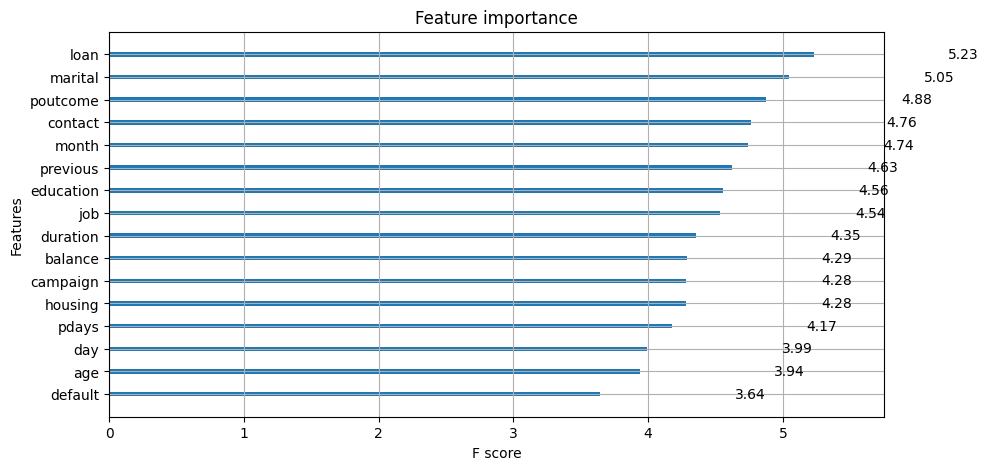

In [7]:
print(ctgan_best_params)
get_model_performance(ctgan_best_params, castgan_syn_X_train, y_train, X_test, y_test, 
                      plot_feat_impt=True, plot_w=10, plot_h=5)

{'max_depth': 6, 'learning_rate': 0.163957979732405, 'min_child_weight': 4, 'subsample': 0.837724922374966, 'booster': 'gbtree', 'lambda': 0.4844197131439675, 'gamma': 0.11843978471826438, 'grow_policy': 'lossguide', 'objective': 'binary:hinge', 'enable_categorical': True, 'eval_metric': 'auc', 'seed': 10, 'nthread': 4, 'saved_feature_importance_type': 1, 'verbosity': 0}
Testing AUC is 0.5932100011431408, Testing Average Precision is 0.5282736057146934


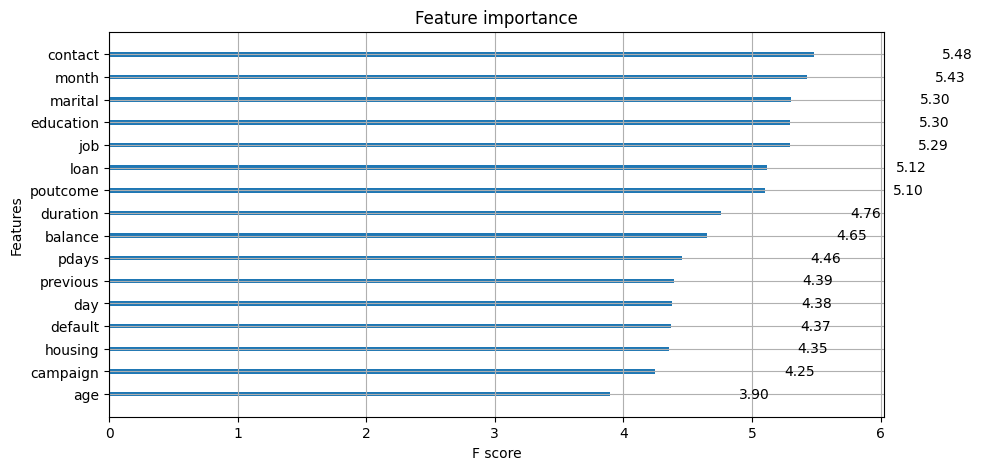

In [8]:
print(castgan_best_params)
get_model_performance(castgan_best_params, castgan_syn_X_train, y_train, X_test, y_test, 
                      plot_feat_impt=True, plot_w=10, plot_h=5)

## Summary

* For CTGAN synthetic data, baseline works slightly better, the param set is:
  * `{'booster': 'gbtree', 'nthread': 4, 'seed': 10, 'eval_metric': 'auc', 'objective': 'binary:hinge', 'max_depth': 8, 'min_child_weight': 3,'subsample': 0.8, 'enable_categorical': True,'learning_rate': 0.17937097905882862}`
  
* For CastGAN synthetic data, selected param set is:
  * `{'max_depth': 6, 'learning_rate': 0.163957979732405, 'min_child_weight': 4, 'subsample': 0.837724922374966, 'booster': 'gbtree', 'lambda': 0.4844197131439675, 'gamma': 0.11843978471826438, 'grow_policy': 'lossguide', 'objective': 'binary:hinge', 'enable_categorical': True, 'eval_metric': 'auc', 'seed': 10, 'nthread': 4, 'saved_feature_importance_type': 1, 'verbosity': 0}`